<a href="https://colab.research.google.com/github/AnnetteJohn/AnnetteJohn/blob/main/MayV2_MoE_Baseline_Ablation_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

May 10th Code
-> Removing the Visualizations to streamline important parts of code
-> removing redundant and debug code to keep only working bits
-> re-writing existing working code in a more readble format




In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from tqdm import tqdm
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter

# Set path for saving results
DRIVE_SAVE_PATH = '/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/'
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

# Data Extration from MIMIC-Note


In [3]:
!pip install dask pandas

In [4]:
import dask.dataframe as dd
import pandas as pd


In [6]:
# Load discharge summaries and radiology reports
discharge_notes = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Note/note/discharge.csv.gz")
radiology_notes = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Note/note/radiology.csv.gz")

# Convert to pandas for analysis (we'll do this first to understand our data)
print("Loading notes into memory...")
discharge_df = discharge_notes.compute()
radiology_df = radiology_notes.compute()



/usr/local/lib/python3.11/dist-packages/dask/backends.py:140: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/dask/backends.py:140: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  return func(*args, **kwargs)


Loading notes into memory...


In [ ]:
# Get prostate cancer patients, we are doing this by accessing the diagnoses dataframe, and then filtering based on PCa ICD codes
# Diagnoses data
diagnoses = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/diagnoses_icd.csv.gz",
                       compression="gzip", blocksize=None)
print("Identifying prostate cancer patients...")
prostate_codes = ['185', 'C61']  # ICD-9 and ICD-10
pc_diagnoses = diagnoses[diagnoses.icd_code.isin(prostate_codes)].compute()



Identifying prostate cancer patients...


In [5]:
#to directly load the saved pc_diagnoses
pc_diagnoses = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Diagnoses/pc_diagnoses.csv')


In [8]:
#Based on the filtered records in diagnoses, we identify the number of unique prostate cancer patients
pc_subject_ids = pc_diagnoses.subject_id.unique()
print(f"Found {len(pc_subject_ids)} prostate cancer patients")

Found 2497 prostate cancer patients


In [9]:
# Filter notes to only prostate cancer patients
discharge_prostate = discharge_df[discharge_df['subject_id'].isin(pc_subject_ids)]
radiology_prostate = radiology_df[radiology_df['subject_id'].isin(pc_subject_ids)]

In [10]:
# Basic statistics prostate specific
print("\nBasic Statistics:")
print(f"Number of prostate discharge summaries: {len(discharge_prostate)}")
print(f"Number of prostate radiology reports: {len(radiology_prostate)}")
print(f"Unique patients in prostate discharge summaries: {discharge_prostate['subject_id'].nunique()}")
print(f"Unique patients in prostate radiology reports: {radiology_prostate['subject_id'].nunique()}")



Basic Statistics:
Number of prostate discharge summaries: 6344
Number of prostate radiology reports: 35360
Unique patients in prostate discharge summaries: 1969
Unique patients in prostate radiology reports: 2017


In [11]:
# Basic text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and extra whitespace
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)  # Remove deidentified brackets
    text = re.sub(r'\n', ' ', text)              # Replace newlines with space
    text = re.sub(r'\s+', ' ', text)             # Replace multiple spaces
    text = text.strip()                          # Remove leading/trailing whitespace
    return text



In [12]:
# Clean the notes (prostate-specific)
print("\nCleaning notes (prostate-specific)...")
discharge_prostate['clean_text'] = discharge_prostate['text'].apply(clean_text)
radiology_prostate['clean_text'] = radiology_prostate['text'].apply(clean_text)



Cleaning notes (prostate-specific)...


<ipython-input-12-968d04d7969a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_prostate['clean_text'] = discharge_prostate['text'].apply(clean_text)
<ipython-input-12-968d04d7969a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiology_prostate['clean_text'] = radiology_prostate['text'].apply(clean_text)


In [13]:
# Get note lenghts for prostate-specific patients
discharge_prostate['note_length'] = discharge_prostate['clean_text'].str.len()
radiology_prostate['note_length'] = radiology_prostate['clean_text'].str.len()


<ipython-input-13-c5a4ff9117b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_prostate['note_length'] = discharge_prostate['clean_text'].str.len()
<ipython-input-13-c5a4ff9117b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiology_prostate['note_length'] = radiology_prostate['clean_text'].str.len()


In [14]:
# Convert chartdate/charttime to datetime
discharge_prostate['charttime'] = pd.to_datetime(discharge_prostate['charttime'])
radiology_prostate['charttime'] = pd.to_datetime(radiology_prostate['charttime'])



<ipython-input-14-fb2de94d37d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_prostate['charttime'] = pd.to_datetime(discharge_prostate['charttime'])
<ipython-input-14-fb2de94d37d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radiology_prostate['charttime'] = pd.to_datetime(radiology_prostate['charttime'])


In [ ]:
# Basic EDA (prostate specific)
print("\nNote Length Statistics:")
print("\nDischarge Summaries prostate specific:")
print(discharge_prostate['note_length'].describe())
print("\nRadiology Reports prostate specific:")
print(radiology_prostate['note_length'].describe())




Note Length Statistics:

Discharge Summaries prostate specific:
count     6344.000000
mean     10410.965952
std       4161.917928
min        527.000000
25%       7547.500000
50%       9698.000000
75%      12560.000000
max      40333.000000
Name: note_length, dtype: float64

Radiology Reports prostate specific:
count    35360.000000
mean      1310.885181
std       1117.622956
min         10.000000
25%        540.000000
50%        847.000000
75%       1759.000000
max      10318.000000
Name: note_length, dtype: float64


\

In [ ]:
discharge_prostate

note_id  subject_id   hadm_id note_type  note_seq  charttime  \
268      10006716-DS-6    10006716  21249009        DS         6 2183-02-13   
361     10011126-DS-22    10011126  26463677        DS        22 2155-11-24   
362     10011126-DS-23    10011126  24701479        DS        23 2156-02-26   
496     10014610-DS-21    10014610  23424056        DS        21 2168-08-06   
497     10014610-DS-22    10014610  27041220        DS        22 2168-08-21   
...                ...         ...       ...       ...       ...        ...   
331438  19989783-DS-20    19989783  25490687        DS        20 2126-08-28   
331439  19989783-DS-21    19989783  22784678        DS        21 2128-06-21   
331440  19989783-DS-22    19989783  23110090        DS        22 2130-03-26   
331441  19989783-DS-23    19989783  26984195        DS        23 2130-08-01   
331442  19989783-DS-24    19989783  24282820        DS        24 2130-08-07   

                  storetime  \
268     2183-02-14 13:19:00   
361     2155-11-30 14:40:00   
362     2156-03-07 20:37:00   
496     2168-08-06 14:34:00   
497     2168-08-21 10:40:00   
...                     ...   
331438  2126-09-01 14:18:00   
331439  2128-06-21 22:19:00   
331440  2130-03-26 23:42:00   
331441  2130-08-01 15:01:00   
331442  2130-08-07 12:43:00   

                                                     text  \
268      
Name:  ___             Unit No:   ___
 
Admi...   
361      
Name:  ___                    Unit No:   ___...   
362      
Name:  ___                    Unit No:   ___...   
496      
Name:  ___                 Unit No:   ___
 
...   
497      
Name:  ___                 Unit No:   ___
 
...   
...                                                   ...   
331438   
Name:  ___                   Unit No:   ___
...   
331439   
Name:  ___                   Unit No:   ___
...   
331440   
Name:  ___                   Unit No:   ___
...   
331441   
Name:  ___                   Unit No:   ___
...   
331442   
Name:  ___                   Unit No:   ___
...   

                                               clean_text  note_length  
268     name: ___ unit no: ___ admission date: ___ dis...         5725  
361     name: ___ unit no: ___ admission date: ___ dis...         8520  
362     name: ___ unit no: ___ admission date: ___ dis...         8262  
496     name: ___ unit no: ___ admission date: ___ dis...         8220  
497     name: ___ unit no: ___ admission date: ___ dis...         9541  
...                                                   ...          ...  
331438  name: ___ unit no: ___ admission date: ___ dis...        11308  
331439  name: ___ unit no: ___ admission date: ___ dis...        15194  
331440  name: ___ unit no: ___ admission date: ___ dis...        16022  
331441  name: ___ unit no: ___ admission date: ___ dis...         8551  
331442  name: ___ unit no: ___ admission date: ___ dis...         6793  

[6344 rows x 10 columns]

In [ ]:
radiology_prostate

note_id  subject_id     hadm_id note_type  note_seq  \
1969     10006716-RR-16    10006716         NaN        RR        16   
1970     10006716-RR-19    10006716         NaN        RR        19   
2595     10011126-RR-23    10011126  26463677.0        RR        23   
2596     10011126-RR-24    10011126  26463677.0        RR        24   
2597     10011126-RR-25    10011126  24701479.0        RR        25   
...                 ...         ...         ...       ...       ...   
2319106  19989783-RR-50    19989783  24282820.0        RR        50   
2319107  19989783-RR-51    19989783  24282820.0        RR        51   
2319108  19989783-RR-54    19989783         NaN        RR        54   
2319109   19989783-RR-8    19989783  25490687.0        RR         8   
2319110   19989783-RR-9    19989783  25490687.0        RR         9   

                  charttime            storetime  \
1969    2182-09-10 08:31:00  2182-09-10 12:54:00   
1970    2185-02-15 14:28:00  2185-02-15 17:07:00   
2595    2155-11-20 12:26:00  2155-11-20 12:50:00   
2596    2155-11-20 12:10:00  2155-11-20 23:28:00   
2597    2156-02-24 04:32:00  2156-02-24 07:35:00   
...                     ...                  ...   
2319106 2130-08-02 23:13:00  2130-08-03 11:57:00   
2319107 2130-08-04 09:51:00  2130-08-04 17:42:00   
2319108 2130-11-07 09:51:00  2130-11-07 16:51:00   
2319109 2126-08-11 19:23:00  2126-08-11 20:50:00   
2319110 2126-08-12 15:30:00  2126-08-12 16:18:00   

                                                      text  \
1969     HISTORY:  ___ man with history of prostate can...   
1970     EXAMINATION:  MR LUMBAR SPINE WITH AND WITHOUT...   
2595     HISTORY:  ___ male with abdominal pain and fev...   
2596     INDICATION:  ___ man with abdominal pain, feve...   
2597     INDICATION:  Nausea and vomiting.

COMPARISON:...   
...                                                    ...   
2319106  EXAMINATION:  CHEST (PORTABLE AP)

INDICATION:...   
2319107  INDICATION:  ___ with NICM (EF 25% ___, CKD St...   
2319108  EXAMINATION:  US ABD LIMIT, SINGLE ORGAN PORT
...   
2319109  EXAMINATION:  CHEST (PORTABLE AP)

INDICATION:...   
2319110  EXAMINATION:  RENAL U.S.

INDICATION:  ___ yea...   

                                                clean_text  note_length  
1969     history: ___ man with history of prostate canc...         1960  
1970     examination: mr lumbar spine with and without ...         1546  
2595     history: ___ male with abdominal pain and feve...          387  
2596     indication: ___ man with abdominal pain, fever...         1974  
2597     indication: nausea and vomiting. comparison: _...          260  
...                                                    ...          ...  
2319106  examination: chest (portable ap) indication: _...          767  
2319107  indication: ___ with nicm (ef 25% ___, ckd sta...         1790  
2319108  examination: us abd limit, single organ port i...          517  
2319109  examination: chest (portable ap) indication: _...          559  
2319110  examination: renal u.s. indication: ___ year o...         1473  

[35360 rows x 10 columns]

## Loading structured tables

In [ ]:
#Load Structured Tables
print("Loading structured tables...")

# Core patient data
patients = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/patients.csv.gz",
                      compression="gzip", blocksize=None)

# Admissions data
admissions = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/admissions.csv.gz",
                        compression="gzip", dtype={"deathtime": "object"}, blocksize=None)


Loading structured tables...


In [ ]:
import numpy as np
#Save these subject ids to Drive
np.save('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_PatientIDs/prostate_cancer_subject_ids.npy', pc_subject_ids)


In [ ]:
#Save Diagnoses to Drive
pc_diagnoses.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Diagnoses/pc_diagnoses.csv', index=False)

In [ ]:
# Process Structured Data
print("\nProcessing structured data...")

# Get patient demographics
pc_patients = patients[patients.subject_id.isin(pc_subject_ids)].compute()
pc_admissions = admissions[admissions.subject_id.isin(pc_subject_ids)].compute()

#When reading directly
#pc_patients = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Patients/pc_patients.csv')
#pc_admissions = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Admissions/pc_admissions.csv')

# Basic demographics analysis
print("\nDemographic Statistics:")
print("\nAge Distribution:")
print(pc_patients['anchor_age'].describe())


Processing structured data...

Demographic Statistics:

Age Distribution:
count    2497.000000
mean       70.762515
std        11.466929
min        25.000000
25%        62.000000
50%        70.000000
75%        80.000000
max        91.000000
Name: anchor_age, dtype: float64


In [ ]:
#Save this information to Drive
pc_patients.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Patients/pc_patients.csv', index=False)
pc_admissions.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/PC_Admissions/pc_admissions.csv', index=False)

In [ ]:
pc_admissions # this contains admit and discharge times, but does not contain gender, but it also contains the hospital_expire_flag which tells us if the patient is dead or not, but does not give us time of death

subject_id   hadm_id            admittime            dischtime  \
419       10006716  21249009  2183-02-12 07:15:00  2183-02-13 11:25:00   
420       10006716  23161830  2191-11-06 15:39:00  2191-11-09 13:15:00   
421       10006716  24348100  2193-01-07 19:21:00  2193-01-12 16:45:00   
422       10006716  26174018  2192-08-21 13:39:00  2192-08-22 19:36:00   
623       10011126  24701479  2156-02-24 04:57:00  2156-02-26 15:00:00   
...            ...       ...                  ...                  ...   
545424    19989783  23110090  2130-03-15 22:37:00  2130-03-26 16:30:00   
545425    19989783  24282820  2130-08-02 17:27:00  2130-08-07 13:46:00   
545426    19989783  25490687  2126-08-11 00:00:00  2126-08-28 12:53:00   
545427    19989783  26984195  2130-07-12 08:34:00  2130-08-01 15:50:00   
545428    19989783  28157210  2126-06-16 22:11:00  2126-06-18 19:30:00   

       deathtime     admission_type admit_provider_id     admission_location  \
419         <NA>           ELECTIVE            P61ON4     PHYSICIAN REFERRAL   
420         <NA>  OBSERVATION ADMIT            P086OF  WALK-IN/SELF REFERRAL   
421         <NA>  OBSERVATION ADMIT            P690UI  WALK-IN/SELF REFERRAL   
422         <NA>  OBSERVATION ADMIT            P76H5F  WALK-IN/SELF REFERRAL   
623         <NA>           EW EMER.            P35WW6         EMERGENCY ROOM   
...          ...                ...               ...                    ...   
545424      <NA>  OBSERVATION ADMIT            P2915M     PHYSICIAN REFERRAL   
545425      <NA>           EW EMER.            P07KMB  WALK-IN/SELF REFERRAL   
545426      <NA>       DIRECT EMER.            P32VJE     PHYSICIAN REFERRAL   
545427      <NA>  OBSERVATION ADMIT            P42XKM     PHYSICIAN REFERRAL   
545428      <NA>           EW EMER.            P975A9         EMERGENCY ROOM   

                  discharge_location insurance language marital_status  \
419                             HOME   Private  English        MARRIED   
420                             HOME  Medicare  English        MARRIED   
421                             HOME  Medicare  English        MARRIED   
422                             HOME  Medicare  English        MARRIED   
623                             HOME  Medicare  English        MARRIED   
...                              ...       ...      ...            ...   
545424              HOME HEALTH CARE  Medicare  English         SINGLE   
545425  CHRONIC/LONG TERM ACUTE CARE  Medicare  English         SINGLE   
545426              HOME HEALTH CARE   Private  English         SINGLE   
545427  CHRONIC/LONG TERM ACUTE CARE  Medicare  English         SINGLE   
545428                          HOME   Private  English         SINGLE   

                          race            edregtime            edouttime  \
419                      WHITE                 <NA>                 <NA>   
420                      OTHER  2191-11-06 10:21:00  2191-11-06 21:09:00   
421                      WHITE  2193-01-07 11:22:00  2193-01-07 21:29:00   
422                      WHITE  2192-08-21 08:28:00  2192-08-21 14:33:00   
623                      WHITE  2156-02-24 03:36:00  2156-02-24 06:55:00   
...                        ...                  ...                  ...   
545424  BLACK/AFRICAN AMERICAN  2130-03-15 13:24:00  2130-03-16 00:01:00   
545425  BLACK/AFRICAN AMERICAN  2130-08-02 12:52:00  2130-08-02 18:31:00   
545426  BLACK/AFRICAN AMERICAN                 <NA>                 <NA>   
545427  BLACK/AFRICAN AMERICAN  2130-07-12 06:35:00  2130-07-12 09:01:00   
545428  BLACK/AFRICAN AMERICAN  2126-06-16 18:30:00  2126-06-16 23:11:00   

        hospital_expire_flag  
419                        0  
420                        0  
421                        0  
422                        0  
623                        0  
...                      ...  
545424                     0  
545425                     0  
545426                     0  
545427                     0  
545428         

In [ ]:
pc_patients #this tells us if the patient has expired or not and when along with age and gender

subject_id gender  anchor_age  anchor_year anchor_year_group  \
260       10006716      M          61         2183       2011 - 2013   
416       10011126      M          73         2155       2011 - 2013   
537       10014610      M          66         2166       2008 - 2010   
657       10017733      M          78         2114       2020 - 2022   
790       10021454      M          88         2125       2020 - 2022   
...            ...    ...         ...          ...               ...   
363388    19965744      M          87         2177       2020 - 2022   
363663    19973319      M          89         2120       2017 - 2019   
363718    19974907      M          63         2130       2014 - 2016   
363899    19979725      M          81         2143       2011 - 2013   
364251    19989783      M          71         2126       2014 - 2016   

               dod  
260           <NA>  
416     2156-03-15  
537           <NA>  
657           <NA>  
790     2125-03-24  
...            ...  
363388  2178-05-31  
363663        <NA>  
363718        <NA>  
363899        <NA>  
364251        <NA>  

[2497 rows x 6 columns]

In [ ]:
#New code march 25th
# Load lab events with specific handling for missing values
labevents = dd.read_csv(
    "/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/labevents.csv.gz",
    compression="gzip",
    usecols=['subject_id', 'itemid', 'charttime', 'value', 'valuenum', 'valueuom'],
    blocksize=None
)

# Filter for prostate cancer patients
pc_labs = labevents[labevents.subject_id.isin(pc_subject_ids)]

# Define key lab tests relevant to prostate cancer monitoring
key_lab_tests = {
    'PSA': 50974,
    'Testosterone': 50988,
    'Free Testosterone': 50894,
    'Alkaline Phosphatase': 50863,
    'Creatinine': 50912
}

# Filter for just these relevant tests
pc_relevant_labs = pc_labs[pc_labs.itemid.isin(list(key_lab_tests.values()))].compute()

# Convert time to datetime
pc_relevant_labs['charttime'] = pd.to_datetime(pc_relevant_labs['charttime'])

# Sort by patient and time
pc_relevant_labs = pc_relevant_labs.sort_values(['subject_id', 'charttime'])



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [15]:
#Run only when loading
pc_relevant_labs = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/pc_relevant_labs.csv')

In [16]:
# Handle missing values
# For valuenum (numeric results)
pc_relevant_labs['valuenum'] = pc_relevant_labs['valuenum'].fillna(0)

# Group by patient and test type to identify missing tests
patient_test_coverage = pc_relevant_labs.groupby(['subject_id', 'itemid']).size().unstack(fill_value=0)
print(f"Test coverage by patient:\n{patient_test_coverage.describe()}")



Test coverage by patient:
itemid        50863        50894        50912        50974        50988
count   2494.000000  2494.000000  2494.000000  2494.000000  2494.000000
mean      13.861267     0.136728    36.186447     7.215317     1.824779
std       28.477843     0.649099    50.312439    11.483841     4.854168
min        0.000000     0.000000     1.000000     0.000000     0.000000
25%        1.000000     0.000000     8.000000     0.000000     0.000000
50%        5.000000     0.000000    20.000000     3.000000     0.000000
75%       15.000000     0.000000    44.750000     9.000000     1.000000
max      337.000000    13.000000   573.000000   102.000000    79.000000


In [ ]:
# Save processed data
pc_relevant_labs.to_csv('pc_relevant_labs.csv', index=False)

In [17]:
# Only include patients with at least 3 PSA measurements
patients_with_sufficient_psa = patient_test_coverage[patient_test_coverage[50974] >= 3].index

In [18]:
# Prioritize tests with better coverage for time-series features
priority_tests = [50974, 50863, 50912]  # PSA, ALP, Creatinine

In [ ]:
def create_patient_sequences(patient_id, min_tests=3, test_ids=[50974, 50863, 50912], max_seq_length=20):
    """
    Create time-aligned lab test sequences for a patient

    Args:
        patient_id: Patient identifier
        min_tests: Minimum number of PSA tests required
        test_ids: List of test IDs to include (PSA, ALP, Creatinine)
        max_seq_length: Maximum sequence length to return

    Returns:
        Dictionary with patient sequences or None if insufficient data
    """
    # Get all lab data for this patient
    patient_data = pc_relevant_labs[pc_relevant_labs.subject_id == patient_id]

    # Check if patient has minimum required PSA tests
    psa_tests = patient_data[patient_data.itemid == 50974]
    if len(psa_tests) < min_tests:
        return None  # Skip patients with insufficient data

    # Sort all patient data by time
    patient_data = patient_data.sort_values('charttime')

    # Get unique timestamps (we'll align all tests to these)
    timestamps = sorted(patient_data['charttime'].unique())

    # If we have too many timestamps, keep the most recent ones
    if len(timestamps) > max_seq_length:
        timestamps = timestamps[-max_seq_length:]

    # Initialize sequence arrays for each test type
    sequences = {test_id: np.zeros(len(timestamps)) for test_id in test_ids}

    # Fill in values for each test at corresponding timestamps
    for test_id in test_ids:
        test_data = patient_data[patient_data.itemid == test_id]

        # For each timestamp, find the closest test value
        for i, timestamp in enumerate(timestamps):
            # Find tests on or before this timestamp
            prior_tests = test_data[test_data['charttime'] <= timestamp]

            if len(prior_tests) > 0:
                # Get the most recent test value
                latest_test = prior_tests.iloc[-1]
                sequences[test_id][i] = latest_test['valuenum']
            elif i > 0:
                # If no prior test, carry forward the previous value
                sequences[test_id][i] = sequences[test_id][i-1]

    # Create a dictionary with aligned sequences
    result = {
        'subject_id': patient_id,
        'timestamps': timestamps,
        'sequences': np.array([sequences[test_id] for test_id in test_ids]).T,  # Shape: [time_steps, features]
        'feature_names': [f"Test_{test_id}" for test_id in test_ids]
    }

    return result



In [ ]:
# Apply to all patients
patient_sequences = {}
for patient_id in pc_relevant_labs['subject_id'].unique():
    sequence = create_patient_sequences(patient_id)
    if sequence is not None:
        patient_sequences[patient_id] = sequence

print(f"Created sequences for {len(patient_sequences)} patients")



Created sequences for 1267 patients


In [ ]:
#OLD, don't run
# 1. Sequence data augmentation
def augment_patient_sequences_integers(patient_sequences, num_augmentations=2):
    """Augment patient sequences while maintaining integer IDs"""
    augmented_sequences = {}
    synthetic_to_original = {}  # Map to track synthetic->original relationship

    # Keep all original sequences
    for patient_id, sequence_data in patient_sequences.items():
        augmented_sequences[patient_id] = sequence_data

    # Get the maximum patient ID to ensure we create new unique IDs
    max_id = max([int(pid) for pid in patient_sequences.keys()])

    # Create augmented copies with new integer IDs
    new_id_start = max_id + 1
    for i, (patient_id, sequence_data) in enumerate(patient_sequences.items()):
        for j in range(num_augmentations):
            # Create new patient ID as sequential integers
            new_id = new_id_start + i*num_augmentations + j

            # Track mapping
            synthetic_to_original[new_id] = patient_id

            # Copy the data
            new_data = {
                'subject_id': new_id,
                'timestamps': sequence_data['timestamps'].copy(),
                'sequences': sequence_data['sequences'].copy(),
                'feature_names': sequence_data['feature_names']
            }

            # Add noise to sequence values (5-7% random variation)
            noise = np.random.normal(0, 0.07, new_data['sequences'].shape)
            new_data['sequences'] = new_data['sequences'] * (1 + noise)

            # Ensure values stay positive
            new_data['sequences'] = np.maximum(new_data['sequences'], 0)

            # Add to augmented dictionary
            augmented_sequences[new_id] = new_data

    return augmented_sequences, synthetic_to_original



In [ ]:
def augment_patient_sequences_integers(patient_sequences, num_augmentations=2):
    """
    Augment patient sequences while maintaining integer IDs and preserving PSA trends

    This version adds special handling for PSA values to better maintain their trends
    while still introducing realistic variation.
    """
    augmented_sequences = {}
    synthetic_to_original = {}  # Map to track synthetic->original relationship

    # Keep all original sequences
    for patient_id, sequence_data in patient_sequences.items():
        augmented_sequences[patient_id] = sequence_data

    # Get the maximum patient ID to ensure we create new unique IDs
    max_id = max([int(pid) for pid in patient_sequences.keys()])

    # Create augmented copies with new integer IDs
    new_id_start = max_id + 1
    for i, (patient_id, sequence_data) in enumerate(patient_sequences.items()):
        for j in range(num_augmentations):
            # Create new patient ID as sequential integers
            new_id = new_id_start + i*num_augmentations + j

            # Track mapping
            synthetic_to_original[new_id] = patient_id

            # Copy the data
            new_data = {
                'subject_id': new_id,
                'timestamps': sequence_data['timestamps'].copy(),
                'sequences': sequence_data['sequences'].copy(),
                'feature_names': sequence_data['feature_names']
            }

            # Process each feature separately to preserve PSA trends
            for feature_idx in range(new_data['sequences'].shape[1]):
                feature_values = new_data['sequences'][:, feature_idx].copy()

                # Treat PSA values (typically the first feature) differently
                if feature_idx == 0:  # PSA feature
                    # Calculate original PSA trend
                    x = np.arange(len(feature_values))
                    if len(x) > 1:  # Need at least 2 points for trend calculation
                        original_trend = np.polyfit(x, feature_values, 1)[0]

                        # Apply reduced noise to PSA values
                        noise = np.random.normal(0, 0.05, feature_values.shape)
                        new_values = feature_values * (1 + noise)

                        # Calculate trend of the new values
                        new_trend = np.polyfit(x, new_values, 1)[0]

                        # If trends differ significantly, adjust to better match original trend
                        if abs(original_trend) > 0.001 and abs(new_trend) > 0.001:
                            # Calculate adjustment factor to match original trend
                            adjustment = original_trend / new_trend
                            # Keep adjustment within reasonable bounds
                            adjustment = max(0.5, min(1.5, adjustment))

                            # Apply adjustment to maintain trend
                            trend_diff = feature_values[-1] * adjustment - feature_values[-1]
                            # Create trend-adjusted values with smooth progression
                            trend_factors = np.linspace(1.0, adjustment, len(feature_values))
                            new_values = feature_values * trend_factors
                    else:
                        # For very short sequences, just apply standard noise
                        noise = np.random.normal(0, 0.05, feature_values.shape)
                        new_values = feature_values * (1 + noise)

                    new_data['sequences'][:, feature_idx] = new_values
                else:
                    # Standard noise for other features (ALP, Creatinine, etc.)
                    noise = np.random.normal(0, 0.07, feature_values.shape)
                    new_data['sequences'][:, feature_idx] = feature_values * (1 + noise)

            # Ensure all values stay positive
            new_data['sequences'] = np.maximum(new_data['sequences'], 0)

            # Add to augmented dictionary
            augmented_sequences[new_id] = new_data

    return augmented_sequences, synthetic_to_original

In [ ]:
# Apply the fixed augmentation
print(f"Original number of patients: {len(patient_sequences)}")
patient_sequences_augmented, synthetic_mapping = augment_patient_sequences_integers(
    patient_sequences,
    num_augmentations=2
)
print(f"After augmentation: {len(patient_sequences_augmented)} patients")
print(f"Created {len(synthetic_mapping)} synthetic patients")

# Use the augmented sequences
patient_sequences = patient_sequences_augmented

Original number of patients: 1267
After augmentation: 3801 patients
Created 2534 synthetic patients



Example for patient 10907349:
Sequence shape: (20, 3)
First few timestamps: ['2180-12-13 09:20:00', '2181-03-12 08:19:00', '2181-03-12 09:08:00']
Feature names: ['Test_50974', 'Test_50863', 'Test_50912']


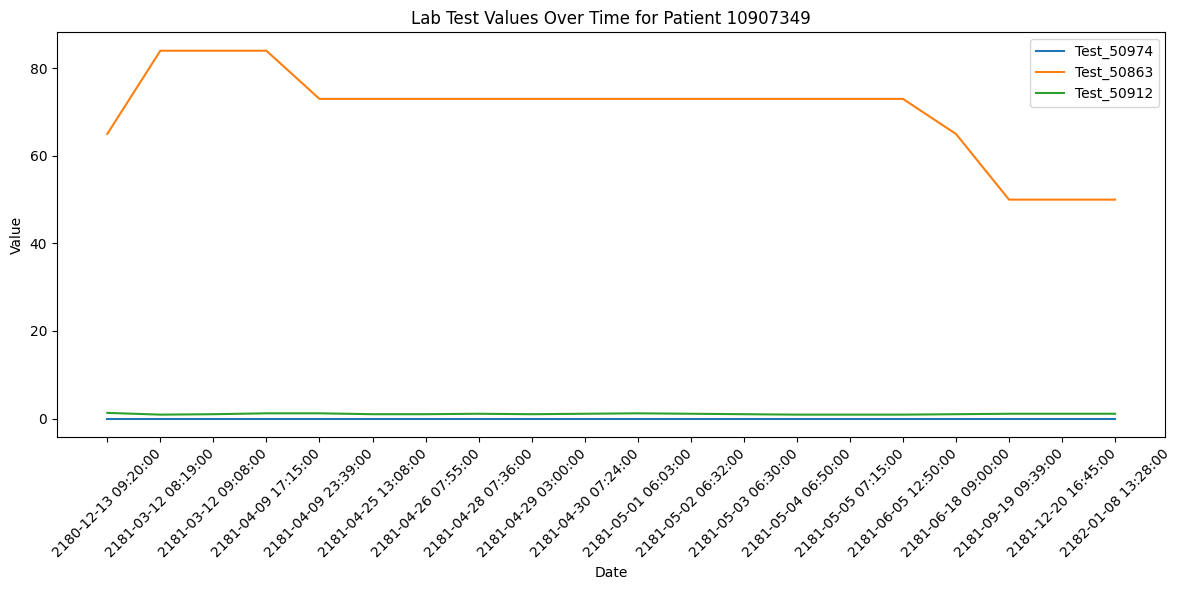

In [ ]:
# Example of how the data looks for one patient
if len(patient_sequences) > 0:
    example_patient = list(patient_sequences.keys())[110]
    example_sequence = patient_sequences[example_patient]

    print(f"\nExample for patient {example_patient}:")
    print(f"Sequence shape: {example_sequence['sequences'].shape}")
    print(f"First few timestamps: {example_sequence['timestamps'][:3]}")
    print(f"Feature names: {example_sequence['feature_names']}")

    # Plot the sequences for this patient
    plt.figure(figsize=(12, 6))
    for i, feature_name in enumerate(example_sequence['feature_names']):
        plt.plot(example_sequence['timestamps'],
                 example_sequence['sequences'][:, i],
                 label=feature_name)

    plt.title(f"Lab Test Values Over Time for Patient {example_patient}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Define a function to ensure timestamps are datetime objects
def ensure_datetime(timestamps):
    """Convert timestamps to datetime objects if they're strings"""
    if isinstance(timestamps, list) or isinstance(timestamps, np.ndarray):
        if len(timestamps) > 0:
            if isinstance(timestamps[0], str):
                return [pd.to_datetime(ts) for ts in timestamps]
    return timestamps

# Modify your existing code for creating sequence features
sequence_features = []
for subject_id, sequence_data in patient_sequences.items():
    # Ensure timestamps are datetime objects
    timestamps = ensure_datetime(sequence_data['timestamps'])

    # Check if conversion worked
    if isinstance(timestamps[0], str):
        print(f"Warning: Timestamps for patient {subject_id} are still strings after conversion")
        # Try a different approach
        timestamps = [pd.Timestamp(ts) for ts in timestamps]

    # Extract key features from each sequence
    try:
        duration_days = (timestamps[-1] - timestamps[0]).total_seconds() / (24*3600)
    except TypeError:
        print(f"Error calculating duration for patient {subject_id}")
        print(f"Timestamp types: {type(timestamps[0])}, {type(timestamps[-1])}")
        print(f"Timestamp values: {timestamps[0]}, {timestamps[-1]}")
        # Use a default duration
        duration_days = 30.0

    seq_features = {
        'subject_id': subject_id,
        'num_timepoints': len(timestamps),
        'sequence_duration_days': duration_days,
        'latest_psa': sequence_data['sequences'][-1, 0],  # Last PSA value
        'latest_alp': sequence_data['sequences'][-1, 1],  # Last ALP value
        'latest_creatinine': sequence_data['sequences'][-1, 2],  # Last Creatinine value
        'max_psa': np.max(sequence_data['sequences'][:, 0]),
        'max_alp': np.max(sequence_data['sequences'][:, 1]),
        'max_creatinine': np.max(sequence_data['sequences'][:, 2]),
        'psa_slope': np.polyfit(range(len(sequence_data['sequences'][:, 0])),
                             sequence_data['sequences'][:, 0], 1)[0]  # Linear trend
    }

    # Add the full sequence data as numpy arrays
    seq_features['full_sequence_data'] = sequence_data['sequences']
    seq_features['timestamps'] = timestamps

    sequence_features.append(seq_features)

# Convert to DataFrame
sequence_df = pd.DataFrame(sequence_features)

In [ ]:
#create the target variables in pc_admissions
pc_admissions = pc_admissions.copy()  # Make a copy to avoid SettingWithCopyWarning

# 1. Mortality
pc_admissions['mortality'] = (~pd.isna(pc_admissions['deathtime'])).astype(int)

# 2. Length of Stay
pc_admissions['admittime'] = pd.to_datetime(pc_admissions['admittime'])
pc_admissions['dischtime'] = pd.to_datetime(pc_admissions['dischtime'])
pc_admissions['los_days'] = (pc_admissions['dischtime'] - pc_admissions['admittime']).dt.total_seconds() / (24 * 60 * 60)

# 3. Readmission
pc_admissions = pc_admissions.sort_values(['subject_id', 'admittime'])
pc_admissions['next_admit'] = pc_admissions.groupby('subject_id')['admittime'].shift(-1)
pc_admissions['days_to_readmit'] = (pd.to_datetime(pc_admissions['next_admit']) -
                                   pc_admissions['dischtime']).dt.total_seconds() / (24 * 60 * 60)
pc_admissions['readmission_30d'] = (pc_admissions['days_to_readmit'] <= 30).astype(int)

# Now we can check what we have
print("\nTarget Variables Summary:")
print("\nMortality rates:")
print(pc_admissions['mortality'].value_counts(normalize=True))

print("\nLength of stay statistics:")
print(pc_admissions['los_days'].describe())

print("\n30-day readmission rates:")
print(pc_admissions['readmission_30d'].value_counts(normalize=True))




Target Variables Summary:

Mortality rates:
mortality
0    0.975599
1    0.024401
Name: proportion, dtype: float64

Length of stay statistics:
count    9344.000000
mean        4.926475
std         6.916112
min        -0.576389
25%         1.423437
50%         2.962500
75%         5.917361
max       134.682639
Name: los_days, dtype: float64

30-day readmission rates:
readmission_30d
0    0.774722
1    0.225278
Name: proportion, dtype: float64


In [ ]:
# 2. Demographics and admissions augmentation
def augment_demographics_and_admissions(pc_patients, pc_admissions, synthetic_mapping):
    """Create augmented demographic and admission records"""
    pc_patients_augmented = pc_patients.copy()
    pc_admissions_augmented = pc_admissions.copy()

    # For each synthetic patient ID, create corresponding records
    for synth_id, orig_id in synthetic_mapping.items():
        # Create demographic record for synthetic patient
        if orig_id in pc_patients['subject_id'].values:
            orig_demographics = pc_patients[pc_patients['subject_id'] == orig_id].copy()
            orig_demographics['subject_id'] = synth_id
            pc_patients_augmented = pd.concat([pc_patients_augmented, orig_demographics])

        # Create admission record for synthetic patient
        if orig_id in pc_admissions['subject_id'].values:
            orig_admissions = pc_admissions[pc_admissions['subject_id'] == orig_id].copy()
            orig_admissions['subject_id'] = synth_id

            # Add small random variation to length of stay (±10%)
            if 'los_days' in orig_admissions.columns:
                noise_factor = np.random.uniform(0.9, 1.1, size=len(orig_admissions))
                orig_admissions['los_days'] = orig_admissions['los_days'] * noise_factor

            pc_admissions_augmented = pd.concat([pc_admissions_augmented, orig_admissions])

    return pc_patients_augmented, pc_admissions_augmented


pc_patients_augmented, pc_admissions_augmented = augment_demographics_and_admissions(
    pc_patients.copy(), pc_admissions.copy(), synthetic_mapping
)

In [ ]:
# Use the augmented data for subsequent steps
pc_patients = pc_patients_augmented
pc_admissions = pc_admissions_augmented


In [ ]:
print(synthetic_mapping.items())

dict_items([(19974908, np.int64(10006716)), (19974909, np.int64(10006716)), (19974910, np.int64(10014610)), (19974911, np.int64(10014610)), (19974912, np.int64(10024331)), (19974913, np.int64(10024331)), (19974914, np.int64(10046298)), (19974915, np.int64(10046298)), (19974916, np.int64(10048001)), (19974917, np.int64(10048001)), (19974918, np.int64(10048825)), (19974919, np.int64(10048825)), (19974920, np.int64(10052926)), (19974921, np.int64(10052926)), (19974922, np.int64(10079616)), (19974923, np.int64(10079616)), (19974924, np.int64(10108214)), (19974925, np.int64(10108214)), (19974926, np.int64(10113093)), (19974927, np.int64(10113093)), (19974928, np.int64(10115311)), (19974929, np.int64(10115311)), (19974930, np.int64(10119826)), (19974931, np.int64(10119826)), (19974932, np.int64(10124291)), (19974933, np.int64(10124291)), (19974934, np.int64(10135235)), (19974935, np.int64(10135235)), (19974936, np.int64(10143446)), (19974937, np.int64(10143446)), (19974938, np.int64(10154575

In [ ]:
# 1. Process clinical notes to generate embeddings
# First, load ClinicalBERT
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm

print("Loading ClinicalBERT model...")
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")



Loading ClinicalBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Using device: cuda


In [ ]:
# Process notes in smaller batches with simplified error handling
def get_note_embeddings(texts, batch_size=8):
    """Process texts and return embeddings"""
    if not isinstance(texts, list):
        texts = [texts]

    all_embeddings = []

    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        try:
            # Tokenize and get embeddings
            inputs = tokenizer(batch, padding=True, truncation=True,
                             max_length=512, return_tensors="pt").to(device)

            # Disable gradient calculation for inference
            with torch.no_grad():
                outputs = model(**inputs)

            # Get the [CLS] token embedding for each sequence
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(batch_embeddings)

        except Exception as e:
            print(f"Error processing batch: {e}")
            # Return zeros for failed batches
            batch_embeddings = np.zeros((len(batch), model.config.hidden_size))
            all_embeddings.append(batch_embeddings)

    # Combine all batch results
    if all_embeddings:
        return np.vstack(all_embeddings)
    else:
        return np.zeros((len(texts), model.config.hidden_size))



In [ ]:
# 2. Process discharge notes
print("Processing discharge notes...")
discharge_features = []

# Group by patient to handle multiple notes per patient
for subject_id, group in tqdm(discharge_prostate.groupby('subject_id')):
    try:
        # Get all notes for this patient
        texts = group['clean_text'].tolist()

        # Get embeddings for all notes
        embeddings = get_note_embeddings(texts)

        # Average the embeddings if there are multiple notes
        avg_embedding = np.mean(embeddings, axis=0)

        discharge_features.append({
            'subject_id': subject_id,
            'discharge_embedding': avg_embedding
        })
    except Exception as e:
        print(f"Error processing patient {subject_id}: {e}")
        # Add zeros for failed patients
        discharge_features.append({
            'subject_id': subject_id,
            'discharge_embedding': np.zeros(model.config.hidden_size)
        })


Processing discharge notes...


100%|██████████| 1969/1969 [01:13<00:00, 26.85it/s]


In [ ]:

# 3. Process radiology notes
print("\nProcessing radiology notes...")
radiology_features = []

for subject_id, group in tqdm(radiology_prostate.groupby('subject_id')):
    try:
        texts = group['clean_text'].tolist()
        embeddings = get_note_embeddings(texts)
        avg_embedding = np.mean(embeddings, axis=0)

        radiology_features.append({
            'subject_id': subject_id,
            'radiology_embedding': avg_embedding
        })
    except Exception as e:
        print(f"Error processing patient {subject_id}: {e}")
        radiology_features.append({
            'subject_id': subject_id,
            'radiology_embedding': np.zeros(model.config.hidden_size)
        })


Processing radiology notes...


100%|██████████| 2017/2017 [03:54<00:00,  8.59it/s]


In [ ]:
# 3. Clinical notes embeddings augmentation
def augment_clinical_notes(discharge_features, radiology_features, synthetic_to_original):
    """Augment clinical note embeddings"""
    # Convert to dictionaries for easier lookup
    discharge_dict = {item['subject_id']: item['discharge_embedding'] for item in discharge_features}
    radiology_dict = {item['subject_id']: item['radiology_embedding'] for item in radiology_features}

    # Create augmented embeddings
    augmented_discharge = []
    augmented_radiology = []

    for synth_id, orig_id in synthetic_to_original.items():
        # Augment discharge notes
        if orig_id in discharge_dict:
            orig_embedding = discharge_dict[orig_id]
            noise = np.random.normal(0, 0.02, size=orig_embedding.shape)
            augmented_discharge.append({
                'subject_id': synth_id,
                'discharge_embedding': orig_embedding * (1 + noise)
            })

        # Augment radiology notes
        if orig_id in radiology_dict:
            orig_embedding = radiology_dict[orig_id]
            noise = np.random.normal(0, 0.02, size=orig_embedding.shape)
            augmented_radiology.append({
                'subject_id': synth_id,
                'radiology_embedding': orig_embedding * (1 + noise)
            })

    # Combine original and augmented embeddings
    all_discharge_features = discharge_features + augmented_discharge
    all_radiology_features = radiology_features + augmented_radiology

    return all_discharge_features, all_radiology_features

In [ ]:

discharge_features_augmented, radiology_features_augmented = augment_clinical_notes(
    discharge_features,     # Original discharge note embeddings
    radiology_features,     # Original radiology note embeddings
    synthetic_mapping       # Mapping from synthetic to original IDs
)

# Print results to verify
print(f"Original discharge notes: {len(discharge_features)}")
print(f"Augmented discharge notes: {len(discharge_features_augmented)}")
print(f"Original radiology notes: {len(radiology_features)}")
print(f"Augmented radiology notes: {len(radiology_features_augmented)}")

Original discharge notes: 1969
Augmented discharge notes: 4043
Original radiology notes: 2017
Augmented radiology notes: 4213


In [ ]:
# Convert discharge note embeddings to DataFrame
print("Converting discharge embeddings to DataFrame...")
discharge_df = pd.DataFrame(discharge_features_augmented)

# Convert embeddings to individual columns
for i in range(len(discharge_df.iloc[0]['discharge_embedding'])):
    discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
discharge_df = discharge_df.drop(columns=['discharge_embedding'])


# Convert radiology note embeddings to DataFrame
print("Converting radiology embeddings to DataFrame...")
radiology_df = pd.DataFrame(radiology_features_augmented)
# Convert embeddings to individual columns
for i in range(len(radiology_df.iloc[0]['radiology_embedding'])):
    radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
radiology_df = radiology_df.drop(columns=['radiology_embedding'])

Converting discharge embeddings to DataFrame...


<ipython-input-46-05fbd6538ffd>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-46-05fbd6538ffd>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-46-05fbd6538ffd>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

Converting radiology embeddings to DataFrame...


<ipython-input-46-05fbd6538ffd>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-46-05fbd6538ffd>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-46-05fbd6538ffd>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [ ]:
print(f"Created sequence features DataFrame with {len(sequence_df)} rows")
print(f"Created demographics DataFrame with {len(pc_patients)} rows")
print(f"Created admissions DataFrame with {len(pc_admissions)} rows")
print(f"Created discharge embeddings DataFrame with {len(discharge_df)} rows")
print(f"Created radiology embeddings DataFrame with {len(radiology_df)} rows")

Created sequence features DataFrame with 3801 rows
Created demographics DataFrame with 5031 rows
Created admissions DataFrame with 21072 rows
Created discharge embeddings DataFrame with 4043 rows
Created radiology embeddings DataFrame with 4213 rows


In [ ]:
# Start the merging process
print("\nMerging all data components...")

# 1. First, ensure one row per patient in each dataframe
pc_patients_unique = pc_patients.drop_duplicates(subset=['subject_id'])
print(f"Unique patients in demographics: {len(pc_patients_unique)}")

pc_admissions_unique = pc_admissions.drop_duplicates(subset=['subject_id'])
print(f"Unique patients in admissions: {len(pc_admissions_unique)}")

sequence_df_unique = sequence_df.drop_duplicates(subset=['subject_id'])
print(f"Unique patients in sequences: {len(sequence_df_unique)}")

discharge_df_unique = discharge_df.drop_duplicates(subset=['subject_id'])
print(f"Unique patients in discharge notes: {len(discharge_df_unique)}")

radiology_df_unique = radiology_df.drop_duplicates(subset=['subject_id'])
print(f"Unique patients in radiology notes: {len(radiology_df_unique)}")


Merging all data components...
Unique patients in demographics: 5031
Unique patients in admissions: 5031
Unique patients in sequences: 3801
Unique patients in discharge notes: 4043
Unique patients in radiology notes: 4213


In [ ]:
# 2. Start with patient demographics + admissions (core info)
print("\nMerging demographics with admissions...")
# Select only relevant columns from admissions to avoid duplicate columns
admission_cols = ['subject_id', 'mortality', 'los_days', 'readmission_30d']
patient_core = pc_patients_unique.merge(
    pc_admissions_unique[admission_cols],
    on='subject_id',
    how='inner',  # Only keep patients with both demographics and admissions
    validate='1:1'  # Ensure one-to-one mapping
)
print(f"Patients with demographics and admissions: {len(patient_core)}")



Merging demographics with admissions...
Patients with demographics and admissions: 5031


In [ ]:
# 3. Add sequence features
print("\nAdding sequence features...")
patient_with_sequences = patient_core.merge(
    sequence_df_unique,
    on='subject_id',
    how='inner',  # Only keep patients that have sequence data
    validate='1:1'
)
print(f"Patients with demographics, admissions, and sequences: {len(patient_with_sequences)}")



Adding sequence features...
Patients with demographics, admissions, and sequences: 3801


In [ ]:
# 4. Add discharge notes (embeddings)
print("\nAdding discharge note embeddings...")
patient_with_discharge = patient_with_sequences.merge(
    discharge_df_unique,
    on='subject_id',
    how='left',  # Keep all patients, even if they don't have discharge notes
    validate='1:1'
)
print(f"After adding discharge notes: {len(patient_with_discharge)}")



Adding discharge note embeddings...
After adding discharge notes: 3801


In [ ]:
# 5. Add radiology notes (embeddings)
print("\nAdding radiology note embeddings...")
digital_twin_data = patient_with_discharge.merge(
    radiology_df_unique,
    on='subject_id',
    how='left',  # Keep all patients, even if they don't have radiology notes
    validate='1:1'
)
print(f"After adding radiology notes: {len(digital_twin_data)}")



Adding radiology note embeddings...
After adding radiology notes: 3801


In [ ]:
# 6. Add a more descriptive digital twin ID
digital_twin_data['digital_twin_id'] = 'DT_' + digital_twin_data['subject_id'].astype(str)


In [ ]:
# 7. Handle missing values
print("\nHandling missing values...")
# Fill missing embeddings with zeros
embedding_cols = [col for col in digital_twin_data.columns if 'emb_' in col]
digital_twin_data[embedding_cols] = digital_twin_data[embedding_cols].fillna(0)



Handling missing values...


In [ ]:
# Fill other missing numeric values with median
numeric_cols = digital_twin_data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
digital_twin_data[numeric_cols] = digital_twin_data[numeric_cols].fillna(digital_twin_data[numeric_cols].median())


In [ ]:
# 8. Verify original vs synthetic distribution
digital_twin_data['is_synthetic'] = digital_twin_data['subject_id'].apply(lambda x: 1 if x >= 15000000 else 0)
print("\nOriginal vs. Synthetic Statistics:")
print(f"Original patients: {(digital_twin_data['is_synthetic'] == 0).sum()}")
print(f"Synthetic patients: {(digital_twin_data['is_synthetic'] == 1).sum()}")
print(f"Total patients: {len(digital_twin_data)}")




Original vs. Synthetic Statistics:
Original patients: 642
Synthetic patients: 3159
Total patients: 3801


<ipython-input-90-8e7f5f4cf730>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  digital_twin_data['is_synthetic'] = digital_twin_data['subject_id'].apply(lambda x: 1 if x >= 15000000 else 0)


In [ ]:
# 9. Save the final dataset
print("\nSaving the final dataset...")
save_path = "/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/prostate_cancer_digital_twin_data_final.csv"
digital_twin_data.to_csv(save_path, index=False)
print(f"Successfully created digital twin data with {len(digital_twin_data)} patients and {len(digital_twin_data.columns)} features")
print(f"Dataset saved to: {save_path}")


Saving the final dataset...
Successfully created digital twin data with 3801 patients and 1558 features
Dataset saved to: /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/prostate_cancer_digital_twin_data_final.csv


In [19]:
digital_twin_data = pd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_final.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_final.csv'

#Clustering Analysis of Original vs. Synthetic Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# digital_twin_data = pd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_final.csv")

print("Performing clustering analysis to compare synthetic vs. original data...")


Performing clustering analysis to compare synthetic vs. original data...


In [ ]:
# 1. Select features for clustering
# Use lab values and demographics (avoid using embeddings initially for clearer visualization)
clustering_features = [
    'latest_psa', 'latest_alp', 'latest_creatinine',
    'max_psa', 'max_alp', 'max_creatinine',
    'psa_slope', 'num_timepoints', 'sequence_duration_days',
    'anchor_age'  # If available
]


In [ ]:
# Filter to keep only available features
clustering_features = [f for f in clustering_features if f in digital_twin_data.columns]


In [ ]:
# 2. Preprocess the data
X_cluster = digital_twin_data[clustering_features].copy()

# Handle any missing values
X_cluster = X_cluster.fillna(X_cluster.median())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [ ]:
# 3. Apply PCA for dimensionality reduction (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# 4. Perform clustering
n_clusters = 4  #can try different values
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

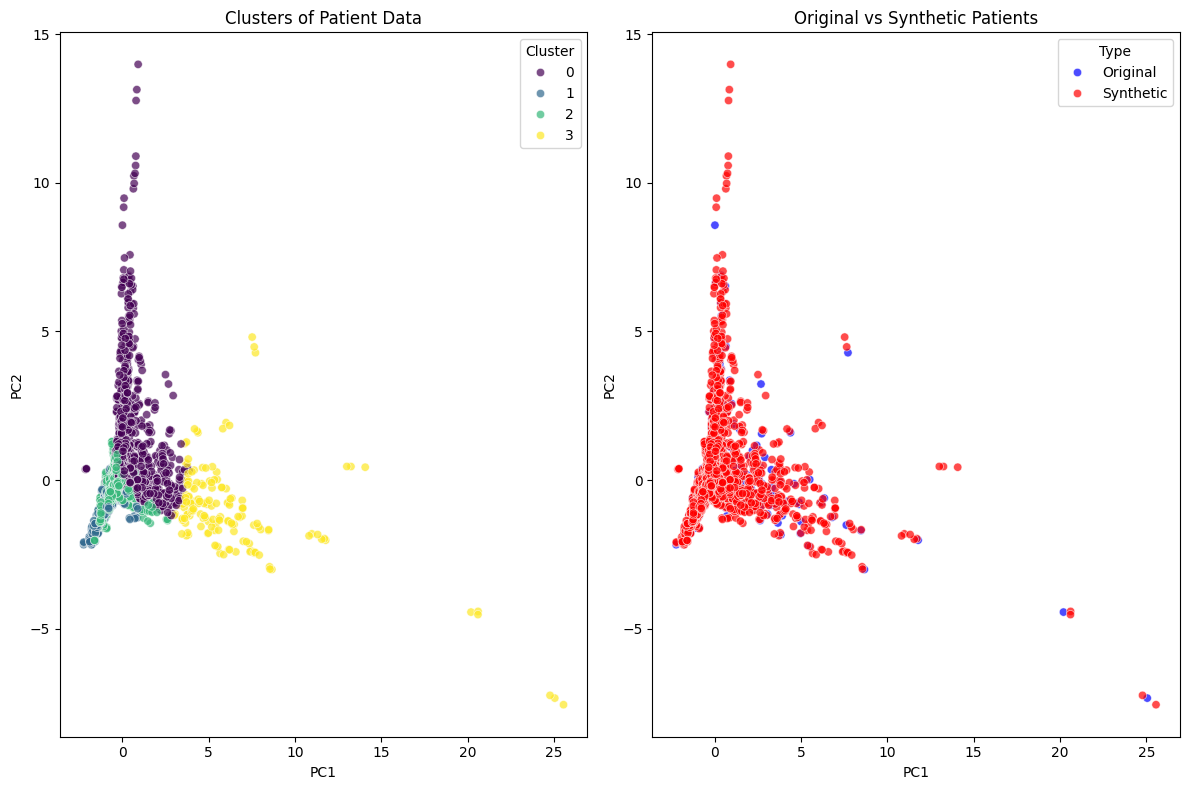

In [ ]:
# 5. Visualize the results
plt.figure(figsize=(12, 8))

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Type': ['Synthetic' if is_syn else 'Original' for is_syn in digital_twin_data['is_synthetic']]
})

# Plot by cluster
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='viridis', alpha=0.7)
plt.title('Clusters of Patient Data')

# Plot by original vs synthetic
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Type', data=plot_df, palette=['blue', 'red'], alpha=0.7)
plt.title('Original vs Synthetic Patients')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Thesis_Brainstorm/clustering_analysis.png')
plt.show()

In [ ]:
# 6. Analyze cluster distribution
cluster_distribution = pd.crosstab(
    plot_df['Type'],
    plot_df['Cluster'],
    normalize='index'
) * 100  # Convert to percentages

print("Cluster distribution (%):")
print(cluster_distribution)

Cluster distribution (%):
Cluster            0          1          2         3
Type                                                
Original   34.423676  16.510903  44.859813  4.205607
Synthetic  34.029756  16.397594  45.394112  4.178538


In [ ]:
# 7. Statistical comparison of feature distributions
print("\nFeature distribution comparison (Original vs Synthetic):")
for feature in clustering_features:
    orig_mean = digital_twin_data[digital_twin_data['is_synthetic']==0][feature].mean()
    synth_mean = digital_twin_data[digital_twin_data['is_synthetic']==1][feature].mean()

    orig_std = digital_twin_data[digital_twin_data['is_synthetic']==0][feature].std()
    synth_std = digital_twin_data[digital_twin_data['is_synthetic']==1][feature].std()

    print(f"{feature}:")
    print(f"  Original: mean={orig_mean:.2f}, std={orig_std:.2f}")
    print(f"  Synthetic: mean={synth_mean:.2f}, std={synth_std:.2f}")
    print(f"  Difference: {((synth_mean-orig_mean)/orig_mean)*100:.2f}%")


Feature distribution comparison (Original vs Synthetic):
latest_psa:
  Original: mean=149.39, std=713.57
  Synthetic: mean=129.40, std=575.42
  Difference: -13.38%
latest_alp:
  Original: mean=148.62, std=226.83
  Synthetic: mean=146.11, std=248.63
  Difference: -1.68%
latest_creatinine:
  Original: mean=1.37, std=1.09
  Synthetic: mean=1.40, std=1.25
  Difference: 2.30%
max_psa:
  Original: mean=185.02, std=750.02
  Synthetic: mean=187.79, std=708.79
  Difference: 1.50%
max_alp:
  Original: mean=205.10, std=369.91
  Synthetic: mean=204.22, std=356.17
  Difference: -0.43%
max_creatinine:
  Original: mean=1.88, std=1.64
  Synthetic: mean=1.98, std=1.96
  Difference: 5.16%
psa_slope:
  Original: mean=3.86, std=25.15
  Synthetic: mean=2.68, std=26.40
  Difference: -30.59%
num_timepoints:
  Original: mean=18.05, std=4.02
  Synthetic: mean=18.06, std=3.96
  Difference: 0.07%
sequence_duration_days:
  Original: mean=965.38, std=1056.71
  Synthetic: mean=969.68, std=1063.42
  Difference: 0.4

## Outlier detection and removal from the final dataset, based on the cluster map

In [ ]:
def detect_and_adjust_outliers(digital_twin_data, feature_cols, threshold=3):
    """
    Detect and adjust outliers in synthetic patients based on original patients' distribution

    Args:
        digital_twin_data: Combined DataFrame with both original and synthetic patients
        feature_cols: List of feature columns to check for outliers
        threshold: Z-score threshold for outlier detection (default: 3)

    Returns:
        DataFrame with adjusted outliers in synthetic data
    """
    # Create a copy to avoid modifying the original dataframe
    adjusted_data = digital_twin_data.copy()

    # Separate original and synthetic patients
    original_data = digital_twin_data[digital_twin_data['is_synthetic'] == 0]
    synthetic_data = digital_twin_data[digital_twin_data['is_synthetic'] == 1]

    print(f"Processing {len(synthetic_data)} synthetic patients based on {len(original_data)} original patients")

    # Track adjustments
    total_adjustments = 0

    for col in feature_cols:
        # Calculate mean and std from original data
        orig_mean = original_data[col].mean()
        orig_std = original_data[col].std()

        # Skip features with zero standard deviation
        if orig_std == 0:
            print(f"Skipping {col} - zero standard deviation")
            continue

        # Identify outliers in synthetic data
        z_scores = np.abs((synthetic_data[col] - orig_mean) / orig_std)
        outliers = z_scores > threshold

        if outliers.sum() > 0:
            print(f"Found {outliers.sum()} outliers in {col}")
            total_adjustments += outliers.sum()

            # Get indices of synthetic outliers
            outlier_indices = synthetic_data[outliers].index

            # Cap outliers at threshold * std from mean
            upper_bound = orig_mean + threshold * orig_std
            lower_bound = orig_mean - threshold * orig_std

            # Adjust outliers to respect bounds
            adjusted_data.loc[adjusted_data.index.isin(outlier_indices) &
                             (adjusted_data[col] > upper_bound), col] = upper_bound
            adjusted_data.loc[adjusted_data.index.isin(outlier_indices) &
                             (adjusted_data[col] < lower_bound), col] = lower_bound

    print(f"Total adjustments made: {total_adjustments}")
    return adjusted_data

In [ ]:
# Define which features to check for outliers
outlier_features = [
    'latest_psa', 'latest_alp', 'latest_creatinine',
    'max_psa', 'max_alp', 'max_creatinine',
    'psa_slope', 'sequence_duration_days'
]


# Apply outlier detection and correction
print("Detecting and adjusting outliers...")
digital_twin_data_adjusted = detect_and_adjust_outliers(
    digital_twin_data,
    feature_cols=outlier_features,
    threshold=3  # Adjust this value as needed (3 is standard for z-score outliers)
)

# Save the adjusted dataset
adjusted_save_path = "/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_adjusted.csv"
digital_twin_data_adjusted.to_csv(adjusted_save_path, index=False)
print(f"Adjusted dataset saved to: {adjusted_save_path}")

# Optional: Re-run clustering analysis to verify improvements
#print("\nRe-running clustering analysis on adjusted data...")


Detecting and adjusting outliers...
Processing 3159 synthetic patients based on 642 original patients
Found 42 outliers in latest_psa
Found 64 outliers in latest_alp
Found 98 outliers in latest_creatinine
Found 65 outliers in max_psa
Found 59 outliers in max_alp
Found 108 outliers in max_creatinine
Found 83 outliers in psa_slope
Found 59 outliers in sequence_duration_days
Total adjustments made: 578
Adjusted dataset saved to: /content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_adjusted.csv

Re-running clustering analysis on adjusted data...


In [ ]:
# The first iteration of Outlier detection didnt yeild favourable results, so running this with modified approach
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def adjust_pca_outliers(digital_twin_data, feature_cols, pca_components=2, threshold=2.5):
    """
    Detect and adjust outliers directly in PCA space

    Args:
        digital_twin_data: DataFrame with both original and synthetic patients
        feature_cols: List of feature columns to use for PCA
        pca_components: Number of PCA components to use for outlier detection
        threshold: Number of standard deviations to use as threshold

    Returns:
        DataFrame with adjusted outliers
    """
    print(f"Performing PCA-based outlier detection with {pca_components} components and threshold {threshold}")

    # Create a copy to avoid modifying the original dataframe
    adjusted_data = digital_twin_data.copy()

    # Separate original and synthetic patients
    original_data = digital_twin_data[digital_twin_data['is_synthetic'] == 0]
    synthetic_data = digital_twin_data[digital_twin_data['is_synthetic'] == 1]

    print(f"Processing {len(synthetic_data)} synthetic patients based on {len(original_data)} original patients")

    # Handle missing values
    X_original = original_data[feature_cols].fillna(0).copy()
    X_synthetic = synthetic_data[feature_cols].fillna(0).copy()

    # Standardize features
    scaler = StandardScaler()
    X_original_scaled = scaler.fit_transform(X_original)
    X_synthetic_scaled = scaler.transform(X_synthetic)

    # Fit PCA on original data
    pca = PCA(n_components=pca_components)
    pca.fit(X_original_scaled)

    # Transform data to PCA space
    pca_original = pca.transform(X_original_scaled)
    pca_synthetic = pca.transform(X_synthetic_scaled)

    # Calculate bounds for each PC based on original data
    bounds = []
    for i in range(pca_components):
        pc_mean = np.mean(pca_original[:, i])
        pc_std = np.std(pca_original[:, i])
        lower_bound = pc_mean - threshold * pc_std
        upper_bound = pc_mean + threshold * pc_std
        bounds.append((lower_bound, upper_bound))
        print(f"PC{i+1} bounds: ({lower_bound:.2f}, {upper_bound:.2f})")

    # Identify outliers in PCA space
    outlier_indices = []
    for i, (idx, pc_values) in enumerate(zip(synthetic_data.index, pca_synthetic)):
        is_outlier = False
        for j in range(pca_components):
            if pc_values[j] < bounds[j][0] or pc_values[j] > bounds[j][1]:
                is_outlier = True
                break

        if is_outlier:
            outlier_indices.append(idx)

    print(f"Found {len(outlier_indices)} outliers in PCA space ({len(outlier_indices)/len(synthetic_data)*100:.1f}% of synthetic patients)")

    if len(outlier_indices) > 0:
        # For each outlier, find the nearest non-outlier original patient in feature space
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(X_original_scaled)

        for idx in outlier_indices:
            # Get features of the outlier
            outlier_features = X_synthetic.loc[idx, :].values.reshape(1, -1)
            outlier_features_scaled = scaler.transform(outlier_features)

            # Find closest original patient
            distance, nearest_idx = nn.kneighbors(outlier_features_scaled)
            nearest_original_idx = X_original.index[nearest_idx[0][0]]

            # Replace with values from nearest original patient
            adjusted_data.loc[idx, feature_cols] = original_data.loc[nearest_original_idx, feature_cols].values

        print(f"Successfully adjusted {len(outlier_indices)} outliers")

    return adjusted_data

# Define which features to check for outliers
outlier_features = [
    'latest_psa', 'latest_alp', 'latest_creatinine',
    'max_psa', 'max_alp', 'max_creatinine',
    'psa_slope', 'num_timepoints', 'sequence_duration_days'
]

# Apply PCA-based outlier detection and correction
print("Detecting and adjusting outliers using PCA-based method...")
digital_twin_data_adjusted = adjust_pca_outliers(
    digital_twin_data,
    feature_cols=outlier_features,
    pca_components=2,  # Match the number of components in your visualization
    threshold=2.5      # Slightly more aggressive than the standard 3
)

# Save the adjusted dataset
adjusted_save_path = "/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_pca_adjusted.csv"
digital_twin_data_adjusted.to_csv(adjusted_save_path, index=False)
print(f"PCA-adjusted dataset saved to: {adjusted_save_path}")

# Optional: Re-run clustering analysis to verify improvements
print("\nRe-running clustering analysis on PCA-adjusted data...")

Detecting and adjusting outliers using PCA-based method...
Performing PCA-based outlier detection with 2 components and threshold 2.5
Processing 3159 synthetic patients based on 642 original patients
PC1 bounds: (-4.65, 4.65)
PC2 bounds: (-3.47, 3.47)
Found 195 outliers in PCA space (6.2% of synthetic patients)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

Successfully adjusted 195 outliers
PCA-adjusted dataset saved to: /content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_pca_adjusted.csv

Re-running clustering analysis on PCA-adjusted data...


## Re-running cluster analysis

In [ ]:
# Filter to keep only available features
clustering_features = [f for f in clustering_features if f in digital_twin_data_adjusted.columns]


In [ ]:
# 2. Preprocess the data
X_cluster = digital_twin_data_adjusted[clustering_features].copy()

# Handle any missing values
X_cluster = X_cluster.fillna(X_cluster.median())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [ ]:
# 4. Perform clustering
n_clusters = 5  #  can try different values
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

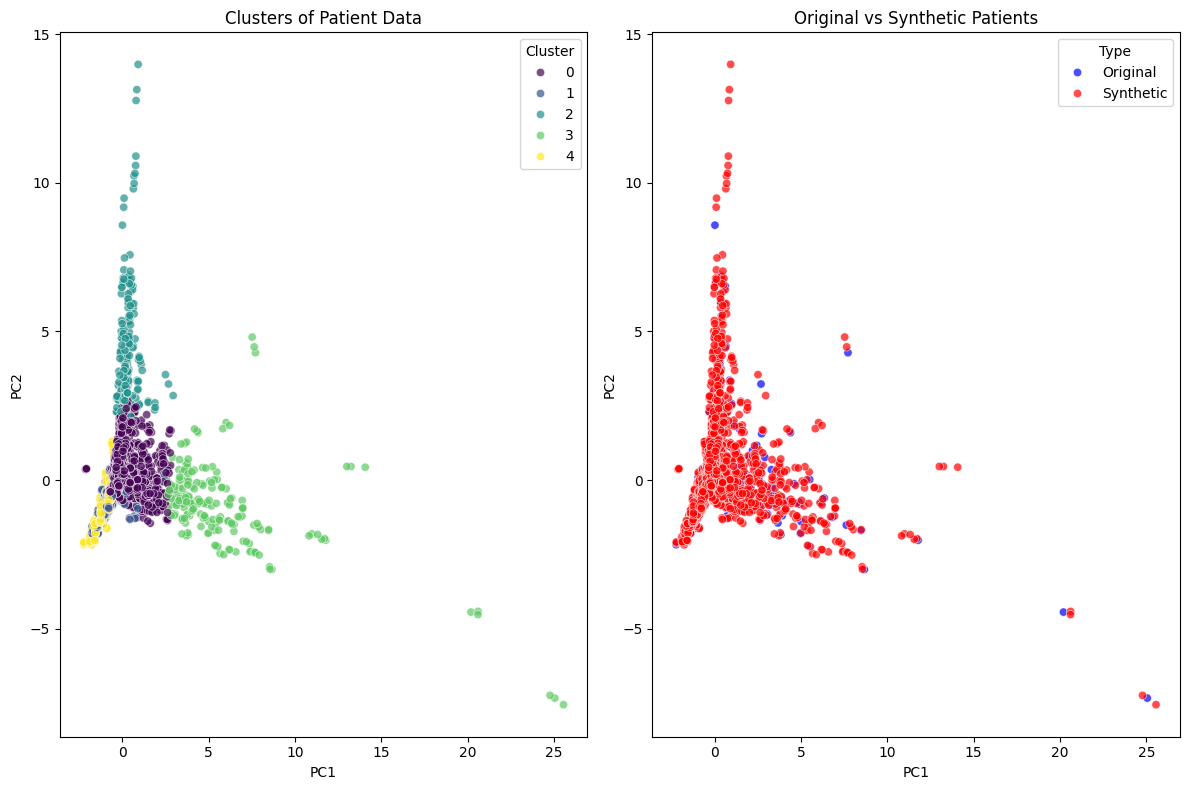

In [ ]:
# 5. Visualize the results
plt.figure(figsize=(12, 8))

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters,
    'Type': ['Synthetic' if is_syn else 'Original' for is_syn in digital_twin_data_adjusted['is_synthetic']]
})

# Plot by cluster
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='viridis', alpha=0.7)
plt.title('Clusters of Patient Data')

# Plot by original vs synthetic
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Type', data=plot_df, palette=['blue', 'red'], alpha=0.7)
plt.title('Original vs Synthetic Patients')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Thesis_Brainstorm/clustering_analysis_adjusted.png')
plt.show()

Running clustering analysis on original dataset...
Loading data from: /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/prostate_cancer_digital_twin_data_final.csv
Dataset has 3801 patients and 1558 features
Original patients: 642
Synthetic patients: 3159
Using 10 features for clustering: ['latest_psa', 'latest_alp', 'latest_creatinine', 'max_psa', 'max_alp', 'max_creatinine', 'psa_slope', 'num_timepoints', 'sequence_duration_days', 'anchor_age']
Variance explained by PC1: 0.30, PC2: 0.20
Total variance explained: 0.50


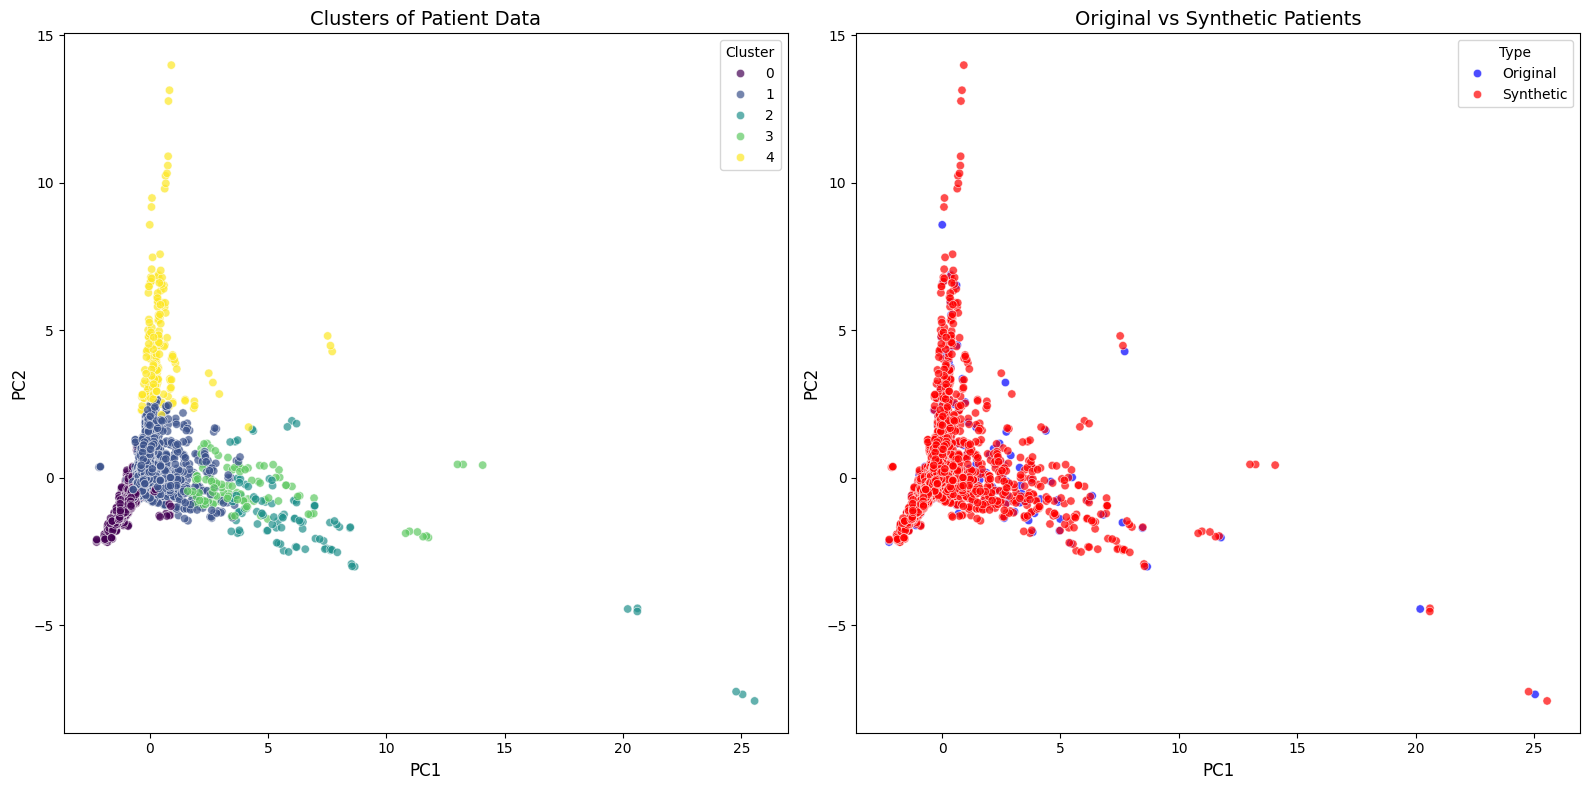


Cluster distribution (%):
Cluster            0          1         2         3         4
Type                                                         
Original   32.710280  57.009346  2.336449  3.582555  4.361371
Synthetic  32.130421  57.169991  2.627414  2.975625  5.096550

Feature distribution comparison (Original vs Synthetic):
latest_psa:
  Original: mean=149.39, std=713.57
  Synthetic: mean=129.40, std=575.42
  Difference: -13.38%
latest_alp:
  Original: mean=148.62, std=226.83
  Synthetic: mean=146.11, std=248.63
  Difference: -1.68%
latest_creatinine:
  Original: mean=1.37, std=1.09
  Synthetic: mean=1.40, std=1.25
  Difference: 2.30%
max_psa:
  Original: mean=185.02, std=750.02
  Synthetic: mean=187.79, std=708.79
  Difference: 1.50%
max_alp:
  Original: mean=205.10, std=369.91
  Synthetic: mean=204.22, std=356.17
  Difference: -0.43%
max_creatinine:
  Original: mean=1.88, std=1.64
  Synthetic: mean=1.98, std=1.96
  Difference: 5.16%
psa_slope:
  Original: mean=3.86, std=25.15


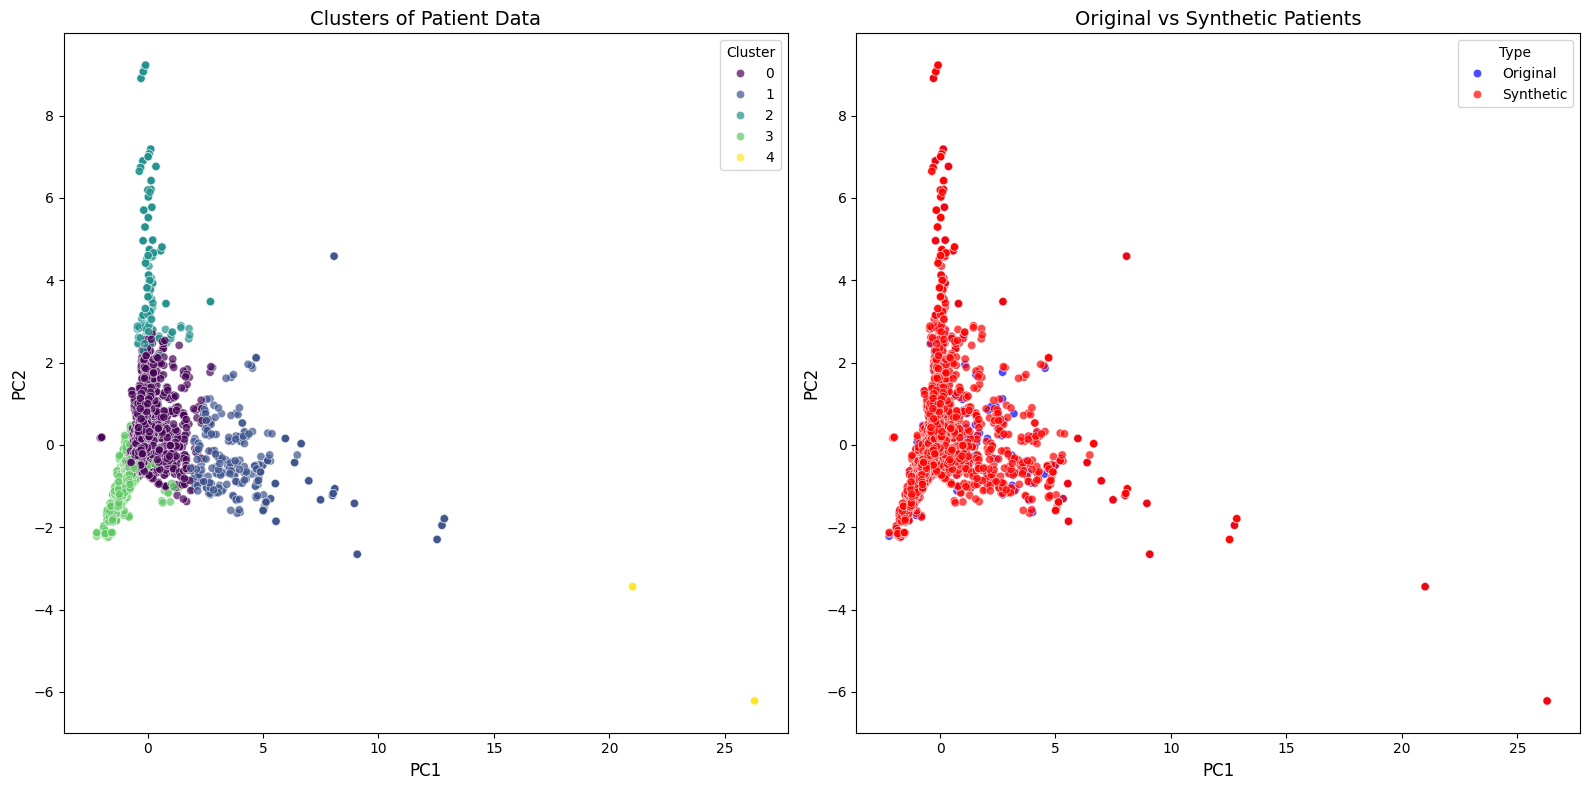


Cluster distribution (%):
Cluster            0         1         2          3         4
Type                                                         
Original   55.607477  7.009346  4.517134  32.554517  0.311526
Synthetic  55.745489  7.090852  5.159861  31.877176  0.126622

Feature distribution comparison (Original vs Synthetic):
latest_psa:
  Original: mean=149.39, std=713.57
  Synthetic: mean=127.88, std=558.33
  Difference: -14.40%
latest_alp:
  Original: mean=148.62, std=226.83
  Synthetic: mean=142.61, std=214.10
  Difference: -4.04%
latest_creatinine:
  Original: mean=1.37, std=1.09
  Synthetic: mean=1.40, std=1.24
  Difference: 2.19%
max_psa:
  Original: mean=185.02, std=750.02
  Synthetic: mean=184.73, std=680.76
  Difference: -0.16%
max_alp:
  Original: mean=205.10, std=369.91
  Synthetic: mean=199.57, std=322.72
  Difference: -2.70%
max_creatinine:
  Original: mean=1.88, std=1.64
  Synthetic: mean=1.96, std=1.81
  Difference: 4.17%
psa_slope:
  Original: mean=3.86, std=25.15

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def perform_clustering_analysis(data_path, output_path):
    """
    Perform clustering analysis and visualization to compare original vs synthetic data

    Args:
        data_path: Path to the digital twin dataset (CSV)
        output_path: Path to save the visualization and results
    """
    print("Loading data from:", data_path)
    digital_twin_data = pd.read_csv(data_path)

    print(f"Dataset has {len(digital_twin_data)} patients and {len(digital_twin_data.columns)} features")
    print(f"Original patients: {(digital_twin_data['is_synthetic'] == 0).sum()}")
    print(f"Synthetic patients: {(digital_twin_data['is_synthetic'] == 1).sum()}")

    # 1. Select features for clustering
    clustering_features = [
        'latest_psa', 'latest_alp', 'latest_creatinine',
        'max_psa', 'max_alp', 'max_creatinine',
        'psa_slope', 'num_timepoints', 'sequence_duration_days',
        'anchor_age'
    ]

    # Filter to keep only available features
    clustering_features = [f for f in clustering_features if f in digital_twin_data.columns]
    print(f"Using {len(clustering_features)} features for clustering: {clustering_features}")

    # 2. Preprocess the data
    X_cluster = digital_twin_data[clustering_features].copy()

    # Handle any missing values
    X_cluster = X_cluster.fillna(X_cluster.median())

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    # 3. Apply PCA for dimensionality reduction (for visualization)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Print variance explained by PCA components
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance explained by PC1: {explained_variance[0]:.2f}, PC2: {explained_variance[1]:.2f}")
    print(f"Total variance explained: {sum(explained_variance):.2f}")

    # 4. Perform clustering
    n_clusters = 5  # Try different values (4-6 often works well)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # 5. Visualize the results
    plt.figure(figsize=(16, 8))

    # Create a dataframe for plotting
    plot_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Cluster': clusters,
        'Type': ['Original' if is_syn == 0 else 'Synthetic' for is_syn in digital_twin_data['is_synthetic']]
    })

    # Plot by cluster
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=plot_df, palette='viridis', alpha=0.7)
    plt.title('Clusters of Patient Data', fontsize=14)
    plt.xlabel('PC1', fontsize=12)
    plt.ylabel('PC2', fontsize=12)

    # Plot by original vs synthetic
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='PC1', y='PC2', hue='Type', data=plot_df, palette=['blue', 'red'], alpha=0.7)
    plt.title('Original vs Synthetic Patients', fontsize=14)
    plt.xlabel('PC1', fontsize=12)
    plt.ylabel('PC2', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'{output_path}clustering_analysis.png', dpi=300)
    plt.show()

    # 6. Analyze cluster distribution
    cluster_distribution = pd.crosstab(
        plot_df['Type'],
        plot_df['Cluster'],
        normalize='index'
    ) * 100  # Convert to percentages

    print("\nCluster distribution (%):")
    print(cluster_distribution)

    # Save cluster distribution to CSV
    cluster_distribution.to_csv(f'{output_path}cluster_distribution.csv')

    # 7. Statistical comparison of feature distributions
    print("\nFeature distribution comparison (Original vs Synthetic):")
    feature_stats = []

    for feature in clustering_features:
        orig_mean = digital_twin_data[digital_twin_data['is_synthetic']==0][feature].mean()
        synth_mean = digital_twin_data[digital_twin_data['is_synthetic']==1][feature].mean()

        orig_std = digital_twin_data[digital_twin_data['is_synthetic']==0][feature].std()
        synth_std = digital_twin_data[digital_twin_data['is_synthetic']==1][feature].std()

        diff_pct = ((synth_mean-orig_mean)/orig_mean)*100 if orig_mean != 0 else 0

        print(f"{feature}:")
        print(f"  Original: mean={orig_mean:.2f}, std={orig_std:.2f}")
        print(f"  Synthetic: mean={synth_mean:.2f}, std={synth_std:.2f}")
        print(f"  Difference: {diff_pct:.2f}%")

        feature_stats.append({
            'Feature': feature,
            'Original_Mean': orig_mean,
            'Original_Std': orig_std,
            'Synthetic_Mean': synth_mean,
            'Synthetic_Std': synth_std,
            'Difference_Percent': diff_pct
        })

    # Save feature comparison to CSV
    pd.DataFrame(feature_stats).to_csv(f'{output_path}feature_comparison.csv', index=False)

    return {
        'cluster_distribution': cluster_distribution,
        'feature_stats': feature_stats,
        'explained_variance': explained_variance,
        'n_clusters': n_clusters
    }

# Run the clustering analysis on the adjusted dataset
# Make sure to create the output directory if it doesn't exist
import os
output_path = "/content/drive/MyDrive/Thesis_Brainstorm/clustering_results/"
os.makedirs(output_path, exist_ok=True)

# Run clustering analysis on the original and PCA-adjusted datasets
print("Running clustering analysis on original dataset...")
original_results = perform_clustering_analysis(
    "/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/prostate_cancer_digital_twin_data_final.csv",
    output_path + "original_"
)

print("\nRunning clustering analysis on PCA-adjusted dataset...")
adjusted_results = perform_clustering_analysis(
    "/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_pca_adjusted.csv",
    output_path + "adjusted_"
)

# Compare results from both analyses
print("\n==== COMPARING ORIGINAL VS ADJUSTED DATASETS ====")
print("\nCluster Distribution Comparison:")
print("Original Dataset:")
print(original_results['cluster_distribution'])
print("\nAdjusted Dataset:")
print(adjusted_results['cluster_distribution'])

# Calculate improvement in feature differences
print("\nImprovement in Feature Differences:")
orig_stats = pd.DataFrame(original_results['feature_stats'])
adj_stats = pd.DataFrame(adjusted_results['feature_stats'])

comparison = pd.DataFrame({
    'Feature': orig_stats['Feature'],
    'Original_Diff': orig_stats['Difference_Percent'],
    'Adjusted_Diff': adj_stats['Difference_Percent'],
    'Improvement': orig_stats['Difference_Percent'].abs() - adj_stats['Difference_Percent'].abs()
})

print(comparison.sort_values(by='Improvement', ascending=False))

In [20]:
digital_twin_data = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/prostate_cancer_digital_twin_data_final.csv')

In [21]:
# 1. Prepare the data

# Check what we have
print("Final dataset shape:", digital_twin_data.shape)
print("Columns:", digital_twin_data.columns.tolist())

# Check for missing values
missing_values = digital_twin_data.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])


Final dataset shape: (3801, 1558)
Columns: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'mortality', 'los_days', 'readmission_30d', 'num_timepoints', 'sequence_duration_days', 'latest_psa', 'latest_alp', 'latest_creatinine', 'max_psa', 'max_alp', 'max_creatinine', 'psa_slope', 'full_sequence_data', 'timestamps', 'discharge_emb_0', 'discharge_emb_1', 'discharge_emb_2', 'discharge_emb_3', 'discharge_emb_4', 'discharge_emb_5', 'discharge_emb_6', 'discharge_emb_7', 'discharge_emb_8', 'discharge_emb_9', 'discharge_emb_10', 'discharge_emb_11', 'discharge_emb_12', 'discharge_emb_13', 'discharge_emb_14', 'discharge_emb_15', 'discharge_emb_16', 'discharge_emb_17', 'discharge_emb_18', 'discharge_emb_19', 'discharge_emb_20', 'discharge_emb_21', 'discharge_emb_22', 'discharge_emb_23', 'discharge_emb_24', 'discharge_emb_25', 'discharge_emb_26', 'discharge_emb_27', 'discharge_emb_28', 'discharge_emb_29', 'discharge_emb_30', 'discharge_emb_31', 'discharge_emb_32',

In [22]:
from sklearn.model_selection import train_test_split


# Define target variables and features
target_cols = ['mortality', 'los_days', 'readmission_30d']
# Exclude targets, IDs and synthetic flag from features
exclude_cols = [col for col in target_cols if col in digital_twin_data.columns]

feature_cols = [col for col in digital_twin_data.columns if col not in exclude_cols]

#  Split the data into train/val/test sets (keeping track of original vs synthetic)
# Use stratified split based on mortality (most important outcome)
X = digital_twin_data[feature_cols]
y = digital_twin_data[target_cols]

# First split into train+val and test (80/20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=digital_twin_data['mortality']
)

# Then split train+val into train and validation (75/25 split of the 80% = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval['mortality']
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")



Train set: 2280 samples
Validation set: 760 samples
Test set: 761 samples


In [23]:
# 3. Handle missing values
# For embedding columns (use both naming conventions)
embedding_cols = [col for col in digital_twin_data.columns if 'emb_' in col or 'discharge_emb' in col or 'radiology_emb' in col or 'dischargeemb' in col or 'radiologyemb' in col]
digital_twin_data[embedding_cols] = digital_twin_data[embedding_cols].fillna(0)
print(f"Filled missing values with zeros for {len(embedding_cols)} embedding columns")

# For other numeric columns
numeric_cols = digital_twin_data.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
for col in numeric_cols:
    if digital_twin_data[col].isnull().sum() > 0:
        median_val = digital_twin_data[col].median()
        digital_twin_data[col] = digital_twin_data[col].fillna(median_val)
        print(f"Filled missing values in {col} with median: {median_val}")

# For date columns (like 'dod' - date of death)
date_cols = ['dod'] if 'dod' in digital_twin_data.columns else []
for col in date_cols:
    # For date of death, missing values likely mean the patient is still alive
    # We can either drop the column if it's not needed for features, or fill with a sentinel value
    if digital_twin_data[col].isnull().sum() > 0:
        print(f"Column {col} has {digital_twin_data[col].isnull().sum()} missing values")
        # Option 1: Drop the column if not needed for features
        if col not in ['subject_id', 'digital_twin_id'] and col not in target_cols:
            print(f"Dropping column {col} as it's not needed for features or targets")
            digital_twin_data = digital_twin_data.drop(columns=[col])
        # Option 2: Fill with a sentinel value if needed
        else:
            print(f"Filling {col} with a sentinel value")
            digital_twin_data[col] = digital_twin_data[col].fillna(-1)  # Use -1 as sentinel


Filled missing values with zeros for 1536 embedding columns
Column dod has 2484 missing values
Dropping column dod as it's not needed for features or targets


In [24]:
# Check for missing values
missing_values = digital_twin_data.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])


Missing values:
Series([], dtype: int64)


In [25]:
# Check class distribution in each split
print("\nMortality distribution:")
print(f"Train: {y_train['mortality'].mean():.4f}")
print(f"Validation: {y_val['mortality'].mean():.4f}")
print(f"Test: {y_test['mortality'].mean():.4f}")

print("\nReadmission distribution:")
print(f"Train: {y_train['readmission_30d'].mean():.4f}")
print(f"Validation: {y_val['readmission_30d'].mean():.4f}")
print(f"Test: {y_test['readmission_30d'].mean():.4f}")


Mortality distribution:
Train: 0.0039
Validation: 0.0039
Test: 0.0039

Readmission distribution:
Train: 0.1522
Validation: 0.1500
Test: 0.1551


In [15]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
# Complete implementation of ModifiedPCDataset
class ModifiedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Identify embedding columns
        self.discharge_cols = [col for col in X.columns if 'discharge_emb_' in col]
        self.radiology_cols = [col for col in X.columns if 'radiology_emb_' in col]

        print(f"Using {len(self.discharge_cols)} discharge columns and {len(self.radiology_cols)} radiology columns")

        # Get basic feature columns (excluding embedding columns and non-numeric columns)
        self.feature_cols = []
        for col in X.columns:
            if (col != 'subject_id' and
                'discharge_emb_' not in col and
                'radiology_emb_' not in col):
                # Check if column is numeric
                try:
                    # Try converting a sample to float
                    float(X[col].iloc[0])
                    self.feature_cols.append(col)
                except (ValueError, TypeError):
                    print(f"Skipping non-numeric column: {col}")

        print(f"Using {len(self.feature_cols)} numeric feature columns")

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Convert numeric features to numpy array
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]

            # Get available patient data
            patient_data = {'subject_id': patient_id}
            if 'anchor_age' in self.feature_cols:
                patient_data['anchor_age'] = self.X['anchor_age'].iloc[i]
            else:
                patient_data['anchor_age'] = 0  # Default value

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get discharge embeddings
        if self.discharge_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.discharge_cols]
                discharge_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert discharge embeddings for idx {idx}")
                discharge_emb = torch.zeros(len(self.discharge_cols), dtype=torch.float32)
        else:
            discharge_emb = torch.zeros(768, dtype=torch.float32)

        # Get radiology embeddings
        if self.radiology_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.radiology_cols]
                radiology_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert radiology embeddings for idx {idx}")
                radiology_emb = torch.zeros(len(self.radiology_cols), dtype=torch.float32)
        else:
            radiology_emb = torch.zeros(768, dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [26]:
#May 17th new version of ModifiedPCDataset
class ModifiedPCDataset(Dataset):
    """Dataset class for prostate cancer digital twin data"""
    def __init__(self, X, y, lab_data):
        self.X = X.reset_index(drop=True)  # Reset index to avoid indexing issues
        self.y = y.reset_index(drop=True)
        self.lab_data = lab_data

        # Identify embedding columns
        self.discharge_cols = [col for col in X.columns if 'discharge_emb' in col]
        self.radiology_cols = [col for col in X.columns if 'radiology_emb' in col]

        print(f"Using {len(self.discharge_cols)} discharge columns and {len(self.radiology_cols)} radiology columns")

        # Get basic feature columns (excluding embedding columns and non-numeric columns)
        self.feature_cols = []
        for col in X.columns:
            if (col not in ['subject_id', 'digital_twin_id', 'is_synthetic'] and
                'discharge_emb' not in col and 'radiology_emb' not in col):
                # Try converting a sample to float to check if it's numeric
                try:
                    # Test with the first value
                    sample = X[col].iloc[0]
                    if isinstance(sample, str) and any(c.isalpha() for c in sample):
                        # Skip if it contains alphabetic characters (likely a date or categorical)
                        print(f"Skipping non-numeric column: {col}")
                        continue

                    # Try converting to float
                    float(sample)
                    # If it works, add to feature columns
                    self.feature_cols.append(col)
                except (ValueError, TypeError):
                    print(f"Skipping non-numeric column: {col}")

        print(f"Using {len(self.feature_cols)} numeric feature columns")

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")

        # More robust conversion to numeric values
        structured_features_list = []
        for col in self.feature_cols:
            try:
                # Convert to float with explicit error handling
                col_values = pd.to_numeric(self.X[col], errors='coerce').fillna(0).values
                structured_features_list.append(col_values)
            except Exception as e:
                print(f"Error converting column {col}: {e}")
                # Use zeros as fallback
                structured_features_list.append(np.zeros(len(self.X)))

        # Stack horizontally to create feature matrix
        if structured_features_list:
            self.structured_features = np.column_stack(structured_features_list).astype(np.float32)
        else:
            # Fallback if no features could be converted
            self.structured_features = np.zeros((len(self.X), 1), dtype=np.float32)
            print("WARNING: No valid numeric features found, using zeros")

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get discharge embeddings
        if self.discharge_cols:
            discharge_emb = torch.tensor(self.X[self.discharge_cols].iloc[idx].values, dtype=torch.float32)
        else:
            discharge_emb = torch.zeros(768, dtype=torch.float32)

        # Get radiology embeddings
        if self.radiology_cols:
            radiology_emb = torch.tensor(self.X[self.radiology_cols].iloc[idx].values, dtype=torch.float32)
        else:
            radiology_emb = torch.zeros(768, dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [27]:
# Create datasets using ModifiedPCDataset
try:
    print("\nCreating datasets with ModifiedPCDataset...")
    train_dataset = ModifiedPCDataset(X_train, y_train, pc_relevant_labs)
    val_dataset = ModifiedPCDataset(X_val, y_val, pc_relevant_labs)
    test_dataset = ModifiedPCDataset(X_test, y_test, pc_relevant_labs)

    print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Check a sample item
    sample_item = train_dataset[0]
    for key, value in sample_item.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor of shape {value.shape}, dtype {value.dtype}")

except Exception as e:
    print(f"Error creating dataset: {e}")
    import traceback
    traceback.print_exc()


Creating datasets with ModifiedPCDataset...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: gender
Skipping non-numeric column: anchor_year_group
Skipping non-numeric column: dod
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Using 11 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: gender
Skipping non-numeric column: anchor_year_group
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Using 12 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: gender
Skipping non-numeric column: anchor_year_group
Skipping non-numeric column: dod
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Using 11 numeric feature columns
Engin

In [29]:
# Replace your ModifiedPCDataset class with the updated version

# Then create your datasets again
try:
    train_dataset = ModifiedPCDataset(X_train, y_train, pc_relevant_labs)
    val_dataset = ModifiedPCDataset(X_val, y_val, pc_relevant_labs)
    test_dataset = ModifiedPCDataset(X_test, y_test, pc_relevant_labs)
    print("Datasets created successfully!")

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Get structured dimension
    sample_batch = next(iter(train_loader))
    structured_dim = sample_batch['structured'].shape[1]
    print(f"Structured feature dimension: {structured_dim}")

except Exception as e:
    print(f"Error creating datasets: {e}")
    import traceback
    traceback.print_exc()

Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: gender
Skipping non-numeric column: anchor_year_group
Skipping non-numeric column: dod
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Using 11 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: gender
Skipping non-numeric column: anchor_year_group
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Using 12 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: gender
Skipping non-numeric column: anchor_year_group
Skipping non-numeric column: dod
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Using 11 numeric feature columns
Engineering features...
Processing time-series dat

In [28]:
# Create data loaders
from torch.utils.data import DataLoader

batch_size = 32  # Can use larger batch size with augmented data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created data loaders with batch size {batch_size}")

Created data loaders with batch size 32


In [29]:
# Get the dimension of structured features (needed for model initialization)
sample_batch = next(iter(train_loader))
structured_dim = sample_batch['structured'].shape[1]
print(f"Structured feature dimension: {structured_dim}")

Structured feature dimension: 11


In [ ]:
def train_moe_model_optimized(model, train_loader, val_loader, epochs=15, lr=0.001,
                            drive_save_path='/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/',
                            patience=5):
    """Optimized training with detailed progress tracking and memory management"""
    import os
    import numpy as np
    os.makedirs(drive_save_path, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Using Adam optimizer with learning rate: {lr}")

    # Loss for length of stay
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Track metrics
    train_losses = []
    val_losses = []
    training_history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'mortality_losses': [],
        'los_losses': [],
        'readmission_losses': [],
        'diversity_losses': [],
        'expert_usage': []
    }

    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_flag = False

    print(f"\nStarting training for {epochs} epochs (early stopping patience: {patience})...")
    print(f"Training on {len(train_loader.dataset)} samples, validating on {len(val_loader.dataset)} samples")

    print("----Starting epochs---")
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        mortality_losses = []
        los_losses = []
        readmission_losses = []
        diversity_losses = []
        batch_count = 0

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop with progress bar
        for batch_idx, batch in enumerate(train_loader):
            if batch_idx % 5 == 0:
                print(f"  Training batch {batch_idx+1}/{len(train_loader)}", end="\r")

            try:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred, expert_weights = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                l_loss = mse_loss(los_pred, labels[:, 1:2])
                r_loss = focal_loss(readmission_pred, labels[:, 2:3])

                # Track component losses
                mortality_losses.append(m_loss.item())
                los_losses.append(l_loss.item())
                readmission_losses.append(r_loss.item())

                # Expert diversity loss
                entropy = -(expert_weights * torch.log(expert_weights + 1e-7)).sum(dim=1).mean()
                d_loss = -0.1 * entropy  # Negative because we want to maximize entropy
                diversity_losses.append(d_loss.item())

                # Combined loss
                loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss + d_loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update metrics
                epoch_loss += loss.item()
                batch_count += 1

                # Free memory
                del structured, discharge_emb, radiology_emb, timeseries, labels
                del mortality_pred, los_pred, readmission_pred
                del m_loss, l_loss, r_loss, d_loss, loss
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()

        # Print batch completion
        print(f"  Completed {len(train_loader)}/{len(train_loader)} training batches")

        # Calculate average train loss
        train_loss = epoch_loss / batch_count if batch_count > 0 else float('inf')
        train_losses.append(train_loss)

        # Print detailed training metrics - exactly as you requested
        print(f"  Training stats - Loss: {train_loss:.4f}, " +
              f"Mortality: {np.mean(mortality_losses):.4f}, " +
              f"LOS: {np.mean(los_losses):.4f}, " +
              f"Readmission: {np.mean(readmission_losses):.4f}, " +
              f"Diversity: {np.mean(diversity_losses):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        val_mortality_losses = []
        val_los_losses = []
        val_readmission_losses = []
        expert_usage = np.zeros(len(model.experts))
        val_batch_count = 0

        print("  Validating...", end="\r")

        with torch.no_grad():
            for batch in val_loader:
                try:
                    # Move data to device
                    structured = batch['structured'].to(device)
                    discharge_emb = batch['discharge_emb'].to(device)
                    radiology_emb = batch['radiology_emb'].to(device)
                    timeseries = batch['timeseries'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    mortality_pred, los_pred, readmission_pred, expert_weights = model(
                        structured, discharge_emb, radiology_emb, timeseries
                    )

                    # Track expert usage
                    expert_usage += expert_weights.sum(dim=0).cpu().numpy()

                    # Calculate losses
                    m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                    l_loss = mse_loss(los_pred, labels[:, 1:2])
                    r_loss = focal_loss(readmission_pred, labels[:, 2:3])

                    # Track component losses
                    val_mortality_losses.append(m_loss.item())
                    val_los_losses.append(l_loss.item())
                    val_readmission_losses.append(r_loss.item())

                    # Combined loss
                    loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss

                    # Update metrics
                    val_loss += loss.item()
                    val_batch_count += 1

                    # Free memory
                    del structured, discharge_emb, radiology_emb, timeseries, labels
                    del mortality_pred, los_pred, readmission_pred
                    del m_loss, l_loss, r_loss, loss
                    torch.cuda.empty_cache()

                except Exception as e:
                    print(f"Error in validation batch: {e}")

        # Calculate average validation loss
        val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
        val_losses.append(val_loss)

        # Normalize expert usage
        expert_usage = expert_usage / len(val_loader.dataset) if val_batch_count > 0 else np.zeros(len(model.experts))

        # Print validation metrics - exactly as you requested
        print(f"  Validation stats - Loss: {val_loss:.4f}, " +
              f"Mortality: {np.mean(val_mortality_losses):.4f}, " +
              f"LOS: {np.mean(val_los_losses):.4f}, " +
              f"Readmission: {np.mean(val_readmission_losses):.4f}")

        # Print expert usage - exactly as you requested
        print(f"  Expert utilization: {expert_usage}")

        # Save training history
        training_history['epoch'].append(epoch + 1)
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['mortality_losses'].append(np.mean(mortality_losses))
        training_history['los_losses'].append(np.mean(los_losses))
        training_history['readmission_losses'].append(np.mean(readmission_losses))
        training_history['diversity_losses'].append(np.mean(diversity_losses))
        training_history['expert_usage'].append(expert_usage.tolist())

        # Save history to drive
        history_df = pd.DataFrame(training_history)
        history_df.to_csv(f"{drive_save_path}training_history.csv", index=False)

        # Update scheduler
        scheduler.step(val_loss)

        # Save model checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, f"{drive_save_path}model_checkpoint_epoch_{epoch+1}.pt")

        # Save best model and handle early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), f"{drive_save_path}digital_twin_moe_best.pt")
            print(f"  New best model saved with val_loss: {val_loss:.4f}")
        else:
            early_stopping_counter += 1
            print(f"  Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")

            if early_stopping_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                early_stopping_flag = True
                break

    # Load best model
    model.load_state_dict(torch.load(f"{drive_save_path}digital_twin_moe_best.pt"))

    if early_stopping_flag:
        print(f"\nTraining stopped early. Best validation loss: {best_val_loss:.4f}")
    else:
        print(f"\nTraining completed for all {epochs} epochs. Best validation loss: {best_val_loss:.4f}")

    return model, train_losses, val_losses, training_history

In [ ]:
def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal Loss for dealing with class imbalance

    Args:
        pred: Model predictions (sigmoid already applied)
        target: Ground truth labels
        alpha: Weighting factor for the rare class
        gamma: Focusing parameter that reduces the loss contribution from easy examples
    """
    # Binary cross entropy
    bce = -(target * torch.log(pred + 1e-7) + (1 - target) * torch.log(1 - pred + 1e-7))

    # Apply the focusing term
    pt = torch.where(target == 1, pred, 1 - pred)
    focal_weight = alpha * (1 - pt) ** gamma

    # Apply the weights and take the mean
    loss = focal_weight * bce
    return loss.mean()

In [ ]:
# Expert network definition
class ExpertNetwork(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, hidden_dim=64):
        super().__init__()
        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time series with LSTM
        self.ts_encoder = nn.LSTM(
            input_size=4,  # PSA, Testosterone, ALP, Creatinine
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Fusion layer
        self.fusion = nn.Linear(hidden_dim*4, hidden_dim)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Process time series
        _, (hidden, _) = self.ts_encoder(timeseries)
        ts_features = hidden.squeeze(0)

        # Combine features
        combined = torch.cat([
            structured_features,
            discharge_features,
            radiology_features,
            ts_features
        ], dim=1)

        return self.fusion(combined)

# Mixture of Experts model
class DigitalTwinMoE(nn.Module):
    def __init__(self, structured_dim, num_experts=4, embedding_dim=768, hidden_dim=64):
        super().__init__()

        # Create multiple expert networks
        self.experts = nn.ModuleList([
            ExpertNetwork(structured_dim, embedding_dim, hidden_dim)
            for _ in range(num_experts)
        ])

        # Gating network to determine expert weights
        self.gate = nn.Sequential(
            nn.Linear(structured_dim + embedding_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts),
            nn.Softmax(dim=1)
        )

        # Task-specific output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(hidden_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Determine expert weights using gate
        gate_input = torch.cat([structured, discharge_emb, radiology_emb], dim=1)
        expert_weights = self.gate(gate_input)

        # Get outputs from each expert
        expert_outputs = []
        for expert in self.experts:
            expert_out = expert(structured, discharge_emb, radiology_emb, timeseries)
            expert_outputs.append(expert_out.unsqueeze(1))

        # Stack expert outputs
        stacked_outputs = torch.cat(expert_outputs, dim=1)  # [batch, num_experts, hidden_dim]

        # Weighted sum of expert outputs
        weighted_output = torch.bmm(
            expert_weights.unsqueeze(1),  # [batch, 1, num_experts]
            stacked_outputs  # [batch, num_experts, hidden_dim]
        ).squeeze(1)  # [batch, hidden_dim]

        # Get predictions from task heads
        mortality = self.mortality_head(weighted_output)
        los = self.los_head(weighted_output)
        readmission = self.readmission_head(weighted_output)

        return mortality, los, readmission, expert_weights

In [33]:
def evaluate_moe_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []
    all_expert_weights = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred, expert_weights = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())
            all_expert_weights.extend(expert_weights.cpu().numpy())

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)
    all_expert_weights = np.array(all_expert_weights)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score

    # Handle potential issues with readmission AUC
    try:
        readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    except:
        readmission_auc = float('nan')

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    # Save results to a dictionary
    results = {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc,
        'expert_weights': all_expert_weights
    }

    # Print results
    print("\nModel Evaluation Results:")
    print(f"Mortality AUC: {mortality_auc:.4f}")
    print(f"Mortality Accuracy: {mortality_acc:.4f}")
    print(f"Length of Stay RMSE: {los_rmse:.4f}")
    if not np.isnan(readmission_auc):
        print(f"Readmission AUC: {readmission_auc:.4f}")
    print(f"Readmission Accuracy: {readmission_acc:.4f}")

    return results

In [ ]:
# 1. Initialize the model (if not already done)
moe_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)



In [ ]:
# 2. Train with Google Drive saving
save_path = '/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/'
trained_moe, train_losses, val_losses, history = train_moe_model_optimized(
    moe_model, train_loader, val_loader, epochs=20, drive_save_path=save_path
)



Using device: cuda
Using Adam optimizer with learning rate: 0.001

Starting training for 20 epochs (early stopping patience: 5)...
Training on 2280 samples, validating on 760 samples
----Starting epochs---

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Completed 72/72 training batches
  Training stats - Loss: 3.0476, Mortality: 0.0238, LOS: 950.0162, Readmission: 0.6269, Diversity: 0.0000
  Validation stats - Loss: 0.4011, Mortality: 0.0157, LOS: 70.9252, Readmission: 0.6069
  Expert utilization: [5.32402927e-24 1.00000000e+00 2.24321183e-14 3.72348474e-22]
  New best model saved with val_loss: 0.4011

Epoch 2/20
  Completed 72/72 training batches
  Training stats - Loss: 0.9537, Mortality: 0.0164, LOS: 259.0716, Readmission: 0.5664, Diversity: 0.0000
  Validation stats - Loss: 0.2530, Mortality: 0.0157, LOS: 46.3597, Readmission: 0.3586
  Expert utilization: [5.21567914e-24 1.00000000e+00 2.91347603e-14 3.68335669e-22]
  New best model saved with val_loss: 0.2530

Epoch 3/20
  Completed 72/72 training batches
  Training stats - Loss: 0.4395, Mortality: 0.0157, LOS: 94.7147, Readmission: 0.4968, Diversity: 0.0000
  Validation stats - Loss: 0.3733, Mortality: 0.0157, LOS: 76.9386, Readmission: 0.4540
  Expert utilization: [5.1077980

In [ ]:
# 3. Evaluate the model and save results
test_results = evaluate_moe_model(trained_moe, test_loader)
results_df = pd.DataFrame([test_results])
results_df.to_csv(f"{save_path}test_results.csv", index=False)

In [22]:
# 1. Load your model architecture
moe_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)



In [23]:
# 2. Load the best model (from epoch 9)
save_path = '/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model/'
moe_model.load_state_dict(torch.load(f"{save_path}digital_twin_moe_best.pt"))



<All keys matched successfully>

In [31]:
# 3. Create test data loader
test_loader = DataLoader(test_dataset, batch_size=32)



In [34]:
# 4. Evaluate the model
print("Evaluating best model from original training...")
test_results = evaluate_moe_model(moe_model, test_loader)
print(test_results)



Evaluating best model from original training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1547 and 1555x128)

In [35]:
#deubgging
# 1. Check the dimensions
print("Checking dimensions...")
print(f"Model's structured_dim: {structured_dim}")
print(f"Test data structured features shape: {next(iter(test_loader))['structured'].shape}")


Checking dimensions...
Model's structured_dim: 11
Test data structured features shape: torch.Size([32, 11])


In [36]:
# 1. Examine the model architecture in detail
print("Model architecture details:")
for name, param in moe_model.named_parameters():
    print(f"{name}: {param.shape}")


Model architecture details:
experts.0.structured_encoder.0.weight: torch.Size([64, 19])
experts.0.structured_encoder.0.bias: torch.Size([64])
experts.0.discharge_encoder.0.weight: torch.Size([64, 768])
experts.0.discharge_encoder.0.bias: torch.Size([64])
experts.0.radiology_encoder.0.weight: torch.Size([64, 768])
experts.0.radiology_encoder.0.bias: torch.Size([64])
experts.0.ts_encoder.weight_ih_l0: torch.Size([256, 4])
experts.0.ts_encoder.weight_hh_l0: torch.Size([256, 64])
experts.0.ts_encoder.bias_ih_l0: torch.Size([256])
experts.0.ts_encoder.bias_hh_l0: torch.Size([256])
experts.0.fusion.weight: torch.Size([64, 256])
experts.0.fusion.bias: torch.Size([64])
experts.1.structured_encoder.0.weight: torch.Size([64, 19])
experts.1.structured_encoder.0.bias: torch.Size([64])
experts.1.discharge_encoder.0.weight: torch.Size([64, 768])
experts.1.discharge_encoder.0.bias: torch.Size([64])
experts.1.radiology_encoder.0.weight: torch.Size([64, 768])
experts.1.radiology_encoder.0.bias: torch.S

In [37]:
# 1. Get the exact dimensions from the current data
sample_batch = next(iter(test_loader))
structured_dim = sample_batch['structured'].shape[1]  # 11
discharge_dim = sample_batch['discharge_emb'].shape[1]  # Should be 768
radiology_dim = sample_batch['radiology_emb'].shape[1]  # Should be 768

print(f"Current dimensions - Structured: {structured_dim}, Discharge: {discharge_dim}, Radiology: {radiology_dim}")
total_gate_input = structured_dim + discharge_dim + radiology_dim
print(f"Total gate input dimension: {total_gate_input}")

# 2. Create a new model with the correct dimensions
new_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)

# 3. Load the state dictionary of the original model
original_state_dict = torch.load(f"{save_path}digital_twin_moe_best.pt")

# 4. Create a new state dictionary, copying over compatible parameters
new_state_dict = new_model.state_dict()
for key in new_state_dict.keys():
    if key in original_state_dict:
        # Copy parameters that don't involve the mismatched dimensions
        if 'structured_encoder.0.weight' not in key and 'gate.0.weight' not in key:
            new_state_dict[key] = original_state_dict[key]
            print(f"Copied parameter: {key}")

# 5. Update the model with the new state dictionary
new_model.load_state_dict(new_state_dict, strict=False)
print("Transferred compatible parameters to new model")

# 6. Test the new model
print("\nTesting forward pass with new model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model = new_model.to(device)

with torch.no_grad():
    # Move batch to device
    test_batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v
                 for k, v in sample_batch.items()}

    try:
        mortality_pred, los_pred, readmission_pred, expert_weights = new_model(
            test_batch['structured'],
            test_batch['discharge_emb'],
            test_batch['radiology_emb'],
            test_batch['timeseries']
        )
        print("Forward pass successful!")
        print(f"Outputs - Mortality: {mortality_pred.shape}, LOS: {los_pred.shape}, " +
              f"Readmission: {readmission_pred.shape}, Expert weights: {expert_weights.shape}")

        # Now evaluate on the test set
        print("\nEvaluating new model on test set...")
        test_results = evaluate_moe_model(new_model, test_loader)
        print("Test Results:")
        for key, value in test_results.items():
            if key != 'expert_weights':
                print(f"{key}: {value}")
            else:
                print(f"{key}: {value.mean(axis=0)}")

        # Save the results
        # Convert numpy arrays to lists for JSON serialization
        test_results_save = {k: v.tolist() if isinstance(v, np.ndarray) else v
                            for k, v in test_results.items()}
        import json
        with open(f"{save_path}test_results_new_model.json", 'w') as f:
            json.dump(test_results_save, f)
        print(f"Results saved to {save_path}test_results_new_model.json")

    except Exception as e:
        print(f"Error in forward pass: {e}")
        import traceback
        traceback.print_exc()

Current dimensions - Structured: 11, Discharge: 768, Radiology: 768
Total gate input dimension: 1547
Copied parameter: experts.0.structured_encoder.0.bias
Copied parameter: experts.0.discharge_encoder.0.weight
Copied parameter: experts.0.discharge_encoder.0.bias
Copied parameter: experts.0.radiology_encoder.0.weight
Copied parameter: experts.0.radiology_encoder.0.bias
Copied parameter: experts.0.ts_encoder.weight_ih_l0
Copied parameter: experts.0.ts_encoder.weight_hh_l0
Copied parameter: experts.0.ts_encoder.bias_ih_l0
Copied parameter: experts.0.ts_encoder.bias_hh_l0
Copied parameter: experts.0.fusion.weight
Copied parameter: experts.0.fusion.bias
Copied parameter: experts.1.structured_encoder.0.bias
Copied parameter: experts.1.discharge_encoder.0.weight
Copied parameter: experts.1.discharge_encoder.0.bias
Copied parameter: experts.1.radiology_encoder.0.weight
Copied parameter: experts.1.radiology_encoder.0.bias
Copied parameter: experts.1.ts_encoder.weight_ih_l0
Copied parameter: exp

In [ ]:
# 5. Save the results
results_df = pd.DataFrame([test_results])
results_df.to_csv(f"{save_path}test_results_original.csv", index=False)

## Better MoE with diversity

## Old implementation of diversity improvement which failed 17th May

In [30]:
# 1. First ensure we have all necessary imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime





In [31]:
# 2. Define the focal loss function
def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal Loss for dealing with class imbalance

    Args:
        pred: Model predictions (sigmoid already applied)
        target: Ground truth labels
        alpha: Weighting factor for the rare class
        gamma: Focusing parameter that reduces the loss contribution from easy examples
    """
    # Binary cross entropy
    bce = -(target * torch.log(pred + 1e-7) + (1 - target) * torch.log(1 - pred + 1e-7))

    # Apply the focusing term
    pt = torch.where(target == 1, pred, 1 - pred)
    focal_weight = alpha * (1 - pt) ** gamma

    # Apply the weights and take the mean
    loss = focal_weight * bce
    return loss.mean()

In [32]:
# 3. Define the evaluate_moe_model function
def evaluate_moe_model(model, test_loader):
    """Evaluate the MoE model on test data"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []
    all_expert_weights = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            if batch_idx % 5 == 0:
                print(f"Evaluating batch {batch_idx+1}/{len(test_loader)}", end="\r")

            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            try:
                # Forward pass
                mortality_pred, los_pred, readmission_pred, expert_weights = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Collect predictions
                all_mortality_preds.extend(mortality_pred.cpu().numpy())
                all_los_preds.extend(los_pred.cpu().numpy())
                all_readmission_preds.extend(readmission_pred.cpu().numpy())
                all_true_labels.extend(batch['labels'].numpy())
                all_expert_weights.extend(expert_weights.cpu().numpy())

                # Free memory
                del structured, discharge_emb, radiology_emb, timeseries
                del mortality_pred, los_pred, readmission_pred, expert_weights
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error in evaluation batch {batch_idx}: {e}")
                continue

    print("\nEvaluation complete                  ")

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)
    all_expert_weights = np.array(all_expert_weights)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score

    # Handle potential issues with readmission AUC
    try:
        readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    except Exception as e:
        print(f"Could not calculate readmission AUC: {e}")
        readmission_auc = float('nan')

    # Mortality metrics
    try:
        mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    except Exception as e:
        print(f"Could not calculate mortality AUC: {e}")
        mortality_auc = float('nan')

    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    # Save results to a dictionary
    results = {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc,
        'expert_weights': all_expert_weights
    }

    # Print results
    print("\nModel Evaluation Results:")
    print(f"Mortality AUC: {mortality_auc:.4f}")
    print(f"Mortality Accuracy: {mortality_acc:.4f}")
    print(f"Length of Stay RMSE: {los_rmse:.4f}")
    if not np.isnan(readmission_auc):
        print(f"Readmission AUC: {readmission_auc:.4f}")
    print(f"Readmission Accuracy: {readmission_acc:.4f}")
    print(f"Expert utilization: {np.mean(all_expert_weights, axis=0)}")

    return results

In [33]:


# 4. Define the modified forward method for enhanced diversity
def modified_forward(self, structured, discharge_emb, radiology_emb, timeseries):
    """Modified forward method with expert dropout for diversity"""
    # Determine expert weights using gate
    gate_input = torch.cat([structured, discharge_emb, radiology_emb], dim=1)
    expert_weights = self.gate(gate_input)

    # Apply expert dropout during training to encourage diversity
    if self.training:
        # Add random dropout to expert weights (30% chance)
        dropout_mask = torch.rand_like(expert_weights) > 0.3
        # Ensure at least one expert is active
        zero_rows = (dropout_mask.sum(dim=1) == 0)
        dropout_mask[zero_rows, torch.randint(0, dropout_mask.size(1), (zero_rows.sum(),))] = True
        # Apply mask and renormalize
        expert_weights = expert_weights * dropout_mask.float()
        expert_weights = expert_weights / (expert_weights.sum(dim=1, keepdim=True) + 1e-7)

    # Rest of forward pass is the same
    expert_outputs = []
    for expert in self.experts:
        expert_out = expert(structured, discharge_emb, radiology_emb, timeseries)
        expert_outputs.append(expert_out.unsqueeze(1))

    stacked_outputs = torch.cat(expert_outputs, dim=1)
    weighted_output = torch.bmm(
        expert_weights.unsqueeze(1),
        stacked_outputs
    ).squeeze(1)

    mortality = self.mortality_head(weighted_output)
    los = self.los_head(weighted_output)
    readmission = self.readmission_head(weighted_output)

    return mortality, los, readmission, expert_weights

In [34]:


# 5. Define the robust training function with enhanced diversity
def train_with_enhanced_diversity_robust(model, train_loader, val_loader, epochs=20, lr=0.001, patience=5,
                                drive_save_path='/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/',
                                checkpoint_frequency=1):  # Save checkpoint every epoch by default
    """Training function with enhanced diversity loss, robust checkpointing, and frequent updates"""
    import os
    import numpy as np
    import time
    from datetime import datetime

    # Ensure separate save path from original model
    os.makedirs(drive_save_path, exist_ok=True)
    print(f"Model checkpoints and results will be saved to: {drive_save_path}")
    print(f"This is separate from your original model path.")

    # Create a session ID for this training run
    session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"Training session ID: {session_id}")

    # Try to save a copy of the notebook
    try:
        if 'google.colab' in str(get_ipython()):
            from google.colab import files
            from IPython.display import Javascript
            import json

            # Save the notebook content (if running in Colab)
            display(Javascript('google.colab.kernel.invokeFunction("notebook.save", [], {})'))
            time.sleep(1)  # Give it a moment to save

            # Note: We can't directly access the notebook filename in this context
            print("Notebook saved. You may want to manually copy it to your save directory.")
    except:
        print("Could not save notebook copy automatically.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Using Adam optimizer with learning rate: {lr}")

    # Loss for length of stay
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )

    # Track metrics
    train_losses = []
    val_losses = []
    training_history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'mortality_losses': [],
        'los_losses': [],
        'readmission_losses': [],
        'diversity_losses': [],
        'expert_usage': [],
        'time_per_epoch': [],
        'lr': []
    }

    # Resume from checkpoint if available
    start_epoch = 0
    best_val_loss = float('inf')
    early_stopping_counter = 0

    # Check for existing checkpoints
    import glob
    checkpoint_files = glob.glob(f"{drive_save_path}model_checkpoint_epoch_*.pt")
    if checkpoint_files:
        # Extract epoch numbers from filenames
        import re
        epoch_numbers = [int(re.search(r'epoch_(\d+)\.pt', file).group(1)) for file in checkpoint_files]
        latest_epoch = max(epoch_numbers)
        latest_checkpoint = f"{drive_save_path}model_checkpoint_epoch_{latest_epoch}.pt"

        print(f"Found existing checkpoint from epoch {latest_epoch}. Resuming training...")

        # Load the checkpoint
        checkpoint = torch.load(latest_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']

        # Also load training history if available
        history_file = f"{drive_save_path}training_history.csv"
        if os.path.exists(history_file):
            import pandas as pd
            history_df = pd.read_csv(history_file)

            # Convert DataFrame to dictionary
            for col in history_df.columns:
                if col in training_history:
                    training_history[col] = history_df[col].tolist()

            # Extract best validation loss
            if 'val_loss' in history_df.columns and not history_df['val_loss'].empty:
                best_val_loss = min(history_df['val_loss'])

            print(f"Loaded training history with {len(history_df)} epochs.")
            print(f"Best validation loss so far: {best_val_loss:.4f}")

            # Set train and val losses for plotting
            train_losses = history_df['train_loss'].tolist() if 'train_loss' in history_df.columns else []
            val_losses = history_df['val_loss'].tolist() if 'val_loss' in history_df.columns else []

    print(f"\nStarting training with enhanced diversity from epoch {start_epoch+1} to {epochs}")
    print(f"Early stopping patience: {patience} epochs")
    print(f"Training on {len(train_loader.dataset)} samples, validating on {len(val_loader.dataset)} samples")
    print(f"Checkpoint frequency: Every {checkpoint_frequency} epoch(s)")

    # Set up time tracking for Colab session estimation
    overall_start_time = time.time()

    for epoch in range(start_epoch, epochs):
        epoch_start_time = time.time()
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{epochs} - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'='*80}")

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")

        # Training
        model.train()
        epoch_loss = 0
        mortality_losses = []
        los_losses = []
        readmission_losses = []
        diversity_losses = []
        batch_times = []

        print("Training:")
        # Training loop with progress updates
        for batch_idx, batch in enumerate(train_loader):
            batch_start = time.time()

            # More frequent progress updates (every 5 batches or last batch)
            if batch_idx % 5 == 0 or batch_idx == len(train_loader) - 1:
                progress = (batch_idx + 1) / len(train_loader) * 100
                print(f"  Batch {batch_idx+1}/{len(train_loader)} ({progress:.1f}%)", end="\r")

            try:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred, expert_weights = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                l_loss = mse_loss(los_pred, labels[:, 1:2])
                r_loss = focal_loss(readmission_pred, labels[:, 2:3])
                mortality_losses.append(m_loss.item())
                los_losses.append(l_loss.item())
                readmission_losses.append(r_loss.item())

                # Enhanced diversity loss - 10x stronger
                entropy = -(expert_weights * torch.log(expert_weights + 1e-7)).sum(dim=1).mean()
                d_loss = -1.0 * entropy  # 10x stronger than before (-0.1 → -1.0)
                diversity_losses.append(d_loss.item())

                # Combined loss
                loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss + d_loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                # Track batch time for estimation
                batch_time = time.time() - batch_start
                batch_times.append(batch_time)

                # Free memory
                del structured, discharge_emb, radiology_emb, timeseries, labels
                del mortality_pred, los_pred, readmission_pred, expert_weights
                del m_loss, l_loss, r_loss, d_loss, loss
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"\nError in batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()

                # Continue with next batch instead of failing the entire epoch
                continue

        # Print batch completion and timing info
        avg_batch_time = sum(batch_times) / len(batch_times) if batch_times else 0
        print(f"\n  Completed training ({len(batch_times)}/{len(train_loader)} batches)")
        print(f"  Average batch time: {avg_batch_time:.3f}s")

        # Calculate average train loss
        train_loss = epoch_loss / len(batch_times) if batch_times else float('inf')
        train_losses.append(train_loss)

        # Print detailed training metrics
        print(f"  Training stats - Loss: {train_loss:.4f}, " +
              f"Mortality: {np.mean(mortality_losses):.4f}, " +
              f"LOS: {np.mean(los_losses):.4f}, " +
              f"Readmission: {np.mean(readmission_losses):.4f}, " +
              f"Diversity: {np.mean(diversity_losses):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        val_mortality_losses = []
        val_los_losses = []
        val_readmission_losses = []
        expert_usage = np.zeros(len(model.experts))
        val_batch_count = 0

        print("\nValidating:")
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                if batch_idx % 5 == 0 or batch_idx == len(val_loader) - 1:
                    progress = (batch_idx + 1) / len(val_loader) * 100
                    print(f"  Batch {batch_idx+1}/{len(val_loader)} ({progress:.1f}%)", end="\r")

                try:
                    # Move data to device
                    structured = batch['structured'].to(device)
                    discharge_emb = batch['discharge_emb'].to(device)
                    radiology_emb = batch['radiology_emb'].to(device)
                    timeseries = batch['timeseries'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    mortality_pred, los_pred, readmission_pred, expert_weights = model(
                        structured, discharge_emb, radiology_emb, timeseries
                    )

                    # Track expert usage
                    expert_usage += expert_weights.sum(dim=0).cpu().numpy()

                    # Calculate losses
                    m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                    l_loss = mse_loss(los_pred, labels[:, 1:2])
                    r_loss = focal_loss(readmission_pred, labels[:, 2:3])
                    val_mortality_losses.append(m_loss.item())
                    val_los_losses.append(l_loss.item())
                    val_readmission_losses.append(r_loss.item())

                    # Combined loss
                    loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss

                    val_loss += loss.item()
                    val_batch_count += 1

                    # Free memory
                    del structured, discharge_emb, radiology_emb, timeseries, labels
                    del mortality_pred, los_pred, readmission_pred, expert_weights
                    del m_loss, l_loss, r_loss, loss
                    torch.cuda.empty_cache()

                except Exception as e:
                    print(f"\nError in validation batch {batch_idx}: {e}")
                    continue

        # Print validation completion
        print("\n  Completed validation")

        # Calculate average validation loss
        val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
        val_losses.append(val_loss)

        # Normalize expert usage
        expert_usage = expert_usage / val_batch_count if val_batch_count > 0 else np.zeros(len(model.experts))

        # Print validation metrics
        print(f"  Validation stats - Loss: {val_loss:.4f}, " +
              f"Mortality: {np.mean(val_mortality_losses):.4f}, " +
              f"LOS: {np.mean(val_los_losses):.4f}, " +
              f"Readmission: {np.mean(val_readmission_losses):.4f}")

        # Print expert usage
        print(f"  Expert utilization: {expert_usage}")

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        print(f"  Epoch completed in {epoch_time:.1f}s")

        # Estimate time remaining
        epochs_remaining = epochs - (epoch + 1)
        time_per_epoch = (time.time() - overall_start_time) / (epoch - start_epoch + 1) if epoch > start_epoch else epoch_time
        estimated_time_remaining = time_per_epoch * epochs_remaining
        print(f"  Estimated time remaining: {estimated_time_remaining/60:.1f} minutes ({estimated_time_remaining/3600:.2f} hours)")

        # Save training history
        training_history['epoch'].append(epoch + 1)
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['mortality_losses'].append(np.mean(mortality_losses) if mortality_losses else 0)
        training_history['los_losses'].append(np.mean(los_losses) if los_losses else 0)
        training_history['readmission_losses'].append(np.mean(readmission_losses) if readmission_losses else 0)
        training_history['diversity_losses'].append(np.mean(diversity_losses) if diversity_losses else 0)
        training_history['expert_usage'].append(expert_usage.tolist())
        training_history['time_per_epoch'].append(epoch_time)
        training_history['lr'].append(current_lr)

        # Save history to drive immediately after each epoch
        import pandas as pd
        history_df = pd.DataFrame(training_history)
        history_df.to_csv(f"{drive_save_path}training_history.csv", index=False)
        print(f"  Training history saved to {drive_save_path}training_history.csv")

        # Update scheduler
        scheduler.step(val_loss)

        # Save model checkpoint (based on frequency)
        if (epoch + 1) % checkpoint_frequency == 0 or (epoch + 1) == epochs:
            checkpoint_path = f"{drive_save_path}model_checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'expert_usage': expert_usage.tolist()
            }, checkpoint_path)
            print(f"  Checkpoint saved to {checkpoint_path}")

        # Save best model and handle early stopping
        if val_loss < best_val_loss:
            improvement = (best_val_loss - val_loss) / best_val_loss * 100
            best_val_loss = val_loss
            early_stopping_counter = 0

            # Save best model
            best_model_path = f"{drive_save_path}digital_twin_moe_diverse_best.pt"
            torch.save(model.state_dict(), best_model_path)
            print(f"  New best model saved with val_loss: {val_loss:.4f} ({improvement:.2f}% improvement)")

            # Create a named copy for this specific best model version
            best_copy_path = f"{drive_save_path}digital_twin_moe_diverse_best_epoch_{epoch+1}.pt"
            import shutil
            shutil.copy(best_model_path, best_copy_path)
        else:
            early_stopping_counter += 1
            print(f"  Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")

            if early_stopping_counter >= patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                # Save a final checkpoint before stopping
                final_checkpoint_path = f"{drive_save_path}model_checkpoint_final_early_stopped.pt"
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'early_stopped': True
                }, final_checkpoint_path)
                print(f"  Final checkpoint saved to {final_checkpoint_path}")
                break

        # Plot and save progress after each epoch
        try:
            import matplotlib.pyplot as plt

            # Create a figure with multiple subplots
            plt.figure(figsize=(15, 10))

            # Plot 1: Loss curves
            plt.subplot(2, 2, 1)
            epochs_range = list(range(1, len(train_losses) + 1))
            plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
            plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Plot 2: Expert utilization over time
            plt.subplot(2, 2, 2)
            expert_usage_history = np.array(training_history['expert_usage'])
            for i in range(len(model.experts)):
                plt.plot(epochs_range, expert_usage_history[:, i], label=f'Expert {i}')
            plt.title('Expert Utilization Over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Usage Proportion')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Plot 3: Component losses
            plt.subplot(2, 2, 3)
            if mortality_losses:
                plt.plot(epochs_range, training_history['mortality_losses'], label='Mortality')
                plt.plot(epochs_range, training_history['los_losses'], label='LOS')
                plt.plot(epochs_range, training_history['readmission_losses'], label='Readmission')
                plt.title('Task Losses Over Time')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True, alpha=0.3)

            # Plot 4: Learning rate
            plt.subplot(2, 2, 4)
            plt.plot(epochs_range, training_history['lr'])
            plt.title('Learning Rate Over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(f"{drive_save_path}training_progress.png")
            plt.close()
            print(f"  Training progress plots saved to {drive_save_path}training_progress.png")

        except Exception as e:
            print(f"  Could not create plots: {e}")

    # After training completes (either naturally or via early stopping)
    total_training_time = time.time() - overall_start_time
    print(f"\nTotal training time: {total_training_time/60:.2f} minutes ({total_training_time/3600:.2f} hours)")

    # Load best model
    try:
        best_model_path = f"{drive_save_path}digital_twin_moe_diverse_best.pt"
        model.load_state_dict(torch.load(best_model_path))
        print(f"Loaded best model from {best_model_path} with validation loss: {best_val_loss:.4f}")
    except Exception as e:
        print(f"Error loading best model: {e}. Using final model state instead.")

    # Return results
    return model, train_losses, val_losses, training_history



In [36]:
# Define the Expert Network class
class ExpertNetwork(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, hidden_dim=64):
        super().__init__()
        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time series with LSTM
        self.ts_encoder = nn.LSTM(
            input_size=4,  # PSA, Testosterone, ALP, Creatinine
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Fusion layer
        self.fusion = nn.Linear(hidden_dim*4, hidden_dim)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Process time series
        _, (hidden, _) = self.ts_encoder(timeseries)
        ts_features = hidden.squeeze(0)

        # Combine features
        combined = torch.cat([
            structured_features,
            discharge_features,
            radiology_features,
            ts_features
        ], dim=1)

        return self.fusion(combined)

# Define the Mixture of Experts model
class DigitalTwinMoE(nn.Module):
    def __init__(self, structured_dim, num_experts=4, embedding_dim=768, hidden_dim=64):
        super().__init__()

        # Create multiple expert networks
        self.experts = nn.ModuleList([
            ExpertNetwork(structured_dim, embedding_dim, hidden_dim)
            for _ in range(num_experts)
        ])

        # Gating network to determine expert weights
        self.gate = nn.Sequential(
            nn.Linear(structured_dim + embedding_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts),
            nn.Softmax(dim=1)
        )

        # Task-specific output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(hidden_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Determine expert weights using gate
        gate_input = torch.cat([structured, discharge_emb, radiology_emb], dim=1)
        expert_weights = self.gate(gate_input)

        # Get outputs from each expert
        expert_outputs = []
        for expert in self.experts:
            expert_out = expert(structured, discharge_emb, radiology_emb, timeseries)
            expert_outputs.append(expert_out.unsqueeze(1))

        # Stack expert outputs
        stacked_outputs = torch.cat(expert_outputs, dim=1)  # [batch, num_experts, hidden_dim]

        # Weighted sum of expert outputs
        weighted_output = torch.bmm(
            expert_weights.unsqueeze(1),  # [batch, 1, num_experts]
            stacked_outputs  # [batch, num_experts, hidden_dim]
        ).squeeze(1)  # [batch, hidden_dim]

        # Get predictions from task heads
        mortality = self.mortality_head(weighted_output)
        los = self.los_head(weighted_output)
        readmission = self.readmission_head(weighted_output)

        return mortality, los, readmission, expert_weights

In [37]:
# 6. Now create and train the diverse model
# Create a new model with the current dimensions
print("Creating diverse model...")
diverse_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)

# Patch the forward method with the modified version
import types
diverse_model.forward = types.MethodType(modified_forward, diverse_model)

# Save path is completely separate from original model
save_path_diverse = '/content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/'

# Train the diverse model with robust implementation
print("Starting diverse model training...")
diverse_moe, diverse_train_losses, diverse_val_losses, diverse_history = train_with_enhanced_diversity_robust(
    diverse_model,
    train_loader,
    val_loader,
    epochs=15,
    patience=5,
    checkpoint_frequency=1,  # Save after every epoch for robustness
    drive_save_path=save_path_diverse
)

# Evaluate the diverse model
test_loader = DataLoader(test_dataset, batch_size=32)
print("\nEvaluating diverse model on test set...")
diverse_results = evaluate_moe_model(diverse_moe, test_loader)

# Save results in multiple formats for safety
# JSON format
diverse_results_save = {k: v.tolist() if isinstance(v, np.ndarray) else v
                      for k, v in diverse_results.items()}
import json
with open(f"{save_path_diverse}test_results_diverse.json", 'w') as f:
    json.dump(diverse_results_save, f)

# Also save as CSV for easier viewing
import pandas as pd
results_df = pd.DataFrame([{k: v if k != 'expert_weights' else str(v.mean(axis=0))
                         for k, v in diverse_results.items()}])
results_df.to_csv(f"{save_path_diverse}test_results_diverse.csv", index=False)

print(f"Results saved to {save_path_diverse}")
print("Diverse model training and evaluation complete!")

Creating diverse model...
Starting diverse model training...
Model checkpoints and results will be saved to: /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/
This is separate from your original model path.
Training session ID: 20250518_052137


<IPython.core.display.Javascript object>

Notebook saved. You may want to manually copy it to your save directory.
Using device: cuda
Using Adam optimizer with learning rate: 0.001

Starting training with enhanced diversity from epoch 1 to 15
Early stopping patience: 5 epochs
Training on 2280 samples, validating on 760 samples
Checkpoint frequency: Every 1 epoch(s)

Epoch 1/15 - 2025-05-18 05:21:43
Current learning rate: 0.001
Training:


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Batch 72/72 (100.0%)
  Completed training (72/72 batches)
  Average batch time: 0.032s
  Training stats - Loss: 1.4763, Mortality: 0.0850, LOS: 430.5559, Readmission: 0.5166, Diversity: -0.0044

Validating:

Error in validation batch 0: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 1: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 2: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 3: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 4: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)
  Batch 6/24 (25.0%)
Error in validation batch 5: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 6: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 7: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in v

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Training progress plots saved to /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/training_progress.png

Epoch 2/15 - 2025-05-18 05:21:58
Current learning rate: 0.001
Training:
  Batch 72/72 (100.0%)
  Completed training (72/72 batches)
  Average batch time: 0.015s
  Training stats - Loss: 0.3152, Mortality: 0.0208, LOS: 58.0868, Readmission: 0.4426, Diversity: -0.0002

Validating:
  Batch 1/24 (4.2%)
Error in validation batch 0: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 1: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 2: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 3: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 4: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)
  Batch 6/24 (25.0%)
Error in validation batch 5: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Training progress plots saved to /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/training_progress.png

Epoch 3/15 - 2025-05-18 05:22:12
Current learning rate: 0.001
Training:
  Batch 72/72 (100.0%)
  Completed training (72/72 batches)
  Average batch time: 0.015s
  Training stats - Loss: 0.3251, Mortality: 0.0236, LOS: 61.6964, Readmission: 0.4353, Diversity: 0.0000

Validating:
  Batch 1/24 (4.2%)
Error in validation batch 0: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 1: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 2: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 3: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 4: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)
  Batch 6/24 (25.0%)
Error in validation batch 5: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Training progress plots saved to /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/training_progress.png

Epoch 4/15 - 2025-05-18 05:22:25
Current learning rate: 0.001
Training:
  Batch 72/72 (100.0%)
  Completed training (72/72 batches)
  Average batch time: 0.015s
  Training stats - Loss: 0.4328, Mortality: 0.0228, LOS: 99.6410, Readmission: 0.4158, Diversity: 0.0000

Validating:
  Batch 1/24 (4.2%)
Error in validation batch 0: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 1: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 2: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 3: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 4: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)
  Batch 6/24 (25.0%)
Error in validation batch 5: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Training progress plots saved to /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/training_progress.png

Epoch 5/15 - 2025-05-18 05:22:39
Current learning rate: 0.0005
Training:
  Batch 72/72 (100.0%)
  Completed training (72/72 batches)
  Average batch time: 0.015s
  Training stats - Loss: 0.4930, Mortality: 0.0202, LOS: 116.0167, Readmission: 0.4563, Diversity: 0.0000

Validating:
  Batch 1/24 (4.2%)
Error in validation batch 0: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 1: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 2: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 3: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)

Error in validation batch 4: mat1 and mat2 shapes cannot be multiplied (32x1548 and 1547x128)
  Batch 6/24 (25.0%)
Error in validation batch 5: mat1 and mat2 shapes cannot be multiplied (32x1548 and 154

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Evaluation complete                  

Model Evaluation Results:
Mortality AUC: 0.5000
Mortality Accuracy: 0.9961
Length of Stay RMSE: 8.6028
Readmission AUC: 0.5000
Readmission Accuracy: 0.8449
Expert utilization: [0. 0. 0. 1.]
Results saved to /content/drive/MyDrive/Thesis_Brainstorm/MoE_Model_Diverse/
Diverse model training and evaluation complete!


In [39]:
# Add to train_moe_model_optimized
print(f"Training input shape: {structured_dim.shape}")

# Add to validation section
print(f"Validation input shape: {structured_sim.shape}")

AttributeError: 'int' object has no attribute 'shape'

In [47]:
# Get the dimensions from a sample batch
sample_batch = next(iter(train_loader))
structured = sample_batch['structured']
discharge_emb = sample_batch['discharge_emb']
radiology_emb = sample_batch['radiology_emb']
timeseries = sample_batch['timeseries']

# Print all dimensions
print(f"Structured features shape: {structured.shape}")
print(f"Discharge embedding shape: {discharge_emb.shape}")
print(f"Radiology embedding shape: {radiology_emb.shape}")
print(f"Timeseries shape: {timeseries.shape}")

# Check your model's expected dimensions
print(f"Model's structured_dim parameter: {structured_dim}")
print(f"Combined gate input dimension should be: {structured_dim + discharge_emb.shape[1]*2}")

# Check the first layer of each part of the model
print("\nModel layer dimensions:")
for name, param in model.named_parameters():
    if 'weight' in name and '.0.weight' in name:  # First layer weights
        print(f"{name}: {param.shape}")

Structured features shape: torch.Size([32, 11])
Discharge embedding shape: torch.Size([32, 768])
Radiology embedding shape: torch.Size([32, 768])
Timeseries shape: torch.Size([32, 20, 4])
Model's structured_dim parameter: 11
Combined gate input dimension should be: 1547

Model layer dimensions:


NameError: name 'model' is not defined

In [45]:
# Get correct dimensions from data
sample_batch = next(iter(train_loader))
actual_structured_dim = sample_batch['structured'].shape[1]

# Create model with correct dimension
moe_model = DigitalTwinMoE(structured_dim=actual_structured_dim, num_experts=4)

In [46]:
# Create a fresh model with the correct dimensions
new_model = DigitalTwinMoE(structured_dim=structured.shape[1], num_experts=4)

In [48]:
# Create the model with the dimensions we know
moe_model = DigitalTwinMoE(structured_dim=11, num_experts=4)

# Now check the parameters
print("\nModel layer dimensions:")
for name, param in moe_model.named_parameters():
    if 'weight' in name and '.0.weight' in name:  # First layer weights
        print(f"{name}: {param.shape}")
    elif 'gate.0.weight' in name:  # Gate network is especially important
        print(f"{name}: {param.shape}")


Model layer dimensions:
experts.0.structured_encoder.0.weight: torch.Size([64, 11])
experts.0.discharge_encoder.0.weight: torch.Size([64, 768])
experts.0.radiology_encoder.0.weight: torch.Size([64, 768])
experts.1.structured_encoder.0.weight: torch.Size([64, 11])
experts.1.discharge_encoder.0.weight: torch.Size([64, 768])
experts.1.radiology_encoder.0.weight: torch.Size([64, 768])
experts.2.structured_encoder.0.weight: torch.Size([64, 11])
experts.2.discharge_encoder.0.weight: torch.Size([64, 768])
experts.2.radiology_encoder.0.weight: torch.Size([64, 768])
experts.3.structured_encoder.0.weight: torch.Size([64, 11])
experts.3.discharge_encoder.0.weight: torch.Size([64, 768])
experts.3.radiology_encoder.0.weight: torch.Size([64, 768])
gate.0.weight: torch.Size([128, 1547])
mortality_head.0.weight: torch.Size([1, 64])
readmission_head.0.weight: torch.Size([1, 64])


In [49]:
# In your train_moe_model_optimized function
# In the validation loop, add this:
for batch in val_loader:
    # Move data to device
    structured = batch['structured'].to(device)
    discharge_emb = batch['discharge_emb'].to(device)
    radiology_emb = batch['radiology_emb'].to(device)
    timeseries = batch['timeseries'].to(device)

    print(f"Validation batch: structured {structured.shape}, discharge {discharge_emb.shape}, radiology {radiology_emb.shape}")

    # Calculate combined dimension for debugging
    combined_dim = structured.shape[1] + discharge_emb.shape[1] + radiology_emb.shape[1]
    print(f"Combined dimension: {combined_dim}")

    try:
        # Forward pass
        mortality_pred, los_pred, readmission_pred, expert_weights = model(
            structured, discharge_emb, radiology_emb, timeseries
        )
    except Exception as e:
        print(f"Error in validation: {e}")
        print(f"Input dimensions: structured {structured.shape}, discharge {discharge_emb.shape}, radiology {radiology_emb.shape}")
        # Additional debug info
        combined = torch.cat([structured, discharge_emb, radiology_emb], dim=1)
        print(f"Combined tensor shape: {combined.shape}")
        break

NameError: name 'device' is not defined

In [50]:
# Get the actual dimensions from validation data
val_batch = next(iter(val_loader))
val_structured = val_batch['structured']
val_discharge = val_batch['discharge_emb']
val_radiology = val_batch['radiology_emb']

# Calculate actual dimensions
actual_structured_dim = val_structured.shape[1]
actual_combined_dim = actual_structured_dim + val_discharge.shape[1] + val_radiology.shape[1]

print(f"Validation structured dim: {actual_structured_dim}")
print(f"Validation combined dim: {actual_combined_dim}")

# Create new model with these dimensions
new_model = DigitalTwinMoE(structured_dim=actual_structured_dim, num_experts=4)

Validation structured dim: 12
Validation combined dim: 1548



Example for patient 10014610:
Sequence shape: (20, 3)
First few timestamps: ['2176-01-27 17:04:00', '2176-02-23 14:42:00', '2176-05-11 11:25:00']
Feature names: ['Test_50974', 'Test_50863', 'Test_50912']


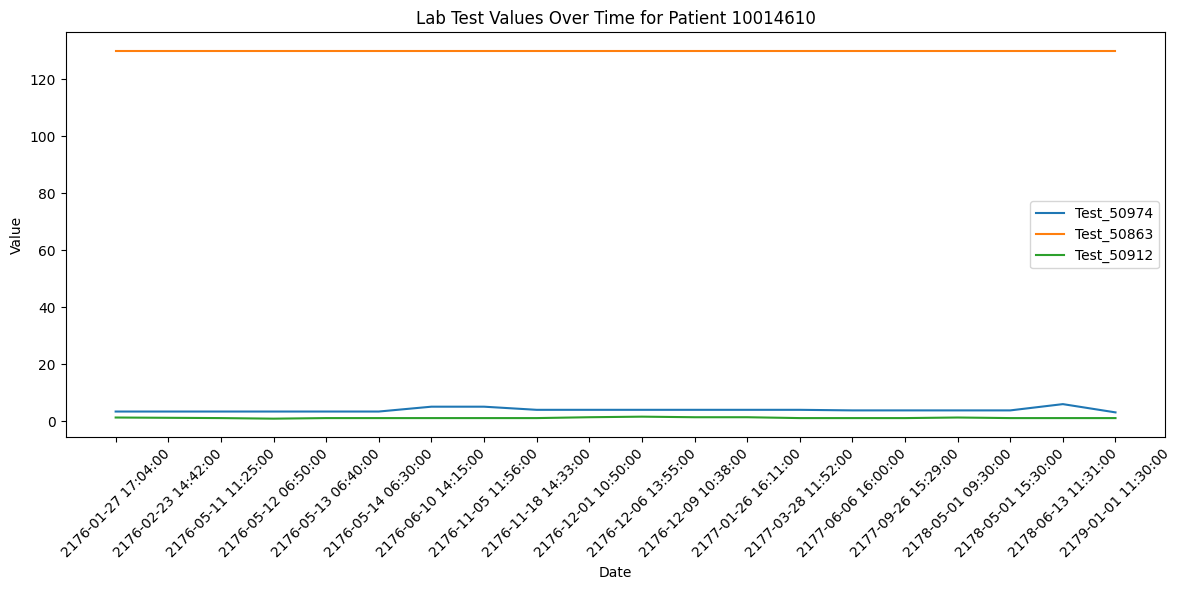

In [ ]:
# Example of how the data looks for one patient
if len(patient_sequences) > 0:
    example_patient = list(patient_sequences.keys())[1]
    example_sequence = patient_sequences[example_patient]

    print(f"\nExample for patient {example_patient}:")
    print(f"Sequence shape: {example_sequence['sequences'].shape}")
    print(f"First few timestamps: {example_sequence['timestamps'][:3]}")
    print(f"Feature names: {example_sequence['feature_names']}")

    # Plot the sequences for this patient
    plt.figure(figsize=(12, 6))
    for i, feature_name in enumerate(example_sequence['feature_names']):
        plt.plot(example_sequence['timestamps'],
                 example_sequence['sequences'][:, i],
                 label=feature_name)

    plt.title(f"Lab Test Values Over Time for Patient {example_patient}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Convert to DataFrame
sequence_df = pd.DataFrame(sequence_features)

In [ ]:
sequence_df.head()

subject_id  num_timepoints  sequence_duration_days  latest_psa  latest_alp  \
0   10006716              20              528.099306        0.16       104.0   
1   10014610              20             1069.768056        3.10       130.0   
2   10024331              20              197.913194        0.10        89.0   
3   10046298              20             1412.920139        6.10        27.0   
4   10048001              20                5.414583        0.50       297.0   

   latest_creatinine  max_psa  max_alp  max_creatinine     psa_slope  \
0                0.8     0.16    142.0             1.0  4.285714e-04   
1                1.1     6.00    130.0             1.6  3.345865e-02   
2                0.9     0.10    107.0             1.4 -2.402778e-18   
3                1.1     6.10     47.0             1.3  3.827068e-02   
4                3.0     0.50    297.0             6.1 -1.251623e-17   

                                  full_sequence_data  \
0  [[0.11, 59.0, 0.9], [0.11, 59.0, 1.0], [0.11, ...   
1  [[3.4, 130.0, 1.3], [3.4, 130.0, 1.2], [3.4, 1...   
2  [[0.1, 107.0, 1.4], [0.1, 107.0, 1.4], [0.1, 1...   
3  [[3.8, 35.0, 1.2], [3.6, 35.0, 1.2], [6.0, 31....   
4  [[0.5, 159.0, 3.9], [0.5, 158.0, 4.6], [0.5, 1...   

                                          timestamps  
0  [2191-11-06 11:00:00, 2191-11-07 08:58:00, 219...  
1  [2176-01-27 17:04:00, 2176-02-23 14:42:00, 217...  
2  [2144-02-27 09:20:00, 2144-02-28 06:20:00, 214...  
3  [2193-03-28 15:55:00, 2193-10-23 14:06:00, 219...  
4  [2184-06-22 18:50:00, 2184-06-23 02:44:00, 218...

In [ ]:
sequence_df

subject_id  num_timepoints  sequence_duration_days  latest_psa  \
0          10006716              20              528.099306    0.160000   
1          10014610              20             1069.768056    3.100000   
2          10024331              20              197.913194    0.100000   
3          10046298              20             1412.920139    6.100000   
4          10048001              20                5.414583    0.500000   
...             ...             ...                     ...         ...   
3796  19952477_aug2              10              650.840278    0.098281   
3797  19963970_aug1              20             1311.914583    0.389662   
3798  19963970_aug2              20             1311.914583    0.435554   
3799  19974907_aug1              19             1287.906944    0.000000   
3800  19974907_aug2              19             1287.906944    0.000000   

      latest_alp  latest_creatinine    max_psa     max_alp  max_creatinine  \
0     104.000000           0.800000   0.160000  142.000000        1.000000   
1     130.000000           1.100000   6.000000  130.000000        1.600000   
2      89.000000           0.900000   0.100000  107.000000        1.400000   
3      27.000000           1.100000   6.100000   47.000000        1.300000   
4     297.000000           3.000000   0.500000  297.000000        6.100000   
...          ...                ...        ...         ...             ...   
3796   96.512481           0.860824  10.600522  111.297040        0.931925   
3797   62.448516           1.432035  13.201274   74.478770       15.617355   
3798   64.351110           1.254708  13.141986   79.666101       14.985198   
3799   55.648747           1.190585  15.359724   73.874927        1.357299   
3800   54.599842           1.105085  15.959494   68.634374        1.302565   

         psa_slope                                 full_sequence_data  \
0     4.285714e-04  [[0.11, 59.0, 0.9], [0.11, 59.0, 1.0], [0.11, ...   
1     3.345865e-02  [[3.4, 130.0, 1.3], [3.4, 130.0, 1.2], [3.4, 1...   
2    -2.402778e-18  [[0.1, 107.0, 1.4], [0.1, 107.0, 1.4], [0.1, 1...   
3     3.827068e-02  [[3.8, 35.0, 1.2], [3.6, 35.0, 1.2], [6.0, 31....   
4    -1.251623e-17  [[0.5, 159.0, 3.9], [0.5, 158.0, 4.6], [0.5, 1...   
...            ...                                                ...   
3796 -1.351366e+00  [[10.600522139609469, 0.0, 0.0], [10.190845652...   
3797 -5.623695e-01  [[8.369057748093585, 69.91452906663729, 0.9939...   
3798 -5.829644e-01  [[9.649024007561945, 63.68771128100247, 1.0984...   
3799 -6.460958e-01  [[0.0, 0.0, 1.2949800027538403], [15.359724469...   
3800 -6.307052e-01  [[0.0, 0.0, 1.1934191934689158], [15.959494092...   

                                             timestamps  
0     [2191-11-06 11:00:00, 2191-11-07 08:58:00, 219...  
1     [2176-01-27 17:04:00, 2176-02-23 14:42:00, 217...  
2     [2144-02-27 09:20:00, 2144-02-28 06:20:00, 214...  
3     [2193-03-28 15:55:00, 2193-10-23 14:06:00, 219...  
4     [2184-06-22 18:50:00, 2184-06-23 02:44:00, 218...  
...                                                 ...  
3796  [2153-07-17 14:40:00, 2154-05-14 15:25:00, 215...  
3797  [2168-07-12 11:53:00, 2168-07-15 17:55:00, 216...  
3798  [2168-07-12 11:53:00, 2168-07-15 17:55:00, 216...  
3799  [2130-03-14 08:40:00, 2130-04-02 11:25:00, 213...  
3800  [2130-03-14 08:40:00, 2130-04-02 11:25:00, 213...  

[3801 rows x 12 columns]

In [ ]:
# identify all unique patient IDs after augmentation
augmented_patient_ids = list(patient_sequences.keys())
original_patient_ids = [pid for pid in augmented_patient_ids if '_aug' not in str(pid)]
synthetic_patient_ids = [pid for pid in augmented_patient_ids if '_aug' in str(pid)]

print(f"Original patients: {len(original_patient_ids)}")
print(f"Synthetic patients: {len(synthetic_patient_ids)}")


Original patients: 1267
Synthetic patients: 2534


In [ ]:
# C. Demographics and Admissions
patients = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/patients.csv.gz",
                      compression="gzip", blocksize=None)
admissions = dd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/content/MIMIC_Data/mimic-iv-3.1/hosp/admissions.csv.gz",
                            compression="gzip",  dtype={"deathtime": "object"}, blocksize=None)

pc_patients = patients[patients.subject_id.isin(pc_subject_ids)].compute()
pc_admissions = admissions[admissions.subject_id.isin(pc_subject_ids)].compute()

In [ ]:
#create the target variables in pc_admissions
pc_admissions = pc_admissions.copy()  # Make a copy to avoid SettingWithCopyWarning

# 1. Mortality
pc_admissions['mortality'] = (~pd.isna(pc_admissions['deathtime'])).astype(int)

# 2. Length of Stay
pc_admissions['admittime'] = pd.to_datetime(pc_admissions['admittime'])
pc_admissions['dischtime'] = pd.to_datetime(pc_admissions['dischtime'])
pc_admissions['los_days'] = (pc_admissions['dischtime'] - pc_admissions['admittime']).dt.total_seconds() / (24 * 60 * 60)

# 3. Readmission
pc_admissions = pc_admissions.sort_values(['subject_id', 'admittime'])
pc_admissions['next_admit'] = pc_admissions.groupby('subject_id')['admittime'].shift(-1)
pc_admissions['days_to_readmit'] = (pd.to_datetime(pc_admissions['next_admit']) -
                                   pc_admissions['dischtime']).dt.total_seconds() / (24 * 60 * 60)
pc_admissions['readmission_30d'] = (pc_admissions['days_to_readmit'] <= 30).astype(int)

# Now we can check what we have
print("\nTarget Variables Summary:")
print("\nMortality rates:")
print(pc_admissions['mortality'].value_counts(normalize=True))

print("\nLength of stay statistics:")
print(pc_admissions['los_days'].describe())

print("\n30-day readmission rates:")
print(pc_admissions['readmission_30d'].value_counts(normalize=True))

# Now try the merge
patient_features = pc_patients.merge(
    pc_admissions[['subject_id', 'mortality', 'los_days', 'readmission_30d']],
    on='subject_id',
    how='left'
)

print("\nFinal dataset shape:", patient_features.shape)
print("\nColumns in final dataset:", patient_features.columns.tolist())


Target Variables Summary:

Mortality rates:
mortality
0    0.97874
1    0.02126
Name: proportion, dtype: float64

Length of stay statistics:
count    21072.000000
mean         4.803908
std          6.819111
min         -0.576389
25%          1.383333
50%          2.916667
75%          5.822222
max        134.682639
Name: los_days, dtype: float64

30-day readmission rates:
readmission_30d
0    0.772637
1    0.227363
Name: proportion, dtype: float64

Final dataset shape: (21072, 9)

Columns in final dataset: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'mortality', 'los_days', 'readmission_30d']


In [ ]:

# Continue with your existing code for merging
patient_features = pc_patients.merge(
    pc_admissions[['subject_id', 'mortality', 'los_days', 'readmission_30d']],
    on='subject_id',
    how='left'
)

print("\nFinal augmented dataset stats:")
print(f"Dataset shape: {patient_features.shape}")
print(f"Total unique patients: {len(patient_features['subject_id'].unique())}")




Final augmented dataset stats:
Dataset shape: (21072, 9)
Total unique patients: 5031


In [ ]:
# Define a function to ensure timestamps are datetime objects
def ensure_datetime(timestamps):
    """Convert timestamps to datetime objects if they're strings"""
    if isinstance(timestamps, list) or isinstance(timestamps, np.ndarray):
        if len(timestamps) > 0:
            if isinstance(timestamps[0], str):
                return [pd.to_datetime(ts) for ts in timestamps]
    return timestamps

# Modify your existing code for creating sequence features
sequence_features = []
for subject_id, sequence_data in patient_sequences.items():
    # Ensure timestamps are datetime objects
    timestamps = ensure_datetime(sequence_data['timestamps'])

    # Check if conversion worked
    if isinstance(timestamps[0], str):
        print(f"Warning: Timestamps for patient {subject_id} are still strings after conversion")
        # Try a different approach
        timestamps = [pd.Timestamp(ts) for ts in timestamps]

    # Extract key features from each sequence
    try:
        duration_days = (timestamps[-1] - timestamps[0]).total_seconds() / (24*3600)
    except TypeError:
        print(f"Error calculating duration for patient {subject_id}")
        print(f"Timestamp types: {type(timestamps[0])}, {type(timestamps[-1])}")
        print(f"Timestamp values: {timestamps[0]}, {timestamps[-1]}")
        # Use a default duration
        duration_days = 30.0

    seq_features = {
        'subject_id': subject_id,
        'num_timepoints': len(timestamps),
        'sequence_duration_days': duration_days,
        'latest_psa': sequence_data['sequences'][-1, 0],  # Last PSA value
        'latest_alp': sequence_data['sequences'][-1, 1],  # Last ALP value
        'latest_creatinine': sequence_data['sequences'][-1, 2],  # Last Creatinine value
        'max_psa': np.max(sequence_data['sequences'][:, 0]),
        'max_alp': np.max(sequence_data['sequences'][:, 1]),
        'max_creatinine': np.max(sequence_data['sequences'][:, 2]),
        'psa_slope': np.polyfit(range(len(sequence_data['sequences'][:, 0])),
                             sequence_data['sequences'][:, 0], 1)[0]  # Linear trend
    }

    # Add the full sequence data as numpy arrays
    seq_features['full_sequence_data'] = sequence_data['sequences']
    seq_features['timestamps'] = timestamps

    sequence_features.append(seq_features)

# Convert to DataFrame
sequence_df = pd.DataFrame(sequence_features)

In [ ]:
# Check number of unique patients
unique_patients = patient_features['subject_id'].nunique()  # Assuming you have a patient ID column
total_records = len(patient_features)

print(f"Total records: {total_records}")
print(f"Unique patients: {unique_patients}")

Total records: 9344
Unique patients: 2497


In [ ]:
#8th May Code
# 1. Process clinical notes to generate embeddings
# First, load ClinicalBERT
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm

print("Loading ClinicalBERT model...")
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")



Loading ClinicalBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Using device: cuda


In [ ]:
# Process notes in smaller batches with simplified error handling
def get_note_embeddings(texts, batch_size=8):
    """Process texts and return embeddings"""
    if not isinstance(texts, list):
        texts = [texts]

    all_embeddings = []

    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        try:
            # Tokenize and get embeddings
            inputs = tokenizer(batch, padding=True, truncation=True,
                             max_length=512, return_tensors="pt").to(device)

            # Disable gradient calculation for inference
            with torch.no_grad():
                outputs = model(**inputs)

            # Get the [CLS] token embedding for each sequence
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(batch_embeddings)

        except Exception as e:
            print(f"Error processing batch: {e}")
            # Return zeros for failed batches
            batch_embeddings = np.zeros((len(batch), model.config.hidden_size))
            all_embeddings.append(batch_embeddings)

    # Combine all batch results
    if all_embeddings:
        return np.vstack(all_embeddings)
    else:
        return np.zeros((len(texts), model.config.hidden_size))



In [ ]:
# 2. Process discharge notes
print("Processing discharge notes...")
discharge_features = []

# Group by patient to handle multiple notes per patient
for subject_id, group in tqdm(discharge_prostate.groupby('subject_id')):
    try:
        # Get all notes for this patient
        texts = group['clean_text'].tolist()

        # Get embeddings for all notes
        embeddings = get_note_embeddings(texts)

        # Average the embeddings if there are multiple notes
        avg_embedding = np.mean(embeddings, axis=0)

        discharge_features.append({
            'subject_id': subject_id,
            'discharge_embedding': avg_embedding
        })
    except Exception as e:
        print(f"Error processing patient {subject_id}: {e}")
        # Add zeros for failed patients
        discharge_features.append({
            'subject_id': subject_id,
            'discharge_embedding': np.zeros(model.config.hidden_size)
        })


Processing discharge notes...


100%|██████████| 1969/1969 [01:12<00:00, 27.23it/s]


In [ ]:

# 3. Process radiology notes
print("\nProcessing radiology notes...")
radiology_features = []

for subject_id, group in tqdm(radiology_prostate.groupby('subject_id')):
    try:
        texts = group['clean_text'].tolist()
        embeddings = get_note_embeddings(texts)
        avg_embedding = np.mean(embeddings, axis=0)

        radiology_features.append({
            'subject_id': subject_id,
            'radiology_embedding': avg_embedding
        })
    except Exception as e:
        print(f"Error processing patient {subject_id}: {e}")
        radiology_features.append({
            'subject_id': subject_id,
            'radiology_embedding': np.zeros(model.config.hidden_size)
        })


Processing radiology notes...


100%|██████████| 2017/2017 [03:52<00:00,  8.68it/s]


In [ ]:

# After creating discharge_features and radiology_features, augment them:
print("\nAugmenting clinical notes for synthetic patients...")

# Get original and synthetic patient IDs
original_patients = [pid for pid in patient_sequences.keys() if '_aug' not in str(pid)]
synthetic_patients = [pid for pid in patient_sequences.keys() if '_aug' in str(pid)]
synthetic_to_original = {}

# Create mapping from synthetic to original patients
for synth_id in synthetic_patients:
    if isinstance(synth_id, str) and '_aug' in synth_id:
        orig_id = synth_id.split('_aug')[0]
        synthetic_to_original[synth_id] = orig_id
    else:
        # For integer IDs created with augment_patient_sequences_integers
        # We need to retrieve the mapping from when you created the synthetic patients
        if 'synthetic_mapping' in globals():
            if synth_id in synthetic_mapping:
                synthetic_to_original[synth_id] = synthetic_mapping[synth_id]

# Augment discharge notes
discharge_features_orig = pd.DataFrame(discharge_features)
discharge_features_augmented = discharge_features_orig.copy()

# For each synthetic patient, copy embeddings from original patient
augmented_discharge = []
for synth_id, orig_id in synthetic_to_original.items():
    # Find original patient's embedding
    orig_embedding = None
    for item in discharge_features:
        if item['subject_id'] == orig_id:
            orig_embedding = item['discharge_embedding']
            break

    if orig_embedding is not None:
        # Add small random noise (1-3%)
        noise = np.random.normal(0, 0.02, size=orig_embedding.shape)
        new_embedding = orig_embedding * (1 + noise)

        # Add for synthetic patient
        augmented_discharge.append({
            'subject_id': synth_id,
            'discharge_embedding': new_embedding
        })

# Add augmented discharge notes
discharge_features.extend(augmented_discharge)

# Augment radiology notes (same approach)
radiology_features_orig = pd.DataFrame(radiology_features)
radiology_features_augmented = radiology_features_orig.copy()

# For each synthetic patient, copy embeddings from original patient
augmented_radiology = []
for synth_id, orig_id in synthetic_to_original.items():
    # Find original patient's embedding
    orig_embedding = None
    for item in radiology_features:
        if item['subject_id'] == orig_id:
            orig_embedding = item['radiology_embedding']
            break

    if orig_embedding is not None:
        # Add small random noise (1-3%)
        noise = np.random.normal(0, 0.02, size=orig_embedding.shape)
        new_embedding = orig_embedding * (1 + noise)

        # Add for synthetic patient
        augmented_radiology.append({
            'subject_id': synth_id,
            'radiology_embedding': new_embedding
        })

# Add augmented radiology notes
radiology_features.extend(augmented_radiology)

print(f"Original discharge notes: {len(discharge_features_orig)}")
print(f"After augmentation: {len(discharge_features)} discharge notes")
print(f"Original radiology notes: {len(radiology_features_orig)}")
print(f"After augmentation: {len(radiology_features)} radiology notes")


Augmenting clinical notes for synthetic patients...
Original discharge notes: 1969
After augmentation: 1969 discharge notes
Original radiology notes: 2017
After augmentation: 2017 radiology notes


In [ ]:
# Integrate all data components
print("\nIntegrating all data components...")

# Use sequence_df as the foundation
base_patients = sequence_df.copy()
print(f"Base patient set: {len(base_patients)} patients with sequential lab data")

# Add demographics and outcomes
if 'pc_admissions' in globals():
    print("Using pc_admissions for outcomes data")
    # Ensure we have data for all patients
    patient_features = pc_patients.merge(
        pc_admissions[['subject_id', 'mortality', 'los_days', 'readmission_30d']],
        on='subject_id',
        how='left'
    )

    # Merge with base patients
    patient_with_demographics = base_patients.merge(
        patient_features,
        on='subject_id',
        how='left'
    )
else:
    # Use patient_features directly
    patient_with_demographics = base_patients.merge(
        patient_features,
        on='subject_id',
        how='left'
    )

print(f"After adding demographics: {len(patient_with_demographics)} patients")

# Add discharge note embeddings
discharge_df = pd.DataFrame(discharge_features)
# Convert embeddings to individual columns
for i in range(len(discharge_df.iloc[0]['discharge_embedding'])):
    discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
discharge_df = discharge_df.drop(columns=['discharge_embedding'])

patient_with_notes = patient_with_demographics.merge(
    discharge_df,
    on='subject_id',
    how='left'
)
print(f"After adding discharge notes: {len(patient_with_notes)} patients")

# Add radiology note embeddings
radiology_df = pd.DataFrame(radiology_features)
# Convert embeddings to individual columns
for i in range(len(radiology_df.iloc[0]['radiology_embedding'])):
    radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
radiology_df = radiology_df.drop(columns=['radiology_embedding'])

digital_twin_data = patient_with_notes.merge(
    radiology_df,
    on='subject_id',
    how='left'
)
print(f"After adding radiology notes: {len(digital_twin_data)} patients")

# Add digital twin ID
digital_twin_data['digital_twin_id'] = 'DT_' + digital_twin_data['subject_id'].astype(str)

# Handle missing values
# Fill missing embeddings with zeros
embedding_cols = [col for col in digital_twin_data.columns if 'emb_' in col]
digital_twin_data[embedding_cols] = digital_twin_data[embedding_cols].fillna(0)

# Fill other missing numeric values with median
numeric_cols = digital_twin_data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
digital_twin_data[numeric_cols] = digital_twin_data[numeric_cols].fillna(digital_twin_data[numeric_cols].median())

# Save the digital twin dataset
digital_twin_data.to_csv("prostate_cancer_digital_twin_data_augmented.csv", index=False)

print(f"\nSuccessfully created augmented digital twin data for {len(digital_twin_data)} patients")
print(f"Total columns: {len(digital_twin_data.columns)}")

# Show original vs augmented stats
print("\nAugmentation Summary:")
print(f"Original patients: {len(original_patients)}")
print(f"Synthetic patients: {len(synthetic_patients)}")
print(f"Total in final dataset: {len(digital_twin_data)}")


Integrating all data components...
Base patient set: 3801 patients with sequential lab data
Using pc_admissions for outcomes data
After adding demographics: 17592 patients


<ipython-input-38-a91c78f9b192>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-38-a91c78f9b192>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-38-a91c78f9b192>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

After adding discharge notes: 19715 patients


<ipython-input-38-a91c78f9b192>:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-38-a91c78f9b192>:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-38-a91c78f9b192>:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

After adding radiology notes: 24123 patients

Successfully created augmented digital twin data for 24123 patients
Total columns: 1557

Augmentation Summary:
Original patients: 642
Synthetic patients: 3159
Total in final dataset: 24123


In [ ]:
# Create a more descriptive digital twin ID
digital_twin_data['digital_twin_id'] = 'DT_' + digital_twin_data['subject_id'].astype(str)


In [ ]:
digital_twin_data.head()

subject_id  num_timepoints  sequence_duration_days  latest_psa  latest_alp  \
0   10006716              20              528.099306        0.16       104.0   
1   10014610              20             1069.768056        3.10       130.0   
2   10024331              20              197.913194        0.10        89.0   
3   10046298              20             1412.920139        6.10        27.0   
4   10048001              20                5.414583        0.50       297.0   

   latest_creatinine  max_psa  max_alp  max_creatinine     psa_slope  ...  \
0                0.8     0.16    142.0             1.0  4.285714e-04  ...   
1                1.1     6.00    130.0             1.6  3.345865e-02  ...   
2                0.9     0.10    107.0             1.4 -2.402778e-18  ...   
3                1.1     6.10     47.0             1.3  3.827068e-02  ...   
4                3.0     0.50    297.0             6.1 -1.251623e-17  ...   

  radiology_emb_759 radiology_emb_760  radiology_emb_761  radiology_emb_762  \
0          0.149311         -0.042689           0.087011          -0.000860   
1          0.131349         -0.120614           0.058973          -0.092351   
2          0.094238         -0.082766           0.044767          -0.110831   
3          0.049684         -0.004194           0.008327          -0.082326   
4          0.103973         -0.144072           0.097505          -0.034076   

   radiology_emb_763  radiology_emb_764  radiology_emb_765  radiology_emb_766  \
0           0.153153           0.149651          -0.025464           0.079235   
1           0.318492           0.100476          -0.142692           0.229557   
2           0.301044           0.076477          -0.224867           0.246564   
3           0.160196           0.094526          -0.092432           0.149856   
4           0.305868           0.156104          -0.161314           0.143069   

   radiology_emb_767  digital_twin_id  
0           0.014397      DT_10006716  
1           0.112722      DT_10014610  
2           0.100881      DT_10024331  
3           0.142914      DT_10046298  
4           0.095108      DT_10048001  

[5 rows x 1552 columns]

In [ ]:
# Handle missing values
# Fill missing embeddings with zeros
embedding_cols = [col for col in digital_twin_data.columns if 'emb_' in col]
digital_twin_data[embedding_cols] = digital_twin_data[embedding_cols].fillna(0)

In [ ]:
# Fill other missing numeric values with median
numeric_cols = digital_twin_data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
digital_twin_data[numeric_cols] = digital_twin_data[numeric_cols].fillna(digital_twin_data[numeric_cols].median())


In [ ]:
# Save the digital twin dataset
digital_twin_data.to_csv("/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data_withaugmenteddata.csv", index=False)

print(f"Successfully created digital twin data for {len(digital_twin_data)} patients")


Successfully created digital twin data for 3801 patients


In [ ]:
from os import read
#Load the saved dataset
# Save the digital twin dataset
digital_twin_data = pd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/prostate_cancer_digital_twin_data.csv")


print(f"Loaded the previously saved digital_twin_dataset containting {len(digital_twin_data)} patients")


Loaded the previously saved digital_twin_dataset containting 1267 patients


In [ ]:
# 1. Prepare the data

# Check what we have
print("Final dataset shape:", digital_twin_data.shape)
print("Columns:", digital_twin_data.columns.tolist())

# Check for missing values
missing_values = digital_twin_data.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])


Final dataset shape: (3801, 1554)
Columns: ['subject_id', 'num_timepoints', 'sequence_duration_days', 'latest_psa', 'latest_alp', 'latest_creatinine', 'max_psa', 'max_alp', 'max_creatinine', 'psa_slope', 'full_sequence_data', 'timestamps', 'gender', 'anchor_age', 'mortality', 'los_days', 'readmission_30d', 'discharge_emb_0', 'discharge_emb_1', 'discharge_emb_2', 'discharge_emb_3', 'discharge_emb_4', 'discharge_emb_5', 'discharge_emb_6', 'discharge_emb_7', 'discharge_emb_8', 'discharge_emb_9', 'discharge_emb_10', 'discharge_emb_11', 'discharge_emb_12', 'discharge_emb_13', 'discharge_emb_14', 'discharge_emb_15', 'discharge_emb_16', 'discharge_emb_17', 'discharge_emb_18', 'discharge_emb_19', 'discharge_emb_20', 'discharge_emb_21', 'discharge_emb_22', 'discharge_emb_23', 'discharge_emb_24', 'discharge_emb_25', 'discharge_emb_26', 'discharge_emb_27', 'discharge_emb_28', 'discharge_emb_29', 'discharge_emb_30', 'discharge_emb_31', 'discharge_emb_32', 'discharge_emb_33', 'discharge_emb_34', 'd

In [ ]:
# Handle missing values for numerical columns
numerical_cols = digital_twin_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if digital_twin_data[col].isnull().sum() > 0:
        digital_twin_data[col] = digital_twin_data[col].fillna(digital_twin_data[col].median())


In [ ]:
# Get lab data for sequence features (assuming pc_relevant_labs contains your lab data)
pc_relevant_labs = pd.read_csv("/content/drive/MyDrive/Thesis_Brainstorm/pc_relevant_labs.csv")
lab_data = pc_relevant_labs

In [ ]:

lab_data = pc_relevant_labs

In [ ]:
# Split your augmented digital twin data into train/val/test
from sklearn.model_selection import train_test_split

# Load target variables
target_cols = ['mortality', 'los_days', 'readmission_30d']
feature_cols = [col for col in digital_twin_data.columns if col not in target_cols]

X = digital_twin_data[feature_cols]
y = digital_twin_data[target_cols]

# Create stratified split based on mortality
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['mortality']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval['mortality']
)

print("\nSplit sizes:")
print(f"Train: {len(X_train)} patients")
print(f"Validation: {len(X_val)} patients")
print(f"Test: {len(X_test)} patients")

# Check class distribution in each split
print("\nMortality distribution:")
print(f"Train: {y_train['mortality'].mean():.4f}")
print(f"Validation: {y_val['mortality'].mean():.4f}")
print(f"Test: {y_test['mortality'].mean():.4f}")

print("\nReadmission distribution:")
print(f"Train: {y_train['readmission_30d'].mean():.4f}")
print(f"Validation: {y_val['readmission_30d'].mean():.4f}")
print(f"Test: {y_test['readmission_30d'].mean():.4f}")


Split sizes:
Train: 2432 patients
Validation: 608 patients
Test: 761 patients

Mortality distribution:
Train: 0.0041
Validation: 0.0033
Test: 0.0039

Readmission distribution:
Train: 0.1546
Validation: 0.1398
Test: 0.1551


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
# Complete implementation of ModifiedPCDataset
class ModifiedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Identify embedding columns
        self.discharge_cols = [col for col in X.columns if 'discharge_emb_' in col]
        self.radiology_cols = [col for col in X.columns if 'radiology_emb_' in col]

        print(f"Using {len(self.discharge_cols)} discharge columns and {len(self.radiology_cols)} radiology columns")

        # Get basic feature columns (excluding embedding columns and non-numeric columns)
        self.feature_cols = []
        for col in X.columns:
            if (col != 'subject_id' and
                'discharge_emb_' not in col and
                'radiology_emb_' not in col):
                # Check if column is numeric
                try:
                    # Try converting a sample to float
                    float(X[col].iloc[0])
                    self.feature_cols.append(col)
                except (ValueError, TypeError):
                    print(f"Skipping non-numeric column: {col}")

        print(f"Using {len(self.feature_cols)} numeric feature columns")

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Convert numeric features to numpy array
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]

            # Get available patient data
            patient_data = {'subject_id': patient_id}
            if 'anchor_age' in self.feature_cols:
                patient_data['anchor_age'] = self.X['anchor_age'].iloc[i]
            else:
                patient_data['anchor_age'] = 0  # Default value

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get discharge embeddings
        if self.discharge_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.discharge_cols]
                discharge_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert discharge embeddings for idx {idx}")
                discharge_emb = torch.zeros(len(self.discharge_cols), dtype=torch.float32)
        else:
            discharge_emb = torch.zeros(768, dtype=torch.float32)

        # Get radiology embeddings
        if self.radiology_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.radiology_cols]
                radiology_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert radiology embeddings for idx {idx}")
                radiology_emb = torch.zeros(len(self.radiology_cols), dtype=torch.float32)
        else:
            radiology_emb = torch.zeros(768, dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [ ]:
# Create datasets using ModifiedPCDataset
try:
    print("\nCreating datasets with ModifiedPCDataset...")
    train_dataset = ModifiedPCDataset(X_train, y_train, lab_data)
    val_dataset = ModifiedPCDataset(X_val, y_val, lab_data)
    test_dataset = ModifiedPCDataset(X_test, y_test, lab_data)

    print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Check a sample item
    sample_item = train_dataset[0]
    for key, value in sample_item.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor of shape {value.shape}, dtype {value.dtype}")

except Exception as e:
    print(f"Error creating dataset: {e}")
    import traceback
    traceback.print_exc()


Creating datasets with ModifiedPCDataset...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: gender
Skipping non-numeric column: digital_twin_id
Using 10 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: gender
Skipping non-numeric column: digital_twin_id
Using 10 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: gender
Skipping non-numeric column: digital_twin_id
Using 10 numeric feature columns
Engineering features...
Processing time-series data...
Created datasets - Tra

In [ ]:
# Create data loaders
from torch.utils.data import DataLoader

batch_size = 32  # Can use larger batch size with augmented data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created data loaders with batch size {batch_size}")

Created data loaders with batch size 32


In [ ]:
#Enhanced PCDataset - March 22nd
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

class EnhancedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Process embeddings
        self.discharge_embeddings = []
        self.radiology_embeddings = []
        self.process_embeddings()

        # Get basic feature columns
        self.feature_cols = [col for col in X.columns
                          if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_embeddings(self):
        """Process text embeddings"""
        print("Processing embeddings...")
        embedding_size = 768

        for i in range(len(self.X)):
            # Process discharge embeddings
            discharge_str = self.X['discharge_embedding'].iloc[i]
            if isinstance(discharge_str, str):
                try:
                    discharge_str = discharge_str.strip('[]')
                    values = [v for v in discharge_str.split() if v]
                    discharge_emb = np.array([float(v) for v in values])
                    if len(discharge_emb) != embedding_size:
                        discharge_emb = np.zeros(embedding_size)
                except:
                    discharge_emb = np.zeros(embedding_size)
            else:
                discharge_emb = np.zeros(embedding_size)
            self.discharge_embeddings.append(discharge_emb)

            # Process radiology embeddings
            radiology_str = self.X['radiology_embedding'].iloc[i]
            if isinstance(radiology_str, str):
                try:
                    radiology_str = radiology_str.strip('[]')
                    values = [v for v in radiology_str.split() if v]
                    radiology_emb = np.array([float(v) for v in values])
                    if len(radiology_emb) != embedding_size:
                        radiology_emb = np.zeros(embedding_size)
                except:
                    radiology_emb = np.zeros(embedding_size)
            else:
                radiology_emb = np.zeros(embedding_size)
            self.radiology_embeddings.append(radiology_emb)

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Add standard features
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            patient_data = {'subject_id': patient_id, 'anchor_age': self.X['anchor_age'].iloc[i]}

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get embeddings
        discharge_emb = torch.tensor(self.discharge_embeddings[idx], dtype=torch.float32)
        radiology_emb = torch.tensor(self.radiology_embeddings[idx], dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [ ]:
# Function to convert individual embedding columns back to arrays
def convert_embeddings_to_arrays(df):
    """Convert individual embedding columns into single array columns"""
    print("Converting embeddings to arrays...")

    # Create a copy of the dataframe
    result_df = df.copy()

    # Get embedding column names
    discharge_cols = [col for col in df.columns if 'discharge_emb_' in col]
    radiology_cols = [col for col in df.columns if 'radiology_emb_' in col]

    print(f"Found {len(discharge_cols)} discharge embedding columns")
    print(f"Found {len(radiology_cols)} radiology embedding columns")

    # Create embedding arrays
    discharge_embeddings = []
    radiology_embeddings = []

    # Process each row
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # Extract discharge embeddings
        if discharge_cols:
            discharge_emb = row[discharge_cols].values.astype(np.float32)
            discharge_embeddings.append(discharge_emb)
        else:
            discharge_embeddings.append(np.zeros(768, dtype=np.float32))

        # Extract radiology embeddings
        if radiology_cols:
            radiology_emb = row[radiology_cols].values.astype(np.float32)
            radiology_embeddings.append(radiology_emb)
        else:
            radiology_embeddings.append(np.zeros(768, dtype=np.float32))

    # Add the arrays to the dataframe
    result_df['discharge_embedding'] = discharge_embeddings
    result_df['radiology_embedding'] = radiology_embeddings

    # Drop the individual columns
    result_df = result_df.drop(columns=discharge_cols + radiology_cols)

    return result_df

# Apply the conversion to our datasets
X_train_arrays = convert_embeddings_to_arrays(X_train)
X_val_arrays = convert_embeddings_to_arrays(X_val)
X_test_arrays = convert_embeddings_to_arrays(X_test)

# Now create the dataset with the original EnhancedPCDataset class
try:
    print("\nCreating sample dataset with array embeddings...")
    sample_dataset = EnhancedPCDataset(X_train_arrays.iloc[:5], y_train.iloc[:5], lab_data)
    print("Sample dataset created successfully!")

    # Check what's in a sample batch
    sample_item = sample_dataset[0]
    for key, value in sample_item.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor of shape {value.shape}, dtype {value.dtype}")
        else:
            print(f"{key}: {type(value)}")

except Exception as e:
    print(f"Error creating dataset: {e}")

    # Print debugging information
    print("\nChecking input data:")
    print("X_train_arrays columns:", X_train_arrays.columns.tolist())
    print("Sample discharge_embedding type:", type(X_train_arrays['discharge_embedding'].iloc[0]))

Converting embeddings to arrays...
Found 768 discharge embedding columns
Found 768 radiology embedding columns


100%|██████████| 2432/2432 [00:03<00:00, 647.97it/s]


Converting embeddings to arrays...
Found 768 discharge embedding columns
Found 768 radiology embedding columns


100%|██████████| 608/608 [00:00<00:00, 616.54it/s]


Converting embeddings to arrays...
Found 768 discharge embedding columns
Found 768 radiology embedding columns


100%|██████████| 761/761 [00:01<00:00, 602.77it/s]


Creating sample dataset with array embeddings...
Processing embeddings...
Engineering features...
Error creating dataset: setting an array element with a sequence.

Checking input data:
X_train_arrays columns: ['subject_id', 'num_timepoints', 'sequence_duration_days', 'latest_psa', 'latest_alp', 'latest_creatinine', 'max_psa', 'max_alp', 'max_creatinine', 'psa_slope', 'full_sequence_data', 'timestamps', 'digital_twin_id', 'discharge_embedding', 'radiology_embedding']
Sample discharge_embedding type: <class 'numpy.ndarray'>


In [ ]:
# Complete implementation of ModifiedPCDataset
class ModifiedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Identify embedding columns
        self.discharge_cols = [col for col in X.columns if 'discharge_emb_' in col]
        self.radiology_cols = [col for col in X.columns if 'radiology_emb_' in col]

        print(f"Using {len(self.discharge_cols)} discharge columns and {len(self.radiology_cols)} radiology columns")

        # Get basic feature columns (excluding embedding columns and non-numeric columns)
        self.feature_cols = []
        for col in X.columns:
            if (col != 'subject_id' and
                'discharge_emb_' not in col and
                'radiology_emb_' not in col):
                # Check if column is numeric
                try:
                    # Try converting a sample to float
                    float(X[col].iloc[0])
                    self.feature_cols.append(col)
                except (ValueError, TypeError):
                    print(f"Skipping non-numeric column: {col}")

        print(f"Using {len(self.feature_cols)} numeric feature columns")

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Convert numeric features to numpy array
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]

            # Get available patient data
            patient_data = {'subject_id': patient_id}
            if 'anchor_age' in self.feature_cols:
                patient_data['anchor_age'] = self.X['anchor_age'].iloc[i]
            else:
                patient_data['anchor_age'] = 0  # Default value

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get discharge embeddings
        if self.discharge_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.discharge_cols]
                discharge_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert discharge embeddings for idx {idx}")
                discharge_emb = torch.zeros(len(self.discharge_cols), dtype=torch.float32)
        else:
            discharge_emb = torch.zeros(768, dtype=torch.float32)

        # Get radiology embeddings
        if self.radiology_cols:
            try:
                # First convert each value to float
                emb_values = [float(self.X.iloc[idx][col]) for col in self.radiology_cols]
                radiology_emb = torch.tensor(emb_values, dtype=torch.float32)
            except (ValueError, TypeError):
                print(f"Warning: Could not convert radiology embeddings for idx {idx}")
                radiology_emb = torch.zeros(len(self.radiology_cols), dtype=torch.float32)
        else:
            radiology_emb = torch.zeros(768, dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [ ]:
# Create datasets using the modified class that works with individual columns
try:
    # Create a small test dataset first
    print("\nCreating small test dataset...")
    test_small_dataset = ModifiedPCDataset(X_train.iloc[:10], y_train.iloc[:10], lab_data)
    print("Small test dataset created successfully!")

    # Check sample item
    sample_item = test_small_dataset[0]
    for key, value in sample_item.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: Tensor of shape {value.shape}, dtype {value.dtype}")
        else:
            print(f"{key}: {type(value)}")

    # If small test works, create full datasets
    print("\nCreating full datasets...")
    train_dataset = ModifiedPCDataset(X_train, y_train, lab_data)
    val_dataset = ModifiedPCDataset(X_val, y_val, lab_data)
    test_dataset = ModifiedPCDataset(X_test, y_test, lab_data)

    print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

except Exception as e:
    print(f"Error creating dataset: {e}")
    import traceback
    traceback.print_exc()


Creating small test dataset...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: digital_twin_id
Using 9 numeric feature columns
Engineering features...
Processing time-series data...
Small test dataset created successfully!
structured: Tensor of shape torch.Size([16]), dtype torch.float32
discharge_emb: Tensor of shape torch.Size([768]), dtype torch.float32
radiology_emb: Tensor of shape torch.Size([768]), dtype torch.float32
timeseries: Tensor of shape torch.Size([20, 4]), dtype torch.float32
labels: Tensor of shape torch.Size([3]), dtype torch.float32

Creating full datasets...
Using 768 discharge columns and 768 radiology columns
Skipping non-numeric column: full_sequence_data
Skipping non-numeric column: timestamps
Skipping non-numeric column: digital_twin_id
Using 9 numeric feature columns
Engineering features...
Processing time-series data...
Using 768 discha

In [ ]:
# Create data loaders
from torch.utils.data import DataLoader

batch_size = 16  # Start with a small batch size for testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:

# Define the digital twin model
import torch.nn as nn
import torch.nn.functional as F

class DigitalTwinModel(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, ts_seq_len=20, ts_features=4, hidden_dim=64):
        super(DigitalTwinModel, self).__init__()

        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time series with LSTM
        self.ts_encoder = nn.LSTM(
            input_size=ts_features,
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Combine features
        combined_dim = hidden_dim * 4  # structured + discharge + radiology + ts

        # Output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(combined_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Process time series
        ts_output, (hidden, _) = self.ts_encoder(timeseries)
        ts_features = hidden.squeeze(0)

        # Combine all features
        combined = torch.cat((
            structured_features,
            discharge_features,
            radiology_features,
            ts_features
        ), dim=1)

        # Get predictions
        mortality = self.mortality_head(combined)
        los = self.los_head(combined)
        readmission = self.readmission_head(combined)

        return mortality, los, readmission



In [ ]:
# Get the dimension of structured features
sample_batch = next(iter(train_loader))
structured_dim = sample_batch['structured'].shape[1]
print(f"Structured feature dimension: {structured_dim}")


Structured feature dimension: 17


In [ ]:

# Create and test the model
try:
    # Create model
    model = DigitalTwinModel(structured_dim=structured_dim)
    print("Model created successfully")

    # Test with a single batch
    structured = sample_batch['structured']
    discharge_emb = sample_batch['discharge_emb']
    radiology_emb = sample_batch['radiology_emb']
    timeseries = sample_batch['timeseries']
    labels = sample_batch['labels']

    # Forward pass
    mortality_pred, los_pred, readmission_pred = model(
        structured, discharge_emb, radiology_emb, timeseries
    )

    print(f"Model outputs - Mortality: {mortality_pred.shape}, LOS: {los_pred.shape}, Readmission: {readmission_pred.shape}")

    # Calculate simple loss
    mortality_loss = F.binary_cross_entropy(mortality_pred, labels[:, 0:1])
    los_loss = F.mse_loss(los_pred, labels[:, 1:2])
    readmission_loss = F.binary_cross_entropy(readmission_pred, labels[:, 2:3])

    total_loss = mortality_loss + los_loss + readmission_loss
    print(f"Loss calculation successful - Total loss: {total_loss.item():.4f}")

except Exception as e:
    print(f"Error testing model: {e}")
    import traceback
    traceback.print_exc()

Model created successfully
Model outputs - Mortality: torch.Size([32, 1]), LOS: torch.Size([32, 1]), Readmission: torch.Size([32, 1])
Loss calculation successful - Total loss: 4256.5298


In [ ]:
# Define training function
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Define loss functions
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Track metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Calculate losses
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            los_loss = mse_loss(los_pred, labels[:, 1:2])
            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

            # Combined loss - weighted sum
            loss = 0.4 * mortality_loss + 0.3 * los_loss / 100 + 0.3 * readmission_loss  # Scale down LOS loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
                los_loss = mse_loss(los_pred, labels[:, 1:2])
                readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

                # Combined loss
                loss = 0.4 * mortality_loss + 0.3 * los_loss / 100 + 0.3 * readmission_loss

                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Update scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'digital_twin_best_model.pt')
            print(f"Epoch {epoch+1}: Saved new best model with val_loss: {val_loss:.4f}")

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model
    model.load_state_dict(torch.load('digital_twin_best_model.pt'))

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history.png')
    plt.show()

    return model, train_losses, val_losses

# Create the model
model = DigitalTwinModel(structured_dim=structured_dim)

# Train the model (set epochs to a higher value for better results)
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, epochs=15, lr=0.001
)

Using device: cuda


KeyboardInterrupt: 

In [ ]:
# Define evaluation function
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Initialize prediction and target containers
    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, precision_recall_fscore_support

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    # Print results
    print("Test Results:")
    print(f"Mortality - AUC: {mortality_auc:.4f}, Accuracy: {mortality_acc:.4f}")
    print(f"Length of Stay - MSE: {los_mse:.4f}, RMSE: {los_rmse:.4f}")
    print(f"Readmission - AUC: {readmission_auc:.4f}, Accuracy: {readmission_acc:.4f}")

    return {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_mse': los_mse,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc
    }

# Evaluate the trained model
evaluation_results = evaluate_model(trained_model, test_loader)

Test Results:
Mortality - AUC: 0.6254, Accuracy: 0.8819
Length of Stay - MSE: 83.6171, RMSE: 9.1442
Readmission - AUC: nan, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
# same thing as above but with progress trackers
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Initialize prediction and target containers
    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []

    print(f"Evaluating model on {len(test_loader)} batches...")

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Print progress every few batches
            if (i + 1) % 5 == 0:
                print(f"Processing batch {i+1}/{len(test_loader)}")

            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())

    print("Computing metrics...")

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score, precision_recall_fscore_support

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    # Print results
    print("\nTest Results:")
    print(f"Mortality - AUC: {mortality_auc:.4f}, Accuracy: {mortality_acc:.4f}")
    print(f"Length of Stay - MSE: {los_mse:.4f}, RMSE: {los_rmse:.4f}")
    print(f"Readmission - AUC: {readmission_auc:.4f}, Accuracy: {readmission_acc:.4f}")

    return {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_mse': los_mse,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc
    }

# Evaluate with progress updates
evaluation_results = evaluate_model(trained_model, test_loader)

In [ ]:
# Define a version of the model without temporal data (ablation)
class DigitalTwinNoTemporal(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, hidden_dim=64):
        super(DigitalTwinNoTemporal, self).__init__()

        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Combine features
        combined_dim = hidden_dim * 3  # structured + discharge + radiology

        # Output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(combined_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(combined_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, _):  # Ignore timeseries
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Combine features (no temporal data)
        combined = torch.cat((
            structured_features,
            discharge_features,
            radiology_features
        ), dim=1)

        # Get predictions
        mortality = self.mortality_head(combined)
        los = self.los_head(combined)
        readmission = self.readmission_head(combined)

        return mortality, los, readmission




Training model without temporal data (ablation study)...
Using device: cuda
Epoch 1: Saved new best model with val_loss: 5.6516
Epoch 1/15 - Train Loss: 103.6801, Val Loss: 5.6516
Epoch 2/15 - Train Loss: 125.7751, Val Loss: 50.4116
Epoch 3: Saved new best model with val_loss: 2.8038
Epoch 3/15 - Train Loss: 42.8499, Val Loss: 2.8038
Epoch 4: Saved new best model with val_loss: 2.4960
Epoch 4/15 - Train Loss: 30.8752, Val Loss: 2.4960
Epoch 5/15 - Train Loss: 30.0583, Val Loss: 3.6937
Epoch 6/15 - Train Loss: 28.1599, Val Loss: 2.6368
Epoch 7/15 - Train Loss: 24.1783, Val Loss: 2.6261
Epoch 8: Saved new best model with val_loss: 2.3595
Epoch 8/15 - Train Loss: 14.6430, Val Loss: 2.3595
Epoch 9/15 - Train Loss: 12.1434, Val Loss: 3.9021
Epoch 10/15 - Train Loss: 11.8721, Val Loss: 2.3857
Epoch 11/15 - Train Loss: 10.6060, Val Loss: 3.0470
Epoch 12: Saved new best model with val_loss: 2.0683
Epoch 12/15 - Train Loss: 5.5148, Val Loss: 2.0683
Epoch 13/15 - Train Loss: 5.7419, Val Loss: 3

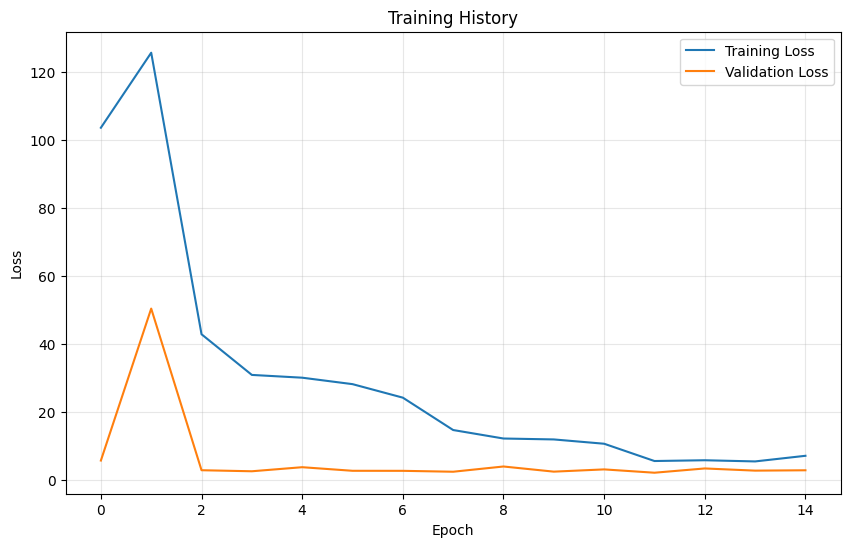

In [ ]:
# Create and train the model without temporal data
print("\nTraining model without temporal data (ablation study)...")
no_temporal_model = DigitalTwinNoTemporal(structured_dim=structured_dim)
no_temporal_trained, _, _ = train_model(
    no_temporal_model, train_loader, val_loader, epochs=15, lr=0.001
)



In [ ]:
# Evaluate the non-temporal model
no_temporal_results = evaluate_model(no_temporal_trained, test_loader)



Test Results:
Mortality - AUC: 0.5751, Accuracy: 0.8583
Length of Stay - MSE: 77.9416, RMSE: 8.8285
Readmission - AUC: nan, Accuracy: 1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
# Compare results
print("\nAblation Study Results:")
print("-" * 50)
print("                   | With Temporal Data | Without Temporal Data")
print("-" * 50)
print(f"Mortality AUC      | {evaluation_results['mortality_auc']:.4f} | {no_temporal_results['mortality_auc']:.4f}")
print(f"Mortality Accuracy | {evaluation_results['mortality_acc']:.4f} | {no_temporal_results['mortality_acc']:.4f}")
print(f"Length of Stay RMSE| {evaluation_results['los_rmse']:.4f} | {no_temporal_results['los_rmse']:.4f}")
if not np.isnan(evaluation_results['readmission_auc']) and not np.isnan(no_temporal_results['readmission_auc']):
    print(f"Readmission AUC    | {evaluation_results['readmission_auc']:.4f} | {no_temporal_results['readmission_auc']:.4f}")
print(f"Readmission Acc    | {evaluation_results['readmission_acc']:.4f} | {no_temporal_results['readmission_acc']:.4f}")
print("-" * 50)


Ablation Study Results:
--------------------------------------------------
                   | With Temporal Data | Without Temporal Data
--------------------------------------------------
Mortality AUC      | 0.6254 | 0.5751
Mortality Accuracy | 0.8819 | 0.8583
Length of Stay RMSE| 9.1442 | 8.8285
Readmission Acc    | 1.0000 | 1.0000
--------------------------------------------------


## Mixture of Experts

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Expert network definition
class ExpertNetwork(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, hidden_dim=64):
        super().__init__()
        # Process structured data
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process discharge notes
        self.discharge_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process radiology notes
        self.radiology_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time series with LSTM
        self.ts_encoder = nn.LSTM(
            input_size=4,  # PSA, Testosterone, ALP, Creatinine
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Fusion layer
        self.fusion = nn.Linear(hidden_dim*4, hidden_dim)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each data type
        structured_features = self.structured_encoder(structured)
        discharge_features = self.discharge_encoder(discharge_emb)
        radiology_features = self.radiology_encoder(radiology_emb)

        # Process time series
        _, (hidden, _) = self.ts_encoder(timeseries)
        ts_features = hidden.squeeze(0)

        # Combine features
        combined = torch.cat([
            structured_features,
            discharge_features,
            radiology_features,
            ts_features
        ], dim=1)

        return self.fusion(combined)

# Mixture of Experts model
class DigitalTwinMoE(nn.Module):
    def __init__(self, structured_dim, num_experts=4, embedding_dim=768, hidden_dim=64):
        super().__init__()

        # Create multiple expert networks
        self.experts = nn.ModuleList([
            ExpertNetwork(structured_dim, embedding_dim, hidden_dim)
            for _ in range(num_experts)
        ])

        # Gating network to determine expert weights
        self.gate = nn.Sequential(
            nn.Linear(structured_dim + embedding_dim*2, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts),
            nn.Softmax(dim=1)
        )

        # Task-specific output heads
        self.mortality_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.los_head = nn.Linear(hidden_dim, 1)

        self.readmission_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Determine expert weights using gate
        gate_input = torch.cat([structured, discharge_emb, radiology_emb], dim=1)
        expert_weights = self.gate(gate_input)

        # Get outputs from each expert
        expert_outputs = []
        for expert in self.experts:
            expert_out = expert(structured, discharge_emb, radiology_emb, timeseries)
            expert_outputs.append(expert_out.unsqueeze(1))

        # Stack expert outputs
        stacked_outputs = torch.cat(expert_outputs, dim=1)  # [batch, num_experts, hidden_dim]

        # Weighted sum of expert outputs
        weighted_output = torch.bmm(
            expert_weights.unsqueeze(1),  # [batch, 1, num_experts]
            stacked_outputs  # [batch, num_experts, hidden_dim]
        ).squeeze(1)  # [batch, hidden_dim]

        # Get predictions from task heads
        mortality = self.mortality_head(weighted_output)
        los = self.los_head(weighted_output)
        readmission = self.readmission_head(weighted_output)

        return mortality, los, readmission, expert_weights



In [ ]:

# Focal Loss implementation
def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal Loss for dealing with class imbalance

    Args:
        pred: Model predictions (sigmoid already applied)
        target: Ground truth labels
        alpha: Weighting factor for the rare class
        gamma: Focusing parameter that reduces the loss contribution from easy examples
    """
    # Binary cross entropy
    bce = -(target * torch.log(pred + 1e-7) + (1 - target) * torch.log(1 - pred + 1e-7))

    # Apply the focusing term
    pt = torch.where(target == 1, pred, 1 - pred)
    focal_weight = alpha * (1 - pt) ** gamma

    # Apply the weights and take the mean
    loss = focal_weight * bce
    return loss.mean()


# To use this model:
# 1. Create the model with progress tracking
print("\nInitializing Mixture of Experts Digital Twin model...")
moe_model = DigitalTwinMoE(structured_dim=structured_dim, num_experts=4)
print(f"Model created with {sum(p.numel() for p in moe_model.parameters())} parameters")
print(f"Using {len(moe_model.experts)} expert networks")

# Modified training function with more detailed progress tracking
def train_moe_model_with_tracking(model, train_loader, val_loader, epochs=15, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Using Adam optimizer with learning rate: {lr}")

    # Loss for length of stay
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Track metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print(f"\nStarting training for {epochs} epochs...")
    print(f"Training on {len(train_loader.dataset)} samples, validating on {len(val_loader.dataset)} samples")

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        mortality_losses = []
        los_losses = []
        readmission_losses = []
        diversity_losses = []

        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training loop with progress bar
        for batch_idx, batch in enumerate(train_loader):
            if batch_idx % 10 == 0:
                print(f"  Training batch {batch_idx+1}/{len(train_loader)}", end="\r")

            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with expert weights
            mortality_pred, los_pred, readmission_pred, expert_weights = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Calculate losses with focal loss for classification tasks
            m_loss = focal_loss(mortality_pred, labels[:, 0:1])
            l_loss = mse_loss(los_pred, labels[:, 1:2])
            r_loss = focal_loss(readmission_pred, labels[:, 2:3])
            mortality_losses.append(m_loss.item())
            los_losses.append(l_loss.item())
            readmission_losses.append(r_loss.item())

            # Expert diversity loss (encourage specialization)
            entropy = -(expert_weights * torch.log(expert_weights + 1e-7)).sum(dim=1).mean()
            d_loss = -0.1 * entropy  # Negative because we want to maximize entropy
            diversity_losses.append(d_loss.item())

            # Combined loss - weighted sum
            loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss + d_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print batch completion
        print(f"  Completed {len(train_loader)}/{len(train_loader)} training batches")

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Print detailed training metrics
        print(f"  Training stats - Loss: {train_loss:.4f}, " +
              f"Mortality: {np.mean(mortality_losses):.4f}, " +
              f"LOS: {np.mean(los_losses):.4f}, " +
              f"Readmission: {np.mean(readmission_losses):.4f}, " +
              f"Diversity: {np.mean(diversity_losses):.4f}")

        # Validation
        model.eval()
        val_loss = 0
        val_mortality_losses = []
        val_los_losses = []
        val_readmission_losses = []
        expert_usage = np.zeros(len(model.experts))

        print("  Validating...", end="\r")
        with torch.no_grad():
            for batch in val_loader:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred, expert_weights = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Track expert usage
                expert_usage += expert_weights.sum(dim=0).cpu().numpy()

                # Calculate losses
                m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                l_loss = mse_loss(los_pred, labels[:, 1:2])
                r_loss = focal_loss(readmission_pred, labels[:, 2:3])
                val_mortality_losses.append(m_loss.item())
                val_los_losses.append(l_loss.item())
                val_readmission_losses.append(r_loss.item())

                # Combined loss
                loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss

                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Normalize expert usage
        expert_usage = expert_usage / len(val_loader.dataset)

        # Print validation metrics
        print(f"  Validation stats - Loss: {val_loss:.4f}, " +
              f"Mortality: {np.mean(val_mortality_losses):.4f}, " +
              f"LOS: {np.mean(val_los_losses):.4f}, " +
              f"Readmission: {np.mean(val_readmission_losses):.4f}")

        # Print expert usage
        print(f"  Expert utilization: {expert_usage}")

        # Update scheduler
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'digital_twin_moe_best.pt')
            print(f"  New best model saved with val_loss: {val_loss:.4f}")

    # Load best model
    model.load_state_dict(torch.load('digital_twin_moe_best.pt'))
    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")

    return model, train_losses, val_losses

# 2. Train the model with enhanced tracking
print("\nStarting Mixture of Experts model training...")
trained_moe, train_losses, val_losses = train_moe_model_with_tracking(
    moe_model, train_loader, val_loader, epochs=20
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Mixture of Experts Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('moe_training_history.png')
plt.show()


Initializing Mixture of Experts Digital Twin model...
Model created with 735431 parameters
Using 4 expert networks

Starting Mixture of Experts model training...
Using device: cuda
Using Adam optimizer with learning rate: 0.001

Starting training for 20 epochs...
Training on 2432 samples, validating on 608 samples

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Modified training function with more frequent updates and potential performance improvements
def train_moe_model_debug(model, train_loader, val_loader, epochs=15, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Using Adam optimizer with learning rate: {lr}")

    # Loss for length of stay
    mse_loss = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Track metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print(f"\nStarting training for {epochs} epochs...")
    print(f"Training on {len(train_loader.dataset)} samples, validating on {len(val_loader.dataset)} samples")

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        batch_count = 0

        print(f"\nEpoch {epoch+1}/{epochs}")
        print("Training batches:")

        # Training loop with more frequent updates
        for batch_idx, batch in enumerate(train_loader):
            # More frequent progress updates
            if batch_idx % 2 == 0 or batch_idx == len(train_loader) - 1:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}", flush=True)

            try:
                # Move data to device
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass with expert weights
                mortality_pred, los_pred, readmission_pred, expert_weights = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                l_loss = mse_loss(los_pred, labels[:, 1:2])
                r_loss = focal_loss(readmission_pred, labels[:, 2:3])

                # Expert diversity loss
                entropy = -(expert_weights * torch.log(expert_weights + 1e-7)).sum(dim=1).mean()
                d_loss = -0.1 * entropy  # Negative because we want to maximize entropy

                # Combined loss
                loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss + d_loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                batch_count += 1

                # Free up memory
                del structured, discharge_emb, radiology_emb, timeseries, labels
                del mortality_pred, los_pred, readmission_pred, expert_weights
                del m_loss, l_loss, r_loss, d_loss, loss
                torch.cuda.empty_cache()

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()

        # Calculate average loss
        if batch_count > 0:
            train_loss = epoch_loss / batch_count
            train_losses.append(train_loss)
            print(f"  Epoch {epoch+1} train loss: {train_loss:.4f}")
        else:
            print("No batches were processed successfully in this epoch")
            continue

        # Validation with minimal processing
        print("  Validating...")
        model.eval()
        val_loss = 0
        val_batch_count = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                if batch_idx % 5 == 0:
                    print(f"    Val batch {batch_idx+1}/{len(val_loader)}", flush=True)

                try:
                    # Move data to device
                    structured = batch['structured'].to(device)
                    discharge_emb = batch['discharge_emb'].to(device)
                    radiology_emb = batch['radiology_emb'].to(device)
                    timeseries = batch['timeseries'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    mortality_pred, los_pred, readmission_pred, _ = model(
                        structured, discharge_emb, radiology_emb, timeseries
                    )

                    # Calculate losses
                    m_loss = focal_loss(mortality_pred, labels[:, 0:1])
                    l_loss = mse_loss(los_pred, labels[:, 1:2])
                    r_loss = focal_loss(readmission_pred, labels[:, 2:3])

                    # Combined loss
                    loss = 0.4 * m_loss + 0.3 * l_loss / 100 + 0.3 * r_loss

                    val_loss += loss.item()
                    val_batch_count += 1

                    # Free up memory
                    del structured, discharge_emb, radiology_emb, timeseries, labels
                    del mortality_pred, los_pred, readmission_pred
                    del m_loss, l_loss, r_loss, loss
                    torch.cuda.empty_cache()

                except Exception as e:
                    print(f"Error in validation batch {batch_idx}: {e}")

        if val_batch_count > 0:
            val_loss = val_loss / val_batch_count
            val_losses.append(val_loss)
            print(f"  Validation loss: {val_loss:.4f}")

            # Update scheduler
            scheduler.step(val_loss)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'digital_twin_moe_best.pt')
                print(f"  New best model saved with val_loss: {val_loss:.4f}")
        else:
            print("No validation batches were processed successfully")

    # Load best model
    try:
        model.load_state_dict(torch.load('digital_twin_moe_best.pt'))
        print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")
    except:
        print("Could not load best model, using the current model state")

    return model, train_losses, val_losses

# Try with a smaller batch size and the debug training function
batch_size = 8  # Reduce batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created data loaders with reduced batch size {batch_size}")

# Try training with debug version
print("\nStarting Mixture of Experts model training with debug...")
trained_moe, train_losses, val_losses = train_moe_model_debug(
    moe_model, train_loader, val_loader, epochs=20
)

Created data loaders with reduced batch size 8

Starting Mixture of Experts model training with debug...
Using device: cuda
Using Adam optimizer with learning rate: 0.001

Starting training for 20 epochs...
Training on 2432 samples, validating on 608 samples

Epoch 1/20
Training batches:
  Batch 1/304
  Batch 3/304
  Batch 5/304
  Batch 7/304
  Batch 9/304
  Batch 11/304
  Batch 13/304
  Batch 15/304
  Batch 17/304
  Batch 19/304
  Batch 21/304
  Batch 23/304
  Batch 25/304
  Batch 27/304
  Batch 29/304
  Batch 31/304
  Batch 33/304
  Batch 35/304
  Batch 37/304
  Batch 39/304
  Batch 41/304
  Batch 43/304
  Batch 45/304
  Batch 47/304
  Batch 49/304
  Batch 51/304
  Batch 53/304
  Batch 55/304
  Batch 57/304
  Batch 59/304
  Batch 61/304
  Batch 63/304
  Batch 65/304
  Batch 67/304
  Batch 69/304
  Batch 71/304
  Batch 73/304
  Batch 75/304
  Batch 77/304
  Batch 79/304
  Batch 81/304
  Batch 83/304
  Batch 85/304
  Batch 87/304
  Batch 89/304
  Batch 91/304
  Batch 93/304
  Batch 95/

In [ ]:

# Evaluation function that also returns expert weights
def evaluate_moe_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    all_mortality_preds = []
    all_los_preds = []
    all_readmission_preds = []
    all_true_labels = []
    all_expert_weights = []

    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred, expert_weights = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Collect predictions
            all_mortality_preds.extend(mortality_pred.cpu().numpy())
            all_los_preds.extend(los_pred.cpu().numpy())
            all_readmission_preds.extend(readmission_pred.cpu().numpy())
            all_true_labels.extend(batch['labels'].numpy())
            all_expert_weights.extend(expert_weights.cpu().numpy())

    # Convert to numpy arrays
    all_mortality_preds = np.array(all_mortality_preds)
    all_los_preds = np.array(all_los_preds)
    all_readmission_preds = np.array(all_readmission_preds)
    all_true_labels = np.array(all_true_labels)
    all_expert_weights = np.array(all_expert_weights)

    # Calculate metrics
    from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score

    # Try-except for handling potential issues with readmission AUC
    try:
        readmission_auc = roc_auc_score(all_true_labels[:, 2], all_readmission_preds.squeeze())
    except:
        readmission_auc = float('nan')

    # Mortality metrics
    mortality_auc = roc_auc_score(all_true_labels[:, 0], all_mortality_preds.squeeze())
    mortality_preds_binary = (all_mortality_preds > 0.5).astype(int)
    mortality_acc = accuracy_score(all_true_labels[:, 0], mortality_preds_binary.squeeze())

    # Length of stay metrics
    los_mse = mean_squared_error(all_true_labels[:, 1], all_los_preds.squeeze())
    los_rmse = np.sqrt(los_mse)

    # Readmission metrics
    readmission_preds_binary = (all_readmission_preds > 0.5).astype(int)
    readmission_acc = accuracy_score(all_true_labels[:, 2], readmission_preds_binary.squeeze())

    return {
        'mortality_auc': mortality_auc,
        'mortality_acc': mortality_acc,
        'los_rmse': los_rmse,
        'readmission_auc': readmission_auc,
        'readmission_acc': readmission_acc,
        'expert_weights': all_expert_weights
    }


In [ ]:
#Evaluate the model
moe_results = evaluate_moe_model(trained_moe, test_loader)



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
# 4. Print results
print("\nMixture of Experts Model Results:")
print("-" * 50)
print(f"Mortality AUC: {moe_results['mortality_auc']:.4f}")
print(f"Mortality Accuracy: {moe_results['mortality_acc']:.4f}")
print(f"Length of Stay RMSE: {moe_results['los_rmse']:.4f}")
if not np.isnan(moe_results['readmission_auc']):
    print(f"Readmission AUC: {moe_results['readmission_auc']:.4f}")
print(f"Readmission Accuracy: {moe_results['readmission_acc']:.4f}")
print("-" * 50)

# 5. Analyze expert specialization
expert_weights = moe_results['expert_weights']
print("\nExpert Specialization Analysis:")
print(f"Average expert utilization: {np.mean(expert_weights, axis=0)}")


Mixture of Experts Model Results:
--------------------------------------------------
Mortality AUC: 0.5668
Mortality Accuracy: 0.9134
Length of Stay RMSE: 6.6545
Readmission Accuracy: 1.0000
--------------------------------------------------

Expert Specialization Analysis:
Average expert utilization: [2.6224449e-01 4.6287805e-02 6.9146740e-01 4.5413884e-07]


## Expert Specialization

In [ ]:
def analyze_expert_specialization(model, test_loader, X_test):
    """Analyze which patients each expert handles"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Store patient IDs and their expert assignments
    patient_expert_mapping = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Get patient IDs for this batch
            batch_indices = list(range(i*test_loader.batch_size,
                                min((i+1)*test_loader.batch_size, len(test_loader.dataset))))
            patient_ids = X_test.iloc[batch_indices]['subject_id'].values

            # Get model inputs
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)

            # Forward pass to get expert weights
            _, _, _, expert_weights = model(structured, discharge_emb, radiology_emb, timeseries)
            expert_weights = expert_weights.cpu().numpy()

            # Determine primary expert (highest weight) for each patient
            primary_expert = np.argmax(expert_weights, axis=1)

            # Store mapping
            for j, patient_id in enumerate(patient_ids):
                patient_expert_mapping.append({
                    'subject_id': patient_id,
                    'primary_expert': primary_expert[j],
                    'expert_weights': expert_weights[j],
                })

    # Convert to DataFrame
    expert_df = pd.DataFrame(patient_expert_mapping)

    # Merge with patient features for analysis
    patient_features = X_test.copy()
    analysis_df = patient_features.merge(expert_df, on='subject_id', how='inner')

    # Analyze characteristics by expert
    for expert_idx in range(len(model.experts)):
        expert_patients = analysis_df[analysis_df['primary_expert'] == expert_idx]
        if len(expert_patients) > 0:
            print(f"\nExpert {expert_idx} handles {len(expert_patients)} patients ({len(expert_patients)/len(analysis_df)*100:.1f}%)")

            # Analyze numeric features
            numeric_cols = expert_patients.select_dtypes(include=[np.number]).columns
            for col in numeric_cols:
                if col in ['subject_id', 'primary_expert'] or 'emb_' in col:
                    continue

                # Compare this expert's distribution vs overall
                expert_mean = expert_patients[col].mean()
                overall_mean = analysis_df[col].mean()
                diff_pct = (expert_mean - overall_mean) / overall_mean * 100 if overall_mean != 0 else 0

                print(f"  {col}: {expert_mean:.2f} (overall: {overall_mean:.2f}, diff: {diff_pct:+.1f}%)")

    return analysis_df

# Run the analysis
expert_analysis = analyze_expert_specialization(trained_moe, test_loader, X_test)


Expert 0 handles 57 patients (22.4%)
  num_timepoints: 19.21 (overall: 18.39, diff: +4.5%)
  sequence_duration_days: 387.47 (overall: 956.80, diff: -59.5%)
  latest_psa: 628.91 (overall: 147.74, diff: +325.7%)
  latest_alp: 344.19 (overall: 159.52, diff: +115.8%)
  latest_creatinine: 1.21 (overall: 1.46, diff: -17.1%)
  max_psa: 645.68 (overall: 197.59, diff: +226.8%)
  max_alp: 458.89 (overall: 223.13, diff: +105.7%)
  max_creatinine: 1.67 (overall: 2.06, diff: -19.0%)
  psa_slope: 21.50 (overall: 3.86, diff: +457.0%)

Expert 1 handles 11 patients (4.3%)
  num_timepoints: 20.00 (overall: 18.39, diff: +8.8%)
  sequence_duration_days: 38.98 (overall: 956.80, diff: -95.9%)
  latest_psa: 7.80 (overall: 147.74, diff: -94.7%)
  latest_alp: 124.55 (overall: 159.52, diff: -21.9%)
  latest_creatinine: 3.15 (overall: 1.46, diff: +116.3%)
  max_psa: 7.81 (overall: 197.59, diff: -96.0%)
  max_alp: 148.73 (overall: 223.13, diff: -33.3%)
  max_creatinine: 4.31 (overall: 2.06, diff: +109.0%)
  psa_

## Intervention Simulation

In [ ]:
def simulate_intervention(model, patient_data, intervention_type, intervention_value):
    """
    Simulate an intervention on a patient's digital twin

    Args:
        model: Trained MoE model
        patient_data: Single patient data point from dataset
        intervention_type: Type of intervention (e.g., 'psa_reduction', 'hormone_therapy')
        intervention_value: Magnitude of intervention

    Returns:
        Original and post-intervention predictions
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Get original inputs
    structured = patient_data['structured'].unsqueeze(0).to(device)
    discharge_emb = patient_data['discharge_emb'].unsqueeze(0).to(device)
    radiology_emb = patient_data['radiology_emb'].unsqueeze(0).to(device)
    timeseries = patient_data['timeseries'].unsqueeze(0).to(device)

    # Get baseline predictions
    with torch.no_grad():
        mortality_orig, los_orig, readmission_orig, expert_weights_orig = model(
            structured, discharge_emb, radiology_emb, timeseries
        )

    # Create modified inputs based on intervention type
    timeseries_mod = timeseries.clone()

    if intervention_type == 'psa_reduction':
        # Reduce PSA values by intervention_value percent
        # PSA is first feature (index 0) in timeseries
        reduction = 1.0 - (intervention_value / 100.0)
        timeseries_mod[0, :, 0] *= reduction

    elif intervention_type == 'hormone_therapy':
        # Simulate hormone therapy by reducing testosterone (index 1)
        reduction = 1.0 - (intervention_value / 100.0)
        timeseries_mod[0, :, 1] *= reduction

    # Get updated predictions
    with torch.no_grad():
        mortality_new, los_new, readmission_new, expert_weights_new = model(
            structured, discharge_emb, radiology_emb, timeseries_mod
        )

    # Convert to numpy for easier handling
    results = {
        'original': {
            'mortality': mortality_orig.item(),
            'los': los_orig.item(),
            'readmission': readmission_orig.item(),
            'expert_weights': expert_weights_orig.cpu().numpy()
        },
        'after_intervention': {
            'mortality': mortality_new.item(),
            'los': los_new.item(),
            'readmission': readmission_new.item(),
            'expert_weights': expert_weights_new.cpu().numpy()
        },
        'changes': {
            'mortality_change': (mortality_new.item() - mortality_orig.item()) * 100,
            'los_change': los_new.item() - los_orig.item(),
            'readmission_change': (readmission_new.item() - readmission_orig.item()) * 100,
            'expert_shift': expert_weights_new.cpu().numpy() - expert_weights_orig.cpu().numpy()
        }
    }

    return results

# Test the intervention simulation
def test_interventions():
    # Get a test patient
    test_sample = test_dataset[0]

    # Simulate PSA reduction
    psa_results = simulate_intervention(trained_moe, test_sample, 'psa_reduction', 50)

    print("\nSimulating 50% PSA Reduction:")
    print(f"Original mortality risk: {psa_results['original']['mortality']:.4f}")
    print(f"New mortality risk: {psa_results['after_intervention']['mortality']:.4f}")
    print(f"Change: {psa_results['changes']['mortality_change']:+.2f}%")

    print(f"\nOriginal LOS: {psa_results['original']['los']:.1f} days")
    print(f"New LOS: {psa_results['after_intervention']['los']:.1f} days")
    print(f"Change: {psa_results['changes']['los_change']:+.1f} days")

    print("\nExpert weight shift:")
    for i, shift in enumerate(psa_results['changes']['expert_shift'][0]):
        print(f"  Expert {i}: {shift:+.4f}")

    # Simulate hormone therapy
    hormone_results = simulate_intervention(trained_moe, test_sample, 'hormone_therapy', 80)

    print("\nSimulating Hormone Therapy (80% testosterone reduction):")
    print(f"Original mortality risk: {hormone_results['original']['mortality']:.4f}")
    print(f"New mortality risk: {hormone_results['after_intervention']['mortality']:.4f}")
    print(f"Change: {hormone_results['changes']['mortality_change']:+.2f}%")

# Run intervention tests
test_interventions()


Simulating 50% PSA Reduction:
Original mortality risk: 0.0000
New mortality risk: 0.0000
Change: +0.00%

Original LOS: 5.1 days
New LOS: 5.1 days
Change: +0.0 days

Expert weight shift:
  Expert 0: +0.0000
  Expert 1: +0.0000
  Expert 2: +0.0000
  Expert 3: +0.0000

Simulating Hormone Therapy (80% testosterone reduction):
Original mortality risk: 0.0000
New mortality risk: 0.0000
Change: +0.00%


## Simple Patient Dashboard

In [ ]:
def create_patient_dashboard(model, patient_idx, test_dataset, X_test):
    """Create a visualization dashboard for a patient's digital twin"""
    patient_data = test_dataset[patient_idx]
    patient_id = X_test.iloc[patient_idx]['subject_id']

    # Get predictions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Prepare inputs
    structured = patient_data['structured'].unsqueeze(0).to(device)
    discharge_emb = patient_data['discharge_emb'].unsqueeze(0).to(device)
    radiology_emb = patient_data['radiology_emb'].unsqueeze(0).to(device)
    timeseries = patient_data['timeseries'].unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        mortality, los, readmission, expert_weights = model(
            structured, discharge_emb, radiology_emb, timeseries
        )

    # Convert to numpy
    mortality = mortality.item()
    los = los.item()
    readmission = readmission.item()
    expert_weights = expert_weights.cpu().numpy()[0]

    # Create dashboard visualization
    plt.figure(figsize=(15, 10))

    # 1. Patient info section
    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.text(0.5, 0.9, f"Digital Twin: Patient {patient_id}", fontsize=16, ha='center', weight='bold')
    plt.text(0.5, 0.8, f"Mortality Risk: {mortality:.1%}", fontsize=14, ha='center',
             color='red' if mortality > 0.3 else 'green')
    plt.text(0.5, 0.7, f"Expected Length of Stay: {los:.1f} days", fontsize=14, ha='center')
    plt.text(0.5, 0.6, f"Readmission Risk: {readmission:.1%}", fontsize=14, ha='center')
    plt.text(0.5, 0.4, "Expert Utilization:", fontsize=14, ha='center')

    # Add expert distribution
    expert_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853']
    for i, weight in enumerate(expert_weights):
        plt.text(0.5, 0.3-i*0.05, f"Expert {i}: {weight:.1%}",
                 fontsize=12, ha='center', color=expert_colors[i])

    # 2. Lab test visualization
    plt.subplot(2, 2, 2)
    ts_data = patient_data['timeseries'].numpy()

    test_names = ['PSA', 'Testosterone', 'ALP', 'Creatinine']
    for i, name in enumerate(test_names):
        plt.plot(range(len(ts_data)), ts_data[:, i], marker='o', label=name)

    plt.title("Lab Test Values Over Time")
    plt.xlabel("Time Points")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Intervention simulation
    plt.subplot(2, 2, 3)

    # Simulate interventions
    interventions = [
        ('No Change', 0, 'psa_reduction'),
        ('PSA -25%', 25, 'psa_reduction'),
        ('PSA -50%', 50, 'psa_reduction'),
        ('PSA -75%', 75, 'psa_reduction')
    ]

    labels = []
    mort_values = []
    los_values = []

    for label, value, int_type in interventions:
        result = simulate_intervention(model, patient_data, int_type, value)
        labels.append(label)
        mort_values.append(result['after_intervention']['mortality'])
        los_values.append(result['after_intervention']['los'])

    # Plot mortality risk under interventions
    x = range(len(labels))
    plt.bar(x, mort_values, color='lightcoral')
    plt.title("Mortality Risk by Intervention")
    plt.xticks(x, labels)
    plt.ylabel("Mortality Risk")
    plt.ylim(0, max(mort_values) * 1.2)

    # 4. Length of stay prediction
    plt.subplot(2, 2, 4)
    plt.bar(x, los_values, color='lightblue')
    plt.title("Predicted Length of Stay by Intervention")
    plt.xticks(x, labels)
    plt.ylabel("Days")
    plt.ylim(0, max(los_values) * 1.2)

    plt.tight_layout()
    plt.savefig(f'patient_{patient_id}_dashboard.png')
    plt.show()

# Create dashboard for a sample patient
create_patient_dashboard(trained_moe, 0, test_dataset, X_test)

NameError: name 'plt' is not defined

In [ ]:
#Below this is old code, dont run

In [ ]:
## DONT RUN THIS YET

# 1. PREPARE ALL DATA COMPONENTS

# You already have sequence_df from your lab tests time series
# You have patient_features from demographics and admissions data
# You'll have discharge_features and radiology_features from notes (once embeddings are working)

# 2. INTEGRATE ALL COMPONENTS SEQUENTIALLY

# First merge: Demographics with lab test sequences
patient_with_sequences = patient_features.merge(
    sequence_df,
    on='subject_id',
    how='inner'  # Only keep patients with both demographics and sequence data
)
print(f"Patients with demographics and lab sequences: {len(patient_with_sequences)}")

# Second merge: Add discharge notes embeddings
discharge_df = pd.DataFrame(discharge_features)
# Convert the embedding array to individual columns
for i in range(len(discharge_df.iloc[0]['discharge_embedding'])):
    discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
discharge_df = discharge_df.drop(columns=['discharge_embedding'])

patient_with_notes = patient_with_sequences.merge(
    discharge_df,
    on='subject_id',
    how='left'  # Keep all patients, even without discharge notes
)
print(f"Patients after adding discharge notes: {len(patient_with_notes)}")

# Third merge: Add radiology notes embeddings
radiology_df = pd.DataFrame(radiology_features)
# Convert the embedding array to individual columns
for i in range(len(radiology_df.iloc[0]['radiology_embedding'])):
    radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
radiology_df = radiology_df.drop(columns=['radiology_embedding'])

patient_full_data = patient_with_notes.merge(
    radiology_df,
    on='subject_id',
    how='left'  # Keep all patients, even without radiology notes
)
print(f"Patients in final integrated dataset: {len(patient_full_data)}")

# 3. HANDLE MISSING VALUES

# Fill missing embeddings with zeros
embedding_cols = [col for col in patient_full_data.columns if 'emb_' in col]
patient_full_data[embedding_cols] = patient_full_data[embedding_cols].fillna(0)

# Fill other missing numeric values with median
numeric_cols = patient_full_data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in embedding_cols]
patient_full_data[numeric_cols] = patient_full_data[numeric_cols].fillna(patient_full_data[numeric_cols].median())

# 4. FINAL DATASET PREPARATION

# Remove sequence arrays before saving to csv (they're not needed for modeling)
modeling_dataset = patient_full_data.drop(columns=['full_sequence_data', 'timestamps'])

# Save the dataset
modeling_dataset.to_csv("prostate_cancer_integrated_dataset.csv", index=False)

# Print summary stats
print("\nFinal dataset shape:", modeling_dataset.shape)
print("\nFeature groups in final dataset:")
print(f"- Demographics and basic features: {len(set(patient_features.columns) & set(modeling_dataset.columns))}")
print(f"- Lab sequence features: {len(set(sequence_df.columns) & set(modeling_dataset.columns)) - 1}")  # -1 for subject_id
print(f"- Discharge note features: {len([c for c in modeling_dataset.columns if 'discharge_emb_' in c])}")
print(f"- Radiology note features: {len([c for c in modeling_dataset.columns if 'radiology_emb_' in c])}")

# 5. EXAMINE TARGET VARIABLES (for modeling)
print("\nTarget distribution:")
print("Mortality:", modeling_dataset['mortality'].value_counts(normalize=True))
print("30-day readmission:", modeling_dataset['readmission_30d'].value_counts(normalize=True))
print("Length of stay (days):", modeling_dataset['los_days'].describe())

Patients with demographics and lab sequences: 5864


<ipython-input-36-febb81eee378>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  discharge_df[f'discharge_emb_{i}'] = discharge_df['discharge_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Patients after adding discharge notes: 5864


<ipython-input-36-febb81eee378>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  radiology_df[f'radiology_emb_{i}'] = radiology_df['radiology_embedding'].apply(lambda x: x[i])
<ipython-input-36-febb81eee378>:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

Patients in final integrated dataset: 5864

Final dataset shape: (5864, 1554)

Feature groups in final dataset:
- Demographics and basic features: 9
- Lab sequence features: 9
- Discharge note features: 768
- Radiology note features: 768

Target distribution:
Mortality: mortality
0    0.981241
1    0.018759
Name: proportion, dtype: float64
30-day readmission: readmission_30d
0    0.770975
1    0.229025
Name: proportion, dtype: float64
Length of stay (days): count    5864.000000
mean        4.706256
std         6.739817
min        -0.570833
25%         1.356771
50%         2.879861
75%         5.728125
max       134.682639
Name: los_days, dtype: float64


In [ ]:
# Check for duplicate subject_ids in your original dataframes
print("Unique patients in patient_features:", patient_features['subject_id'].nunique())
print("Total rows in patient_features:", len(patient_features))

print("Unique patients in sequence_df:", sequence_df['subject_id'].nunique())
print("Total rows in sequence_df:", len(sequence_df))

# Check how many patients have both data types
common_patients = set(patient_features['subject_id']).intersection(set(sequence_df['subject_id']))
print("Patients with both demographics and sequence data:", len(common_patients))

# Use inner join with a more explicit check for duplicates
patient_with_sequences = patient_features.merge(
    sequence_df,
    on='subject_id',
    how='inner'
)

# Check for duplicates after merge
print("Rows after merge:", len(patient_with_sequences))
print("Unique patients after merge:", patient_with_sequences['subject_id'].nunique())

# If you find duplicates, use drop_duplicates or groupby to handle them
if len(patient_with_sequences) > patient_with_sequences['subject_id'].nunique():
    print("Duplicates found. Keeping only the first instance of each patient.")
    patient_with_sequences = patient_with_sequences.drop_duplicates(subset=['subject_id'])

print("Final dataset size after removing duplicates:", len(patient_with_sequences))

Unique patients in patient_features: 2497
Total rows in patient_features: 9344
Unique patients in sequence_df: 1267
Total rows in sequence_df: 1267
Patients with both demographics and sequence data: 1267
Rows after merge: 5864
Unique patients after merge: 1267
Duplicates found. Keeping only the first instance of each patient.
Final dataset size after removing duplicates: 1267


In [ ]:
missing_sequence_patients = set(patient_features['subject_id']) - set(sequence_df['subject_id'])
print(f"Number of patients without sequence data: {len(missing_sequence_patients)}")

NameError: name 'patient_features' is not defined

In [ ]:
patient_features.describe()

subject_id   anchor_age  anchor_year    mortality     los_days  \
count  9.344000e+03  9344.000000  9344.000000  9344.000000  9344.000000   
mean   1.501225e+07    70.143193  2154.702590     0.024401     4.926475   
std    2.838765e+06    11.133291    23.628943     0.154298     6.916112   
min    1.000672e+07    25.000000  2110.000000     0.000000    -0.576389   
25%    1.252599e+07    62.000000  2135.000000     0.000000     1.423437   
50%    1.500191e+07    70.000000  2156.000000     0.000000     2.962500   
75%    1.740491e+07    79.000000  2174.000000     0.000000     5.917361   
max    1.998978e+07    91.000000  2205.000000     1.000000   134.682639   

       readmission_30d  
count      9344.000000  
mean          0.225278  
std           0.417788  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.000000  
max           1.000000

In [ ]:
# Temporal Integration March 14th

In [ ]:
import torch
import torch.nn as nn
class TimeSeriesModule(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

    def forward(self, x):
        # x shape: [batch_size, seq_length, features]
        outputs, (h_n, c_n) = self.lstm(x)
        # Return last hidden state
        return h_n[-1]  # Shape: [batch_size, hidden_size]

# Prepare time-series data
def prepare_timeseries_data(patient_id, lab_data, max_seq_length=20):
    """Create time-ordered sequences of lab values for a patient"""
    # Filter data for this patient
    patient_labs = lab_data[lab_data['subject_id'] == patient_id]
    # Sort by time
    patient_labs = patient_labs.sort_values('charttime')

    # Create sequences for key lab tests
    key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

    # Initialize sequence arrays
    sequences = []

    for test_id in key_tests:
        test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
        # Pad or truncate to fixed length
        if len(test_values) > max_seq_length:
            test_values = test_values[-max_seq_length:]  # Keep most recent
        elif len(test_values) < max_seq_length:
            test_values = np.pad(test_values,
                                (0, max_seq_length - len(test_values)),
                                'constant',
                                constant_values=0)
        sequences.append(test_values)

    # Stack all tests
    if sequences:
        return np.stack(sequences, axis=1)  # [seq_length, num_features]
    else:
        return np.zeros((max_seq_length, len(key_tests)))

In [ ]:
#Feature Engineering - March 14th

In [ ]:
def engineer_features(patient_data, lab_data):
    """Create advanced features from patient data"""
    features = {}

    # 1. PSA-specific features
    psa_values = lab_data[(lab_data['subject_id'] == patient_data['subject_id']) &
                          (lab_data['itemid'] == 50974)]['valuenum'].values

    if len(psa_values) >= 2:
        # PSA velocity (rate of change per year)
        features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

        # PSA doubling time
        if psa_values[0] > 0 and psa_values[-1] > 0:
            features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
        else:
            features['psa_doubling_time'] = 0

        # PSA variability
        features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
    else:
        features['psa_velocity'] = 0
        features['psa_doubling_time'] = 0
        features['psa_variability'] = 0

    # 2. Age-related features
    features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

    # 3. Comorbidity features (count of other diagnoses)
    diagnoses_count = len(lab_data[lab_data['subject_id'] == patient_data['subject_id']]['itemid'].unique())
    features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

    # 4. Lab test frequency features
    test_frequency = lab_data[lab_data['subject_id'] == patient_data['subject_id']].groupby('itemid').size()
    features['lab_test_frequency'] = len(test_frequency)

    # 5. Treatment indicators
    has_hormone_therapy = any(test_id in lab_data[lab_data['subject_id'] == patient_data['subject_id']]['itemid'].values
                             for test_id in [50988, 50894])  # Testosterone tests
    features['hormone_therapy'] = int(has_hormone_therapy)

    return features

In [ ]:
# Add to final dataset
patient_features = patient_features.merge(pd.DataFrame(discharge_features),
                                  on='subject_id', how='left')
patient_features = patient_features.merge(pd.DataFrame(radiology_features),
                                  on='subject_id', how='left')

In [ ]:
patient_features.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset.csv', index=False)

In [ ]:
#Saving enhanced dataset
patient_features.to_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset_temporal.csv', index=False)

In [ ]:
patient_features = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset.csv')

In [ ]:
#Loading enhanced dataset
patient_features = pd.read_csv('/content/drive/MyDrive/Thesis_Brainstorm/PreparingData_Feb2025/FinalDataset/final_dataset_temporal.csv')

In [ ]:
# Check what we have
print("Final dataset shape:", patient_features.shape)
print("\nFeatures in dataset:")
for col in patient_features.columns:
    print(f"- {col}")

# Check for missing values
print("\nMissing values:")
print(patient_features.isnull().sum())

Final dataset shape: (9344, 11)

Features in dataset:
- subject_id
- gender
- anchor_age
- anchor_year
- anchor_year_group
- dod
- mortality
- los_days
- readmission_30d
- discharge_embedding
- radiology_embedding

Missing values:
subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                    4767
mortality                 0
los_days                  0
readmission_30d           0
discharge_embedding    1288
radiology_embedding    1167
dtype: int64


In [ ]:
print("Handling missing embeddings...")

# Get one non-null embedding to find the embedding size
sample_discharge_emb = patient_features['discharge_embedding'].dropna().iloc[0]
embedding_size = len(sample_discharge_emb)

Handling missing embeddings...


In [ ]:
import numpy as np
# Create zero array for missing values
zero_embedding = np.zeros(embedding_size)

# Create new columns with handled embeddings
discharge_embeddings = []
radiology_embeddings = []

# Handle discharge embeddings
for emb in patient_features['discharge_embedding']:
    if isinstance(emb, (float, type(None))) and pd.isna(emb):
        discharge_embeddings.append(zero_embedding)
    else:
        discharge_embeddings.append(emb)

# Handle radiology embeddings
for emb in patient_features['radiology_embedding']:
    if isinstance(emb, (float, type(None))) and pd.isna(emb):
        radiology_embeddings.append(zero_embedding)
    else:
        radiology_embeddings.append(emb)

# Replace the columns
patient_features['discharge_embedding'] = discharge_embeddings
patient_features['radiology_embedding'] = radiology_embeddings

In [ ]:
patient_features = patient_features.drop('dod', axis=1)

In [ ]:
# Verify no missing values remain
print("\nMissing values after handling:")
print(patient_features.isnull().sum())


Missing values after handling:
subject_id             0
gender                 0
anchor_age             0
anchor_year            0
anchor_year_group      0
mortality              0
los_days               0
readmission_30d        0
discharge_embedding    0
radiology_embedding    0
dtype: int64


In [ ]:
# 2. Prepare Data for Model
# Split features and targets
X = patient_features.drop(['mortality', 'los_days', 'readmission_30d'], axis=1)
y = patient_features[['mortality', 'los_days', 'readmission_30d']]

# Split into train/validation/test
from sklearn.model_selection import train_test_split

# First split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['mortality']  # stratify on mortality
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval['mortality']
)

print("\nData split sizes:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Data split sizes:
Train: 5980 samples
Validation: 1495 samples
Test: 1869 samples


In [ ]:
# 3. Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Identify numerical columns (excluding embeddings and subject_id)
numerical_cols = ['anchor_age', 'anchor_year']

# Scale numerical features
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
# 4. Encode categorical variables
categorical_cols = ['gender', 'anchor_year_group']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_val = pd.get_dummies(X_val, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure all sets have same columns
train_cols = X_train.columns
X_val = X_val.reindex(columns=train_cols, fill_value=0)
X_test = X_test.reindex(columns=train_cols, fill_value=0)

In [ ]:
print("\nFinal feature set shape:", X_train.shape)
print("Number of features:", len(train_cols))


Final feature set shape: (5980, 11)
Number of features: 11


In [ ]:
# 5. Create PyTorch datasets
import torch
from torch.utils.data import Dataset, DataLoader

class PCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get numerical and categorical features
        features = torch.tensor(
            self.X.drop(['subject_id', 'discharge_embedding', 'radiology_embedding'], axis=1).iloc[idx].values,
            dtype=torch.float32
        )

        # Get embeddings
        discharge_emb = torch.tensor(
            self.X['discharge_embedding'].iloc[idx],
            dtype=torch.float32
        )
        radiology_emb = torch.tensor(
            self.X['radiology_embedding'].iloc[idx],
            dtype=torch.float32
        )

        # Get labels
        labels = torch.tensor(
            self.y.iloc[idx].values,
            dtype=torch.float32
        )

        return {
            'features': features,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'labels': labels
        }

# Create datasets and dataloaders
batch_size = 32
train_dataset = PCDataset(X_train, y_train)
val_dataset = PCDataset(X_val, y_val)
test_dataset = PCDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("\nDataLoaders created successfully!")


DataLoaders created successfully!


In [ ]:
#MODEL ARCHITECHTURE
##not enhanced

import torch.nn as nn

class MultiTaskModel(nn.Module):
    def __init__(self, num_features, embedding_dim=768):
        super().__init__()

        # Process structured features
        self.structured_encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process embeddings (discharge and radiology)
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim * 2, 256),  # Combine both embeddings
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(128 + 256, 256),  # Combine structured and text features
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        self.mortality_head = nn.Linear(256, 1)
        self.los_head = nn.Linear(256, 1)
        self.readmission_head = nn.Linear(256, 1)

    def forward(self, features, discharge_emb, radiology_emb):
        # Process structured features
        structured_features = self.structured_encoder(features)

        # Process and combine embeddings
        combined_emb = torch.cat([discharge_emb, radiology_emb], dim=1)
        text_features = self.embedding_encoder(combined_emb)

        # Fusion
        combined = torch.cat([structured_features, text_features], dim=1)
        fused = self.fusion(combined)

        # Task predictions
        mortality = torch.sigmoid(self.mortality_head(fused))
        los = self.los_head(fused)
        readmission = torch.sigmoid(self.readmission_head(fused))

        return mortality, los, readmission

In [ ]:
# New enhanced multitask model after addting temporal integration, March 14th
class EnhancedMultiTaskModel(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, ts_hidden_dim=64):
        super().__init__()

        # Process structured features
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process embeddings
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time-series
        self.timeseries_encoder = TimeSeriesModule(
            input_size=4,  # Number of lab tests
            hidden_size=ts_hidden_dim
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(128 + 256 + ts_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        self.mortality_head = nn.Linear(256, 1)
        self.los_head = nn.Linear(256, 1)
        self.readmission_head = nn.Linear(256, 1)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Process each input type
        structured_features = self.structured_encoder(structured)

        combined_emb = torch.cat([discharge_emb, radiology_emb], dim=1)
        text_features = self.embedding_encoder(combined_emb)

        timeseries_features = self.timeseries_encoder(timeseries)


        # mortality_pred = torch.sigmoid(self.mortality_head(features))
        # readmission_pred = torch.sigmoid(self.readmission_head(features))
        # # LOS doesn't need sigmoid since it's a regression task
        # los_pred = self.los_head(features)

        # return mortality_pred, los_pred, readmission_pred


        # Combine all features
        combined = torch.cat([structured_features, text_features, timeseries_features], dim=1)
        fused = self.fusion(combined)

        # Task predictions
        #mortality = torch.sigmoid(self.mortality_head(fused))
        los = self.los_head(fused)
        #readmission = torch.sigmoid(self.readmission_head(fused))


        # Then remove sigmoid from your model's forward function
        mortality = self.mortality_head(fused)  # No sigmoid
        readmission = self.readmission_head(fused)  # No sigmoid


        return mortality, los, readmission

In [ ]:
#Enhanced PCDataset - March 22nd
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

class EnhancedPCDataset(Dataset):
    def __init__(self, X, y, lab_data):
        self.X = X
        self.y = y
        self.lab_data = lab_data

        # Process embeddings
        self.discharge_embeddings = []
        self.radiology_embeddings = []
        self.process_embeddings()

        # Get basic feature columns
        self.feature_cols = [col for col in X.columns
                          if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]

        # Process structured features
        self.process_structured_features()

        # Process time-series data
        self.timeseries_data = []
        self.process_timeseries()

    def process_embeddings(self):
        """Process text embeddings"""
        print("Processing embeddings...")
        embedding_size = 768

        for i in range(len(self.X)):
            # Process discharge embeddings
            discharge_str = self.X['discharge_embedding'].iloc[i]
            if isinstance(discharge_str, str):
                try:
                    discharge_str = discharge_str.strip('[]')
                    values = [v for v in discharge_str.split() if v]
                    discharge_emb = np.array([float(v) for v in values])
                    if len(discharge_emb) != embedding_size:
                        discharge_emb = np.zeros(embedding_size)
                except:
                    discharge_emb = np.zeros(embedding_size)
            else:
                discharge_emb = np.zeros(embedding_size)
            self.discharge_embeddings.append(discharge_emb)

            # Process radiology embeddings
            radiology_str = self.X['radiology_embedding'].iloc[i]
            if isinstance(radiology_str, str):
                try:
                    radiology_str = radiology_str.strip('[]')
                    values = [v for v in radiology_str.split() if v]
                    radiology_emb = np.array([float(v) for v in values])
                    if len(radiology_emb) != embedding_size:
                        radiology_emb = np.zeros(embedding_size)
                except:
                    radiology_emb = np.zeros(embedding_size)
            else:
                radiology_emb = np.zeros(embedding_size)
            self.radiology_embeddings.append(radiology_emb)

    def process_structured_features(self):
        """Process and engineer structured features"""
        print("Engineering features...")
        # Add standard features
        self.structured_features = self.X[self.feature_cols].values.astype(np.float32)

        # Add engineered features
        engineered_features = []
        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            patient_data = {'subject_id': patient_id, 'anchor_age': self.X['anchor_age'].iloc[i]}

            # Get this patient's lab data
            patient_labs = self.lab_data[self.lab_data['subject_id'] == patient_id]

            # Engineer features
            features = self.engineer_features(patient_data, patient_labs)
            engineered_features.append(list(features.values()))

        # Convert to numpy array
        if engineered_features:
            engineered_array = np.array(engineered_features, dtype=np.float32)
            # Combine with standard features
            self.structured_features = np.hstack([self.structured_features, engineered_array])

    def process_timeseries(self):
        """Prepare time-series data for each patient"""
        print("Processing time-series data...")
        max_seq_length = 20

        for i in range(len(self.X)):
            patient_id = self.X['subject_id'].iloc[i]
            ts_data = self.prepare_timeseries_data(patient_id, self.lab_data, max_seq_length)
            self.timeseries_data.append(ts_data)

    def engineer_features(self, patient_data, lab_data):
        """Create advanced features from patient data"""
        features = {}

        # 1. PSA-specific features
        psa_values = lab_data[(lab_data['itemid'] == 50974)]['valuenum'].values

        if len(psa_values) >= 2:
            # PSA velocity (rate of change per year)
            features['psa_velocity'] = (psa_values[-1] - psa_values[0]) / max(1, len(psa_values)/12)

            # PSA doubling time
            if psa_values[0] > 0 and psa_values[-1] > 0:
                features['psa_doubling_time'] = (np.log(2) * len(psa_values)) / max(0.001, np.log(psa_values[-1]/psa_values[0]))
            else:
                features['psa_doubling_time'] = 0

            # PSA variability
            features['psa_variability'] = np.std(psa_values) / (np.mean(psa_values) + 0.001)
        else:
            features['psa_velocity'] = 0
            features['psa_doubling_time'] = 0
            features['psa_variability'] = 0

        # 2. Age-related features
        features['age_group'] = patient_data['anchor_age'] // 10  # Age by decade

        # 3. Comorbidity features (count of other diagnoses)
        diagnoses_count = len(lab_data['itemid'].unique())
        features['diagnosis_count'] = min(diagnoses_count, 20)  # Cap at 20 for stability

        # 4. Lab test frequency features
        test_frequency = lab_data.groupby('itemid').size()
        features['lab_test_frequency'] = len(test_frequency)

        # 5. Treatment indicators
        has_hormone_therapy = any(test_id in lab_data['itemid'].values
                                for test_id in [50988, 50894])  # Testosterone tests
        features['hormone_therapy'] = int(has_hormone_therapy)

        return features

    def prepare_timeseries_data(self, patient_id, lab_data, max_seq_length=20):
        """Create time-ordered sequences of lab values for a patient"""
        # Filter data for this patient
        patient_labs = lab_data[lab_data['subject_id'] == patient_id]

        # Sort by time
        if 'charttime' in patient_labs.columns:
            patient_labs = patient_labs.sort_values('charttime')

        # Create sequences for key lab tests
        key_tests = [50974, 50988, 50863, 50912]  # PSA, Testosterone, ALP, Creatinine

        # Initialize sequences
        sequences = []

        for test_id in key_tests:
            test_values = patient_labs[patient_labs['itemid'] == test_id]['valuenum'].values
            # Pad or truncate to fixed length
            if len(test_values) > max_seq_length:
                test_values = test_values[-max_seq_length:]  # Keep most recent
            elif len(test_values) < max_seq_length:
                test_values = np.pad(test_values,
                                    (0, max_seq_length - len(test_values)),
                                    'constant',
                                    constant_values=0)
            sequences.append(test_values)

        # Stack all tests
        if sequences:
            return np.stack(sequences, axis=1)  # [seq_length, num_features]
        else:
            return np.zeros((max_seq_length, len(key_tests)))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features (including engineered features)
        structured = torch.tensor(self.structured_features[idx], dtype=torch.float32)

        # Get embeddings
        discharge_emb = torch.tensor(self.discharge_embeddings[idx], dtype=torch.float32)
        radiology_emb = torch.tensor(self.radiology_embeddings[idx], dtype=torch.float32)

        # Get time-series data
        timeseries = torch.tensor(self.timeseries_data[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'structured': structured,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'timeseries': timeseries,
            'labels': labels
        }

In [ ]:
# Before creating your dataset
print(f"Mortality label range: {y['mortality'].min()} to {y['mortality'].max()}")
print(f"Readmission label range: {y['readmission_30d'].min()} to {y['readmission_30d'].max()}")

Mortality label range: 0 to 1
Readmission label range: 0 to 1


In [ ]:
from torch.utils.data import Dataset, DataLoader
# Create datasets with the enhanced class
lab_data = pc_labs

# Create enhanced datasets
train_dataset = EnhancedPCDataset(X_train, y_train, lab_data)
val_dataset = EnhancedPCDataset(X_val, y_val, lab_data)
test_dataset = EnhancedPCDataset(X_test, y_test, lab_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Processing embeddings...
Engineering features...
Processing time-series data...
Processing embeddings...
Engineering features...
Processing time-series data...
Processing embeddings...
Engineering features...
Processing time-series data...


In [ ]:
#dont run this anymore
#DEFINE TRAINING PARAMETERS

# Define loss functions
binary_criterion = nn.BCELoss()  # for mortality and readmission
regression_criterion = nn.MSELoss()  # for length of stay

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 20

In [ ]:
# dont run this anymore
from torch.utils.data import Dataset # Importing the Dataset class
class PCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

        # Process features
        self.feature_cols = [col for col in X.columns
                          if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]
        self.features = self.X[self.feature_cols].values.astype(np.float32)

        # Set fixed embedding size
        self.embedding_size = 768

        # Process all embeddings
        print("Processing embeddings...")
        self.discharge_embeddings = []
        self.radiology_embeddings = []

        for i in range(len(X)):
            # Process discharge embeddings
            discharge_str = X['discharge_embedding'].iloc[i]
            if isinstance(discharge_str, str):
                try:
                    # Clean the string - remove brackets and extra spaces
                    discharge_str = discharge_str.strip('[]')
                    # Split by spaces and/or line breaks
                    values = [v for v in discharge_str.split() if v]
                    # Convert to floats
                    discharge_emb = np.array([float(v) for v in values])
                    # Ensure it's the right size
                    if len(discharge_emb) != self.embedding_size:
                        print(f"Warning: Discharge embedding at index {i} has size {len(discharge_emb)}")
                        discharge_emb = np.zeros(self.embedding_size)
                except:
                    discharge_emb = np.zeros(self.embedding_size)
            else:
                discharge_emb = np.zeros(self.embedding_size)
            self.discharge_embeddings.append(discharge_emb)

            # Process radiology embeddings
            radiology_str = X['radiology_embedding'].iloc[i]
            if isinstance(radiology_str, str):
                try:
                    radiology_str = radiology_str.strip('[]')
                    values = [v for v in radiology_str.split() if v]
                    radiology_emb = np.array([float(v) for v in values])
                    # Ensure it's the right size
                    if len(radiology_emb) != self.embedding_size:
                        print(f"Warning: Radiology embedding at index {i} has size {len(radiology_emb)}")
                        radiology_emb = np.zeros(self.embedding_size)
                except:
                    radiology_emb = np.zeros(self.embedding_size)
            else:
                radiology_emb = np.zeros(self.embedding_size)
            self.radiology_embeddings.append(radiology_emb)

        print(f"Processed {len(self.discharge_embeddings)} embeddings")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get structured features
        features = torch.tensor(self.features[idx], dtype=torch.float32)

        # Get embeddings
        discharge_emb = torch.tensor(self.discharge_embeddings[idx], dtype=torch.float32)
        radiology_emb = torch.tensor(self.radiology_embeddings[idx], dtype=torch.float32)

        # Get labels
        labels = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        return {
            'features': features,
            'discharge_emb': discharge_emb,
            'radiology_emb': radiology_emb,
            'labels': labels
        }

In [ ]:
# New training loop - March 22nd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Loss functions
    bce_loss = nn.BCELoss()  # For mortality and readmission
    mse_loss = nn.MSELoss()  # For length of stay

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        total_loss = 0

        # This is where your code snippet would go
        for batch in train_loader:
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )
            # Clip mortality predictions to (0, 1)
            mortality_pred = torch.clamp(mortality_pred, 0.0001, 0.9999)
            readmission_pred = torch.clamp(readmission_pred, 0.0001, 0.9999)

            # Calculate losses
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            los_loss = mse_loss(los_pred, labels[:, 1:2])
            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

        # Validation code would follow here

    return model

In [ ]:
#March 25th , cpu instead of gpu , still didnt work
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Loss functions
    bce_loss = nn.BCELoss()  # For mortality and readmission
    mse_loss = nn.MSELoss()  # For length of stay

    # For early stopping
    best_val_loss = float('inf')
    best_model = None
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        total_loss = 0

        # Training loop
        for batch in train_loader:
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Calculate losses
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            los_loss = mse_loss(los_pred, labels[:, 1:2])
            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate training metrics
        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        mortality_true, mortality_pred_list = [], []
        los_true, los_pred_list = [], []
        readmission_true, readmission_pred_list = [], []

        with torch.no_grad():  # No gradients needed for validation
            for batch in val_loader:
                structured = batch['structured'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                timeseries = batch['timeseries'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                mortality_pred, los_pred, readmission_pred = model(
                    structured, discharge_emb, radiology_emb, timeseries
                )

                # Calculate losses
                # mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
                # los_loss = mse_loss(los_pred, labels[:, 1:2])
                # readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])

                # Make sure values are in [0,1] range for BCE loss
                mortality_loss = bce_loss(mortality_pred, labels[:, 0:1].float())
                los_loss = mse_loss(los_pred, labels[:, 1:2].float())
                readmission_loss = bce_loss(readmission_pred, labels[:, 2:3].float())

                # Combined loss
                batch_loss = mortality_loss + los_loss + readmission_loss
                val_loss += batch_loss.item()

                # Store predictions and true values for metrics
                mortality_true.extend(labels[:, 0].cpu().numpy())
                mortality_pred_list.extend(mortality_pred.cpu().numpy())
                los_true.extend(labels[:, 1].cpu().numpy())
                los_pred_list.extend(los_pred.cpu().numpy())
                readmission_true.extend(labels[:, 2].cpu().numpy())
                readmission_pred_list.extend(readmission_pred.cpu().numpy())

        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)

        # Calculate metrics for each task
        from sklearn.metrics import roc_auc_score, mean_squared_error

        val_mortality_auc = roc_auc_score(mortality_true, mortality_pred_list)
        val_los_rmse = np.sqrt(mean_squared_error(los_true, los_pred_list))
        val_readmission_auc = roc_auc_score(readmission_true, readmission_pred_list)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Mortality AUC: {val_mortality_auc:.4f}")
        print(f"LOS RMSE: {val_los_rmse:.4f}")
        print(f"Readmission AUC: {val_readmission_auc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                model.load_state_dict(best_model)
                break

    # Load best model if early stopping didn't trigger
    if best_model is not None and epoch == num_epochs - 1:
        model.load_state_dict(best_model)

    return model

In [ ]:
#March 25th new train model function
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cpu')  # Force CPU usage
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Loss functions
    #bce_loss = nn.BCELoss()  # For mortality and readmission
    mse_loss = nn.MSELoss()  # For length of stay
    bce_loss = nn.BCEWithLogitsLoss()


    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Debug: Check ranges of predictions and labels
            if batch_idx == 0:
                print(f"Mortality predictions range: {mortality_pred.min().item():.6f} to {mortality_pred.max().item():.6f}")
                print(f"Readmission predictions range: {readmission_pred.min().item():.6f} to {readmission_pred.max().item():.6f}")
                print(f"Mortality labels range: {labels[:, 0].min().item():.6f} to {labels[:, 0].max().item():.6f}")
                print(f"Readmission labels range: {labels[:, 2].min().item():.6f} to {labels[:, 2].max().item():.6f}")

            # Ensure labels are float and properly shaped
            mortality_labels = labels[:, 0:1].float()
            los_labels = labels[:, 1:2].float()
            readmission_labels = labels[:, 2:3].float()

            # Clamp predictions to [0, 1] for extra safety
            mortality_pred = torch.clamp(mortality_pred, 0, 1)
            readmission_pred = torch.clamp(readmission_pred, 0, 1)

            # Calculate losses
            try:
                mortality_loss = bce_loss(mortality_pred, mortality_labels)
            except RuntimeError as e:
                print(f"Error in mortality loss: {e}")
                print(f"Mortality predictions: min={mortality_pred.min().item()}, max={mortality_pred.max().item()}")
                print(f"Mortality labels: min={mortality_labels.min().item()}, max={mortality_labels.max().item()}")
                raise

            los_loss = mse_loss(los_pred, los_labels)

            try:
                readmission_loss = bce_loss(readmission_pred, readmission_labels)
            except RuntimeError as e:
                print(f"Error in readmission loss: {e}")
                print(f"Readmission predictions: min={readmission_pred.min().item()}, max={readmission_pred.max().item()}")
                print(f"Readmission labels: min={readmission_labels.min().item()}, max={readmission_labels.max().item()}")
                raise

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print epoch statistics
        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation code (omitted for brevity)

    return model

In [ ]:
# First, check the shape of your features in the dataset
sample_batch = next(iter(train_loader))
structured = sample_batch['structured']
print(f"Structured features shape: {structured.shape}")

# Then initialize model with the correct dimensions
structured_dim = structured.shape[1]  # Get the number of features




Structured features shape: torch.Size([32, 15])


In [ ]:
#New March 22nd
# Initialize model
model = EnhancedMultiTaskModel(
    structured_dim=structured_dim,
    embedding_dim=768,
    ts_hidden_dim=64
)

# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=20)

Streaming output truncated to the last 5000 lines.
Batch 19: NaN in timeseries data
NaN found in predictions at batch 19
Batch 20: NaN in structured data
Batch 20: NaN in timeseries data
NaN found in predictions at batch 20
Batch 21: NaN in structured data
Batch 21: NaN in timeseries data
NaN found in predictions at batch 21
Batch 22: NaN in structured data
Batch 22: NaN in timeseries data
NaN found in predictions at batch 22
Batch 23: NaN in structured data
Batch 23: NaN in timeseries data
NaN found in predictions at batch 23
Batch 24: NaN in structured data
Batch 24: NaN in timeseries data
NaN found in predictions at batch 24
Batch 25: NaN in structured data
Batch 25: NaN in timeseries data
NaN found in predictions at batch 25
Batch 26: NaN in structured data
Batch 26: NaN in timeseries data
NaN found in predictions at batch 26
Batch 27: NaN in structured data
Batch 27: NaN in timeseries data
NaN found in predictions at batch 27
Batch 28: NaN in structured data
Batch 28: NaN in times

In [ ]:
# this also im just putting it here for now, remember to place it correctly later , march 25th
class EnhancedMultiTaskModel(nn.Module):
    def __init__(self, structured_dim, embedding_dim=768, ts_hidden_dim=64):
        super().__init__()

        # Process structured features
        self.structured_encoder = nn.Sequential(
            nn.Linear(structured_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process embeddings
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Process time-series
        self.timeseries_encoder = nn.LSTM(
            input_size=4,  # Number of lab tests
            hidden_size=ts_hidden_dim,
            num_layers=2,
            batch_first=True
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(128 + 256 + ts_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Task-specific heads
        self.mortality_head = nn.Linear(256, 1)
        self.los_head = nn.Linear(256, 1)
        self.readmission_head = nn.Linear(256, 1)

    def forward(self, structured, discharge_emb, radiology_emb, timeseries):
        # Add a small epsilon to prevent zeros that could lead to NaN
        structured = structured + 1e-6

        # Process structured features
        structured_features = self.structured_encoder(structured)

        # Process text embeddings
        combined_emb = torch.cat([discharge_emb, radiology_emb], dim=1)
        text_features = self.embedding_encoder(combined_emb)

        # Process time-series
        timeseries_output, _ = self.timeseries_encoder(timeseries)
        timeseries_features = timeseries_output[:, -1, :]  # Last hidden state

        # Combine all features
        combined = torch.cat([structured_features, text_features, timeseries_features], dim=1)
        fused = self.fusion(combined)

        # Task predictions with gradient clipping
        mortality = torch.sigmoid(torch.clamp(self.mortality_head(fused), -10, 10))
        los = self.los_head(fused)
        readmission = torch.sigmoid(torch.clamp(self.readmission_head(fused), -10, 10))

        return mortality, los, readmission

In [ ]:
# just putting this cell here but if it works you need to put it in the correct place
# 1. First, let's modify your model to prevent NaN values:

# 2. Let's modify the training loop to use CPU strictly and add error checking:
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cpu')  # Force CPU usage
    model = model.to(device)

    # Use a smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Loss functions with reduction='none' for more control
    bce_loss = nn.BCELoss(reduction='none')
    mse_loss = nn.MSELoss(reduction='none')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            structured = batch['structured'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            timeseries = batch['timeseries'].to(device)
            labels = batch['labels'].to(device).float()  # Ensure float

            # Check for NaN in inputs
            # if torch.isnan(structured).any() or torch.isnan(discharge_emb).any() or torch.isnan(radiology_emb).any() or torch.isnan(timeseries).any():
            #     print(f"NaN found in inputs at batch {batch_idx}")
            #     continue

            # Add NaN checking here
            if torch.isnan(structured).any():
                print(f"Batch {batch_idx}: NaN in structured data")
            if torch.isnan(discharge_emb).any():
                print(f"Batch {batch_idx}: NaN in discharge embeddings")
            if torch.isnan(radiology_emb).any():
                print(f"Batch {batch_idx}: NaN in radiology embeddings")
            if torch.isnan(timeseries).any():
                print(f"Batch {batch_idx}: NaN in timeseries data")


            # Forward pass with time-series
            mortality_pred, los_pred, readmission_pred = model(
                structured, discharge_emb, radiology_emb, timeseries
            )

            # Debug: Check for NaN in predictions
            if torch.isnan(mortality_pred).any() or torch.isnan(readmission_pred).any() or torch.isnan(los_pred).any():
                print(f"NaN found in predictions at batch {batch_idx}")
                # Skip this batch
                continue

            # Calculate losses with masking for NaN
            mortality_loss = bce_loss(mortality_pred, labels[:, 0:1])
            mortality_loss = mortality_loss.mean()

            los_loss = mse_loss(los_pred, labels[:, 1:2])
            los_loss = los_loss.mean()

            readmission_loss = bce_loss(readmission_pred, labels[:, 2:3])
            readmission_loss = readmission_loss.mean()

            # Combined loss
            loss = mortality_loss + los_loss + readmission_loss

            # Skip problematic batches
            if torch.isnan(loss).any():
                print(f"NaN found in loss at batch {batch_idx}")
                continue

            # Backward pass with gradient clipping
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            # Print occasional progress
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        # Print epoch statistics
        train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

        # Validation code would go here

    return model

In [ ]:
# Add this to your training loop to pinpoint where the NaNs are
if torch.isnan(structured).any():
    print(f"NaN in structured data")
if torch.isnan(discharge_emb).any():
    print(f"NaN in discharge embeddings")
if torch.isnan(radiology_emb).any():
    print(f"NaN in radiology embeddings")
if torch.isnan(timeseries).any():
    print(f"NaN in timeseries data")

NaN in structured data


NameError: name 'discharge_emb' is not defined

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error

def train_model(model, train_loader, val_loader, num_epochs=20, patience=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Loss functions
    binary_criterion = nn.BCELoss()
    regression_criterion = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_mortality_auc': [], 'val_mortality_auc': [],
        'train_los_rmse': [], 'val_los_rmse': [],
        'train_readmission_auc': [], 'val_readmission_auc': []
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        train_losses = []
        all_mortality_true, all_mortality_pred = [], []
        all_los_true, all_los_pred = [], []
        all_readmission_true, all_readmission_pred = [], []

        for batch in tqdm(train_loader, desc='Training'):
            # Get batch data
            features = batch['features'].to(device)
            discharge_emb = batch['discharge_emb'].to(device)
            radiology_emb = batch['radiology_emb'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            mortality_pred, los_pred, readmission_pred = model(features, discharge_emb, radiology_emb)

            # Calculate losses
            mortality_loss = binary_criterion(mortality_pred, labels[:, 0:1])
            los_loss = regression_criterion(los_pred, labels[:, 1:2])
            readmission_loss = binary_criterion(readmission_pred, labels[:, 2:3])

            # Total loss
            loss = mortality_loss + los_loss + readmission_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store predictions and true values
            train_losses.append(loss.item())
            all_mortality_true.extend(labels[:, 0].cpu().numpy())
            all_mortality_pred.extend(mortality_pred.detach().cpu().numpy())
            all_los_true.extend(labels[:, 1].cpu().numpy())
            all_los_pred.extend(los_pred.detach().cpu().numpy())
            all_readmission_true.extend(labels[:, 2].cpu().numpy())
            all_readmission_pred.extend(readmission_pred.detach().cpu().numpy())

        # Calculate training metrics
        train_mortality_auc = roc_auc_score(all_mortality_true, all_mortality_pred)
        train_los_rmse = np.sqrt(mean_squared_error(all_los_true, all_los_pred))
        train_readmission_auc = roc_auc_score(all_readmission_true, all_readmission_pred)

        # Validation phase
        model.eval()
        val_losses = []
        all_mortality_true, all_mortality_pred = [], []
        all_los_true, all_los_pred = [], []
        all_readmission_true, all_readmission_pred = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                features = batch['features'].to(device)
                discharge_emb = batch['discharge_emb'].to(device)
                radiology_emb = batch['radiology_emb'].to(device)
                labels = batch['labels'].to(device)

                mortality_pred, los_pred, readmission_pred = model(features, discharge_emb, radiology_emb)

                mortality_loss = binary_criterion(mortality_pred, labels[:, 0:1])
                los_loss = regression_criterion(los_pred, labels[:, 1:2])
                readmission_loss = binary_criterion(readmission_pred, labels[:, 2:3])

                loss = mortality_loss + los_loss + readmission_loss
                val_losses.append(loss.item())

                all_mortality_true.extend(labels[:, 0].cpu().numpy())
                all_mortality_pred.extend(mortality_pred.cpu().numpy())
                all_los_true.extend(labels[:, 1].cpu().numpy())
                all_los_pred.extend(los_pred.cpu().numpy())
                all_readmission_true.extend(labels[:, 2].cpu().numpy())
                all_readmission_pred.extend(readmission_pred.cpu().numpy())

        # Calculate validation metrics
        val_mortality_auc = roc_auc_score(all_mortality_true, all_mortality_pred)
        val_los_rmse = np.sqrt(mean_squared_error(all_los_true, all_los_pred))
        val_readmission_auc = roc_auc_score(all_readmission_true, all_readmission_pred)

        # Store metrics
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['train_mortality_auc'].append(train_mortality_auc)
        history['val_mortality_auc'].append(val_mortality_auc)
        history['train_los_rmse'].append(train_los_rmse)
        history['val_los_rmse'].append(val_los_rmse)
        history['train_readmission_auc'].append(train_readmission_auc)
        history['val_readmission_auc'].append(val_readmission_auc)

        # Print metrics
        print(f'\nTrain Loss: {np.mean(train_losses):.4f}')
        print(f'Val Loss: {np.mean(val_losses):.4f}')
        print(f'Train/Val Mortality AUC: {train_mortality_auc:.4f}/{val_mortality_auc:.4f}')
        print(f'Train/Val LOS RMSE: {train_los_rmse:.4f}/{val_los_rmse:.4f}')
        print(f'Train/Val Readmission AUC: {train_readmission_auc:.4f}/{val_readmission_auc:.4f}')

        # Early stopping
        val_loss = np.mean(val_losses)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                model.load_state_dict(best_model)
                break

    return model, history

# Train the model
model, history = train_model(model, train_loader, val_loader)

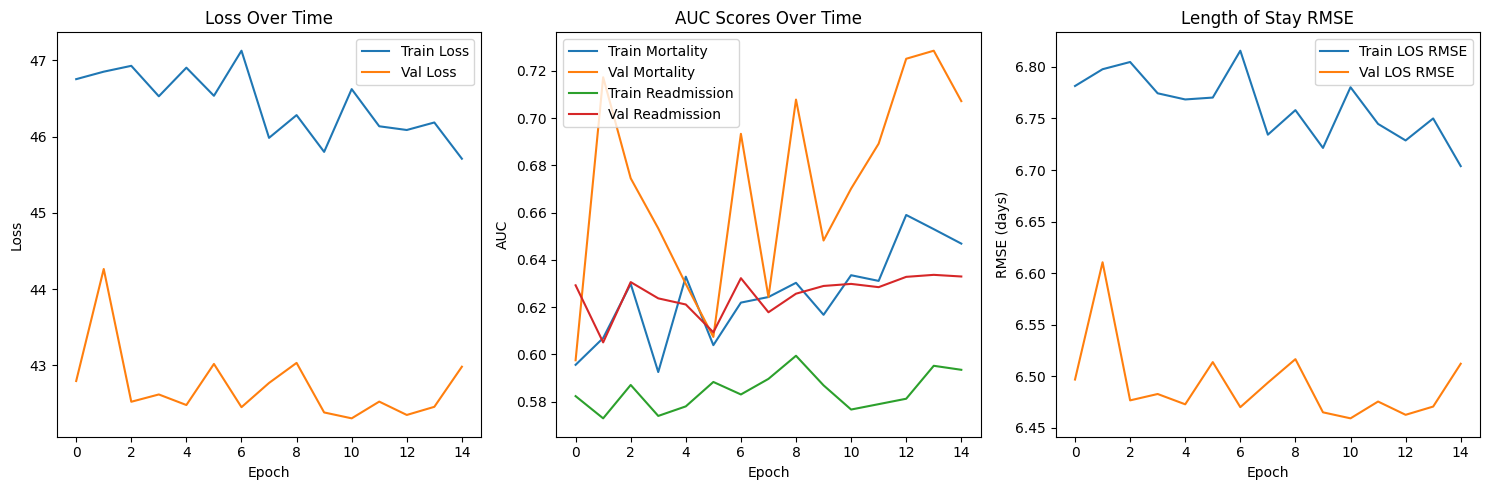

In [ ]:
# Visualization of training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC scores
plt.subplot(1, 3, 2)
plt.plot(history['train_mortality_auc'], label='Train Mortality')
plt.plot(history['val_mortality_auc'], label='Val Mortality')
plt.plot(history['train_readmission_auc'], label='Train Readmission')
plt.plot(history['val_readmission_auc'], label='Val Readmission')
plt.title('AUC Scores Over Time')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot LOS RMSE
plt.subplot(1, 3, 3)
plt.plot(history['train_los_rmse'], label='Train LOS RMSE')
plt.plot(history['val_los_rmse'], label='Val LOS RMSE')
plt.title('Length of Stay RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (days)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#SIMPLE BASELINES


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error

# Prepare data (use only structured features, not embeddings)
structured_cols = [col for col in X_train.columns if col not in ['subject_id', 'discharge_embedding', 'radiology_embedding']]
X_train_structured = X_train[structured_cols]
X_val_structured = X_val[structured_cols]

# 1. Logistic Regression for binary tasks
mortality_lr = LogisticRegression(max_iter=1000)
mortality_lr.fit(X_train_structured, y_train['mortality'])
lr_mortality_preds = mortality_lr.predict_proba(X_val_structured)[:, 1]
lr_mortality_auc = roc_auc_score(y_val['mortality'], lr_mortality_preds)

readmission_lr = LogisticRegression(max_iter=1000)
readmission_lr.fit(X_train_structured, y_train['readmission_30d'])
lr_readmission_preds = readmission_lr.predict_proba(X_val_structured)[:, 1]
lr_readmission_auc = roc_auc_score(y_val['readmission_30d'], lr_readmission_preds)

# 2. Random Forest for LOS
from sklearn.ensemble import RandomForestRegressor
los_rf = RandomForestRegressor(n_estimators=100)
los_rf.fit(X_train_structured, y_train['los_days'])
rf_los_preds = los_rf.predict(X_val_structured)
rf_los_rmse = np.sqrt(mean_squared_error(y_val['los_days'], rf_los_preds))

print("Baseline Results:")
print(f"Logistic Regression - Mortality AUC: {lr_mortality_auc:.4f}")
print(f"Logistic Regression - Readmission AUC: {lr_readmission_auc:.4f}")
print(f"Random Forest - LOS RMSE: {rf_los_rmse:.4f}")

Baseline Results:
Logistic Regression - Mortality AUC: 0.6952
Logistic Regression - Readmission AUC: 0.5191
Random Forest - LOS RMSE: 6.8252


In [ ]:
from sklearn.metrics import roc_auc_score, mean_squared_error
import numpy as np

# 1. Extract text embeddings for each patient (average of discharge and radiology embeddings)
def get_text_only_features():
    # Create numpy arrays from the embeddings we processed earlier
    train_discharge = np.array([emb for emb in train_dataset.discharge_embeddings])
    train_radiology = np.array([emb for emb in train_dataset.radiology_embeddings])

    val_discharge = np.array([emb for emb in val_dataset.discharge_embeddings])
    val_radiology = np.array([emb for emb in val_dataset.radiology_embeddings])

    # Combine discharge and radiology embeddings (average them)
    X_train_text = np.concatenate([train_discharge, train_radiology], axis=1)
    X_val_text = np.concatenate([val_discharge, val_radiology], axis=1)

    return X_train_text, X_val_text

X_train_text, X_val_text = get_text_only_features()

# 2. Train models using only text features
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# Mortality prediction
text_mortality_model = LogisticRegression(max_iter=1000)
text_mortality_model.fit(X_train_text, y_train['mortality'])
text_mortality_preds = text_mortality_model.predict_proba(X_val_text)[:, 1]
text_mortality_auc = roc_auc_score(y_val['mortality'], text_mortality_preds)

# Readmission prediction
text_readmission_model = LogisticRegression(max_iter=1000)
text_readmission_model.fit(X_train_text, y_train['readmission_30d'])
text_readmission_preds = text_readmission_model.predict_proba(X_val_text)[:, 1]
text_readmission_auc = roc_auc_score(y_val['readmission_30d'], text_readmission_preds)

# Length of stay prediction
text_los_model = RandomForestRegressor(n_estimators=100)
text_los_model.fit(X_train_text, y_train['los_days'])
text_los_preds = text_los_model.predict(X_val_text)
text_los_rmse = np.sqrt(mean_squared_error(y_val['los_days'], text_los_preds))

# Print results
print("\nText-Only Model Results:")
print(f"Text-Only - Mortality AUC: {text_mortality_auc:.4f}")
print(f"Text-Only - Readmission AUC: {text_readmission_auc:.4f}")
print(f"Text-Only - LOS RMSE: {text_los_rmse:.4f}")


Text-Only Model Results:
Text-Only - Mortality AUC: 0.7243
Text-Only - Readmission AUC: 0.6616
Text-Only - LOS RMSE: 6.6945



Comparison with Baselines:
                  Model  Mortality AUC  Readmission AUC  LOS RMSE
0   Logistic Regression       0.695235         0.519053       NaN
1         Random Forest            NaN              NaN  6.825223
2             Text-only       0.724307         0.661562  6.694535
3  Our Multi-Task Model       0.728500         0.633600  6.459300


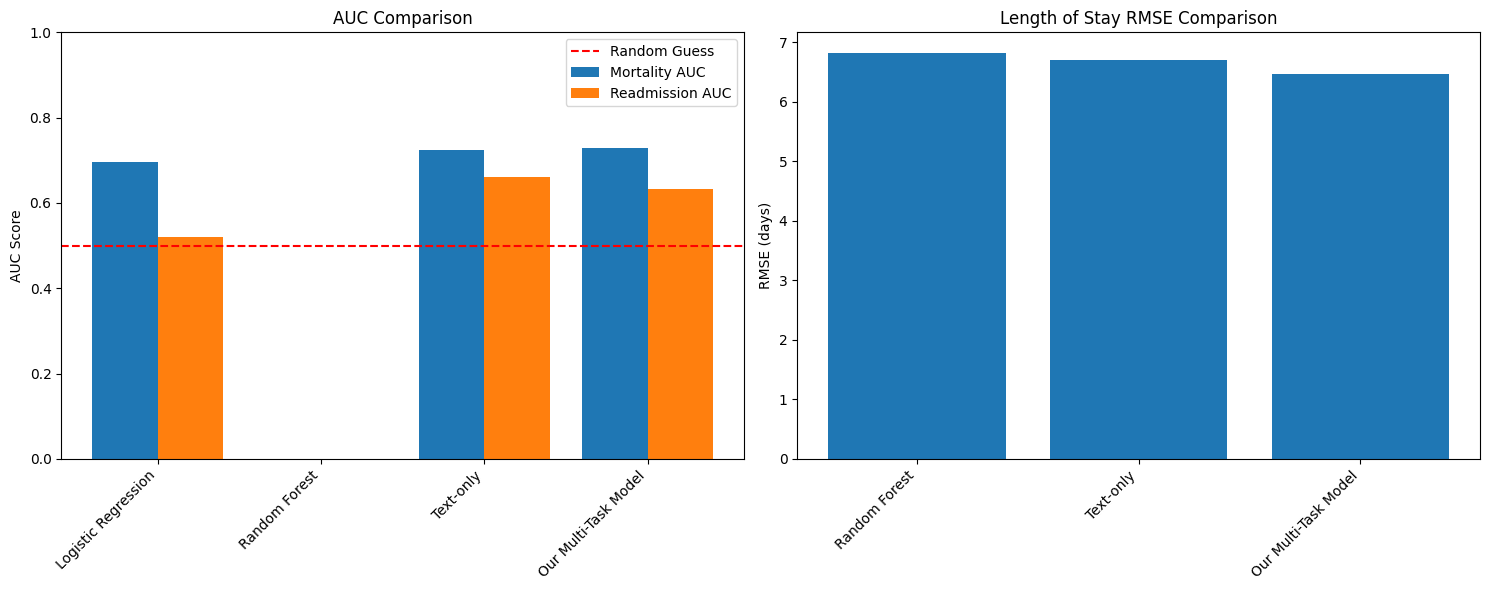

In [ ]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'Text-only', 'Our Multi-Task Model'],
    'Mortality AUC': [lr_mortality_auc, np.nan, text_mortality_auc, 0.7285],
    'Readmission AUC': [lr_readmission_auc, np.nan, text_readmission_auc, 0.6336],
    'LOS RMSE': [np.nan, rf_los_rmse, text_los_rmse, 6.4593]
}

results_df = pd.DataFrame(results)
print("\nComparison with Baselines:")
print(results_df)

# Visualizing comparative results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# AUC comparison
plt.subplot(1, 2, 1)
models = results_df['Model']
plt.bar(np.arange(len(models)) - 0.2, results_df['Mortality AUC'], width=0.4, label='Mortality AUC')
plt.bar(np.arange(len(models)) + 0.2, results_df['Readmission AUC'], width=0.4, label='Readmission AUC')
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
plt.xticks(np.arange(len(models)), models, rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.title('AUC Comparison')
plt.legend()
plt.ylim(0, 1)

# RMSE comparison
plt.subplot(1, 2, 2)
plt.bar(models, results_df['LOS RMSE'])
plt.ylabel('RMSE (days)')
plt.title('Length of Stay RMSE Comparison')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()